# Applying supervised learning to predict student dropout

Problem Statement: Confidential_Client plans to develop a predictive model that identifies at-risk adult learners early, enabling targeted interventions that improve retention.

In this project, we will examine student data and use supervised learning techniques to predict whether a student will drop out. In the education sector, retaining students is vital for the institution's financial stability and for students’ academic success and personal development. A high dropout rate can lead to significant revenue loss, diminished institutional reputation, and lower overall student satisfaction.

The three Datasets provided are:

1.  Applicant and course information
2.  Student and engagement data
3.  Academic performance data

These stages reflect Confidential_clients real-world data journey and how student information has progressed and become available.This approach will assist in determining at which stage of the student journey interventions would be most effective.

# Stage 1 data

In [ ]:
# Import Packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
    classification_report,
    roc_auc_score,
    precision_score,
    recall_score
)
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder
from sklearn.impute import SimpleImputer
import xgboost as xgb
from keras import layers, regularizers
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam, RMSprop


In [ ]:
# File URL
file_url = "https://drive.google.com/uc?id=1pA8DDYmQuaLyxADCOZe1QaSQwF16q1J6"

In [ ]:
# Read Stage 1 CSV
stg_1_data = pd.read_csv(file_url)
stg_1_data.head()

,CentreName,LearnerCode,BookingType,LeadSource,DiscountType,DateofBirth,Gender,Nationality,HomeState,HomeCity,CourseLevel,CourseName,IsFirstIntake,CompletedCourse,ProgressionDegree,ProgressionUniversity
0,ISC_Aberdeen,2284932,Agent,Standard Agent Booking,NaN,13/01/1998,Male,Chinese,Jianye District; Jiangsu Province,Nanjing,Pre-Masters,Business and Law Pre-Masters,True,Yes,Msc Econ Accounting and Investment Management,University of Aberdeen
1,ISC_Aberdeen,2399500,Agent,Standard Agent Booking,NaN,12/2/1998,Male,Chinese,NaN,Xi'an,Foundation,Life Sciences Undergraduate Foundation Programme,False,Yes,BSc Biological Sciences,University of Aberdeen
2,ISC_Aberdeen,2424946,Agent,Standard Agent Booking,NaN,7/4/2000,Male,Chinese,NaN,Chengdu,International Year Two,Business Management and Finance International ...,False,Yes,MA Finance,University of Aberdeen
3,ISC_Aberdeen,2426583,Agent,Standard Agent Booking,NaN,18/05/1999,Male,Chinese,NaN,LIUYANG CITY ;CHANGSHA,International Year Two,Business Management and Finance International ...,True,Yes,MA Business Management,University of Aberdeen
4,ISC_Aberdeen,2434674,Agent,Standard Agent Booking,NaN,19/04/1996,Male,Chinese,NaN,Xiamen,Pre-Masters,Business and Law Pre-Masters,True,Yes,MSc International Business Management,University of Aberdeen


In [ ]:
stg_1_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25059 entries, 0 to 25058
Data columns (total 17 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   CentreName             25059 non-null  object        
 1   LearnerCode            25059 non-null  int64         
 2   BookingType            25059 non-null  object        
 3   LeadSource             25059 non-null  object        
 4   DiscountType           7595 non-null   object        
 5   DateofBirth            25059 non-null  datetime64[ns]
 6   Gender                 25059 non-null  object        
 7   Nationality            25059 non-null  object        
 8   HomeState              8925 non-null   object        
 9   HomeCity               21611 non-null  object        
 10  CourseLevel            25059 non-null  object        
 11  CourseName             25059 non-null  object        
 12  IsFirstIntake          25059 non-null  bool          
 13  C

The stage 1 Dataset provided by Study Group consisted of 25,059 rows and 16 features related to
student applications. It’s to be noted that 15/16 features in original data set are categorical data.

**Stage 1: Pre-processing**
- Columns with high cardinality (use >200 unique values) will be removed
- Columns with  50% data missing will be removed
- Categorical Data will be encoded

In [ ]:
#Unique Values for each Feature
n_unique_values= stg_1_data.nunique()
print("number of unique values for all features:\n", n_unique_values, end="\n\n")

number of unique values for all features:
 CentreName                  19
LearnerCode              24877
BookingType                  2
LeadSource                   7
DiscountType                11
DateofBirth               4705
Gender                       2
Nationality                151
HomeState                 2448
HomeCity                  5881
CourseLevel                  4
CourseName                 172
IsFirstIntake                2
CompletedCourse              2
ProgressionDegree         2616
ProgressionUniversity       40
Age                       4705
dtype: int64



**Feature Engineering:**

A new feature, Age, was derived from Date of Birth, highly correlated features were merged to
reduce dimensionality and address multicollinearity—Centre Name and Progression University
were combined into Centre_University, while Booking Type and Lead Source were merged into
Booking_LeadSource. Categorical variables were encoded using One-Hot Encoding for nominal
features and Ordinal Encoding for ordinal features

In [ ]:
# Convert the DateofBirth column to a datetime data type
stg_1_data['DateofBirth'] = pd.to_datetime(stg_1_data['DateofBirth'])
print(stg_1_data['DateofBirth'].dtype)

datetime64[ns]


In [ ]:
#Define Date of Today
today = pd.to_datetime('today').normalize()
print(today)

#Convert DateofBirth to Age
stg_1_data['Age'] = (today - stg_1_data['DateofBirth']).dt.days/ 365
print(stg_1_data['Age'])

2025-02-19 00:00:00
0        27.120548
1        27.038356
2        24.887671
3        25.778082
4        28.857534
           ...    
25054    32.736986
25055    29.947945
25056    27.517808
25057    23.134247
25058    37.315068
Name: Age, Length: 25059, dtype: float64


In [ ]:
stg_1_data.head()

,CentreName,LearnerCode,BookingType,LeadSource,DiscountType,DateofBirth,Gender,Nationality,HomeState,HomeCity,CourseLevel,CourseName,IsFirstIntake,CompletedCourse,ProgressionDegree,ProgressionUniversity,Age
0,ISC_Aberdeen,2284932,Agent,Standard Agent Booking,NaN,1998-01-13,Male,Chinese,Jianye District; Jiangsu Province,Nanjing,Pre-Masters,Business and Law Pre-Masters,True,Yes,Msc Econ Accounting and Investment Management,University of Aberdeen,27.120548
1,ISC_Aberdeen,2399500,Agent,Standard Agent Booking,NaN,1998-02-12,Male,Chinese,NaN,Xi'an,Foundation,Life Sciences Undergraduate Foundation Programme,False,Yes,BSc Biological Sciences,University of Aberdeen,27.038356
2,ISC_Aberdeen,2424946,Agent,Standard Agent Booking,NaN,2000-04-07,Male,Chinese,NaN,Chengdu,International Year Two,Business Management and Finance International ...,False,Yes,MA Finance,University of Aberdeen,24.887671
3,ISC_Aberdeen,2426583,Agent,Standard Agent Booking,NaN,1999-05-18,Male,Chinese,NaN,LIUYANG CITY ;CHANGSHA,International Year Two,Business Management and Finance International ...,True,Yes,MA Business Management,University of Aberdeen,25.778082
4,ISC_Aberdeen,2434674,Agent,Standard Agent Booking,NaN,1996-04-19,Male,Chinese,NaN,Xiamen,Pre-Masters,Business and Law Pre-Masters,True,Yes,MSc International Business Management,University of Aberdeen,28.857534


In [ ]:
#Number of duplicated Rows
duplicated_rows= stg_1_data.duplicated().sum()
print(duplicated_rows)

0


In [ ]:
#features with more than 200 unique Values
Features_more_than_200_unique_values = n_unique_values[n_unique_values>200]
print("Features with more than 200 unique values:\n", Features_more_than_200_unique_values , end="\n")

Features with more than 200 unique values:
 LearnerCode          24877
DateofBirth           4705
HomeState             2448
HomeCity              5881
ProgressionDegree     2616
Age                   4705
dtype: int64


In [ ]:
# Total number of rows
total_rows = 25059

# Total number of missing values for each column
missing_values = stg_1_data.isnull().sum()

# percentage of missing values for each column
missing_percentage = (missing_values / total_rows) * 100


print(missing_values)
print(missing_percentage)

CentreName                   0
LearnerCode                  0
BookingType                  0
LeadSource                   0
DiscountType             17464
DateofBirth                  0
Gender                       0
Nationality                  0
HomeState                16134
HomeCity                  3448
CourseLevel                  0
CourseName                   0
IsFirstIntake                0
CompletedCourse              0
ProgressionDegree          875
ProgressionUniversity        0
Age                          0
dtype: int64
CentreName                0.000000
LearnerCode               0.000000
BookingType               0.000000
LeadSource                0.000000
DiscountType             69.691528
DateofBirth               0.000000
Gender                    0.000000
Nationality               0.000000
HomeState                64.384054
HomeCity                 13.759528
CourseLevel               0.000000
CourseName                0.000000
IsFirstIntake             0.000000
Compl

In [ ]:
#Drop the following columns:
stage_1_data = stg_1_data.drop(['LearnerCode','DateofBirth', 'DiscountType', 'HomeState', 'HomeCity', 'ProgressionDegree'], axis=1)

In [ ]:
stage_1_data.head()

,CentreName,BookingType,LeadSource,Gender,Nationality,CourseLevel,CourseName,IsFirstIntake,CompletedCourse,ProgressionUniversity,Age
0,ISC_Aberdeen,Agent,Standard Agent Booking,Male,Chinese,Pre-Masters,Business and Law Pre-Masters,True,Yes,University of Aberdeen,27.120548
1,ISC_Aberdeen,Agent,Standard Agent Booking,Male,Chinese,Foundation,Life Sciences Undergraduate Foundation Programme,False,Yes,University of Aberdeen,27.038356
2,ISC_Aberdeen,Agent,Standard Agent Booking,Male,Chinese,International Year Two,Business Management and Finance International ...,False,Yes,University of Aberdeen,24.887671
3,ISC_Aberdeen,Agent,Standard Agent Booking,Male,Chinese,International Year Two,Business Management and Finance International ...,True,Yes,University of Aberdeen,25.778082
4,ISC_Aberdeen,Agent,Standard Agent Booking,Male,Chinese,Pre-Masters,Business and Law Pre-Masters,True,Yes,University of Aberdeen,28.857534


In [ ]:
#Ordinal Encoding Categorical Features:
CourseLevel= ['Foundation','International Year One','International Year Two','Pre-Masters']
CompletedCourse = ['No','Yes']
IsFirstIntake = [False,True]
Gender = ['Male','Female']

ordinal_categories = [CourseLevel, CompletedCourse, IsFirstIntake,Gender]

ordinal_encoder = OrdinalEncoder(categories=ordinal_categories)
stage_1_data[['CourseLevel', 'CompletedCourse', 'IsFirstIntake','Gender']] = ordinal_encoder.fit_transform(stage_1_data[['CourseLevel', 'CompletedCourse', 'IsFirstIntake','Gender']])

In [ ]:
stage_1_data.head()

,CentreName,BookingType,LeadSource,Gender,Nationality,CourseLevel,CourseName,IsFirstIntake,CompletedCourse,ProgressionUniversity,Age
0,ISC_Aberdeen,Agent,Standard Agent Booking,0.0,Chinese,3.0,Business and Law Pre-Masters,1.0,1.0,University of Aberdeen,27.120548
1,ISC_Aberdeen,Agent,Standard Agent Booking,0.0,Chinese,0.0,Life Sciences Undergraduate Foundation Programme,0.0,1.0,University of Aberdeen,27.038356
2,ISC_Aberdeen,Agent,Standard Agent Booking,0.0,Chinese,2.0,Business Management and Finance International ...,0.0,1.0,University of Aberdeen,24.887671
3,ISC_Aberdeen,Agent,Standard Agent Booking,0.0,Chinese,2.0,Business Management and Finance International ...,1.0,1.0,University of Aberdeen,25.778082
4,ISC_Aberdeen,Agent,Standard Agent Booking,0.0,Chinese,3.0,Business and Law Pre-Masters,1.0,1.0,University of Aberdeen,28.857534


In [ ]:
#Nominal Categorical Features Encoding:
nominal_encoded_data= stage_1_data.copy()

#Drop Ordinal categories and numeric features
nominal_encoded_data.drop(['CourseLevel', 'CompletedCourse', 'IsFirstIntake','Age','Gender'], axis=1, inplace=True)

#Combine CentreName and Progression University column to create CentreUniversity Column
nominal_encoded_data['Centre_University'] = nominal_encoded_data['CentreName'] + " - " + nominal_encoded_data['ProgressionUniversity']

#Combine the Booking type and leadsource columns to create Booking_LeadSource Column:
nominal_encoded_data['Booking_LeadSource'] = nominal_encoded_data['BookingType'] + " - " + nominal_encoded_data['LeadSource']

#Drop unneccessary Columns:
nominal_encoded_data.drop(['CentreName', 'ProgressionUniversity', 'BookingType', 'LeadSource'], axis=1, inplace=True)


I mapped the variation of names for the same centre_university to  reduce the number of categories, this will reduce cardinality in this feature before we can One Hot encode.

In [ ]:
# Mapping different variation of the same Centre_University name to a consistent name:
name_mapping = {
    'ISC_Holland - Holland ISC - VU Amsterdam': 'ISC_Holland - VU Amsterdam',
    'ISC_Holland - Holland ISC - Tilburg University': 'ISC_Holland - Tilburg University',
    'ISC_Holland - Holland ISC - Erasmus University Rotterdam': 'ISC_Holland - Holland ISC - Erasmus University Rotterdam',
    'ISC_Holland - VU Amsterdam': 'ISC_Holland - VU Amsterdam',
    'ISC_Holland - Holland ISC - Hanze UAS': 'ISC_Holland - Hanze UAS',
    'ISC_Holland - Tilburg University': 'ISC_Holland - Tilburg University',
    'ISC_Holland - Erasmus Rotterdam': 'ISC_Holland - Holland ISC - Erasmus University Rotterdam',
    'ISC_Holland - Hanze UAS': 'ISC_Holland - Hanze UAS',
    'ISC_Holland - Holland ISC - Erasmus University Rotterdam/ Holland ISC - Tilburg University': 'ISC_Holland - Holland ISC - Erasmus University Rotterdam/ Tilburg University',
    'ISC_Holland - Holland ISC - Erasmus University Rotterdam/Holland ISC - VU Amsterdam': 'ISC_Holland - Holland ISC - Erasmus University Rotterdam/ VU Amsterdam',
    'ISC_Holland - Holland ISC - Tilburg University/VU Amsterdam/Hanze': 'ISC_Holland - Holland ISC - Tilburg University/VU Amsterdam/Hanze',
    'ISC_Holland - Holland ISC - VU Amsterdam/ Military service': 'ISC_Holland - VU Amsterdam/ Military service',
    'ISC_Holland - Holland ISC - Hanze UAS/VU Amsterdam': 'ISC_Holland - Holland ISC - Hanze UAS/VU Amsterdam',
    'ISC_Holland - Holland ISC - Erasmus University Rotterdam/Tilburg University': 'ISC_Holland - Holland ISC - Erasmus University Rotterdam/Tilburg University',
    'ISC_Holland - Holland ISC - Erasmus University Rotterdam/Holland ISC - Tilburg University': 'ISC_Holland - Holland ISC - Erasmus University Rotterdam/Tilburg University',

}

# Apply mapping to the Centre_University feature:
nominal_encoded_data['Centre_University'] = nominal_encoded_data['Centre_University'].replace(name_mapping)

# Verify the result by displaying the counts of the unique combinations
standardized_name_counts = nominal_encoded_data['Centre_University'].value_counts().reset_index()
standardized_name_counts.columns = ['Centre_University', 'Count']
print(standardized_name_counts)


                                    Centre_University  Count
0   ISC_Sheffield - University of Sheffield Intern...   5877
1                      ISC_Durham - Durham University   2563
2                   ISC_Sussex - University of Sussex   2103
3           ISC_Kingston - Kingston University London   1892
4       ISC_Huddersfield - University of Huddersfield   1781
5                     ISC_Leeds - University of Leeds   1591
6                ISC_Lancaster - Lancaster University   1082
7                   ISC_Surrey - University of Surrey   1051
8                           ISC_RHUL - Royal Holloway   1046
9         ISC_LJMU - Liverpool John Moores University    950
10            ISC_London - Coventry University London    930
11               ISC_Leeds - Leeds Beckett University    703
12                   ISC_Cardiff - Cardiff University    687
13        ISC_Strathclyde - University of Strathclyde    670
14                 ISC_Teesside - Teesside University    632
15             ISC_Dubli

In [ ]:
print(nominal_encoded_data.head())

  Nationality                                         CourseName  \
0     Chinese                       Business and Law Pre-Masters   
1     Chinese   Life Sciences Undergraduate Foundation Programme   
2     Chinese  Business Management and Finance International ...   
3     Chinese  Business Management and Finance International ...   
4     Chinese                       Business and Law Pre-Masters   

                       Centre_University              Booking_LeadSource  
0  ISC_Aberdeen - University of Aberdeen  Agent - Standard Agent Booking  
1  ISC_Aberdeen - University of Aberdeen  Agent - Standard Agent Booking  
2  ISC_Aberdeen - University of Aberdeen  Agent - Standard Agent Booking  
3  ISC_Aberdeen - University of Aberdeen  Agent - Standard Agent Booking  
4  ISC_Aberdeen - University of Aberdeen  Agent - Standard Agent Booking  


In [ ]:
#One Hot Encode Remaining Categorical Features:
# Initialize OneHotEncoder
enc = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

# Fit and transform the data
encoded_data = enc.fit_transform(nominal_encoded_data)

# Get the features
nominal_columns = enc.get_feature_names_out()

# Create a DataFrame from the encoded data
encoded_df = pd.DataFrame(encoded_data, columns=nominal_columns)


# Combine the encoded columns with the rest of the features in a new DataFrame
final_encoded_df = pd.concat([stage_1_data[['CourseLevel', 'CompletedCourse', 'IsFirstIntake','Age','Gender']], encoded_df], axis=1)

print(final_encoded_df.head())

   CourseLevel  CompletedCourse  IsFirstIntake        Age  Gender  \
0          3.0              1.0            1.0  27.120548     0.0   
1          0.0              1.0            0.0  27.038356     0.0   
2          2.0              1.0            0.0  24.887671     0.0   
3          2.0              1.0            1.0  25.778082     0.0   
4          3.0              1.0            1.0  28.857534     0.0   

   Nationality_(Not known)  Nationality_Afghan  Nationality_Albanian  \
0                      0.0                 0.0                   0.0   
1                      0.0                 0.0                   0.0   
2                      0.0                 0.0                   0.0   
3                      0.0                 0.0                   0.0   
4                      0.0                 0.0                   0.0   

   Nationality_Algerian  Nationality_American  ...  \
0                   0.0                   0.0  ...   
1                   0.0                   0.

After pre-processing stage 1 data set, 'completedcourse', our target variable was checked for imbalance

In [ ]:
#Check for imbalance in target variable: 'CompletedCourse'
completed_course_counts = final_encoded_df['CompletedCourse'].value_counts(normalize=True)
print(completed_course_counts)


CompletedCourse
1.0    0.850194
0.0    0.149806
Name: proportion, dtype: float64


The dataset is imbalanced with 85% of the data being one class (completed course) compared to the other class (not completing the course)


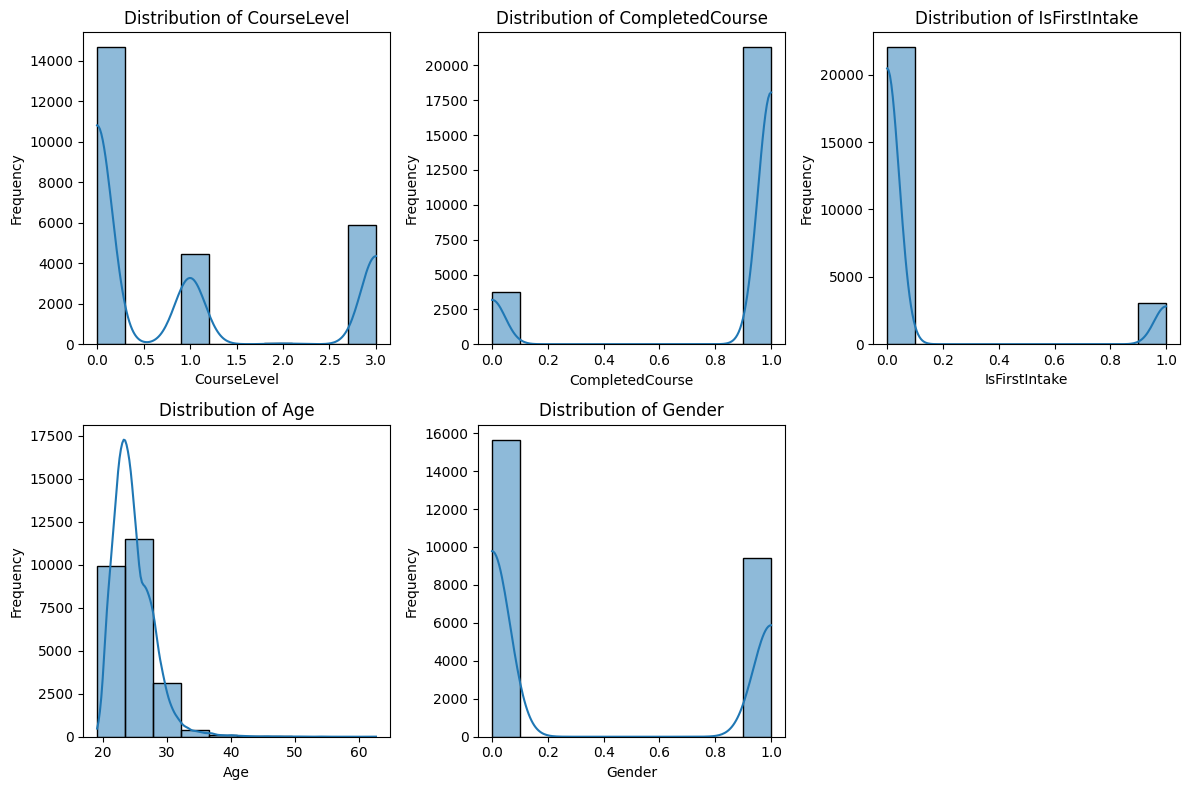

In [ ]:
# Histogram Visualisation for Ordinal Features:

Ordinal_or_numeric_features = stage_1_data[['CourseLevel', 'CompletedCourse', 'IsFirstIntake','Age','Gender']]

plt.figure(figsize=(12, 8))
for i, column in enumerate(Ordinal_or_numeric_features.columns, 1):
    plt.subplot(2, 3, i)
    sns.histplot(Ordinal_or_numeric_features[column], kde=True, bins=10)
    plt.title(f'Distribution of {column}')
    plt.xlabel(column)
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

Age distribution is right skewed, this is to be expected since University is applied to primarily by students in the age group 20-30.

Gender Distribution is skewed, the data set is male-dominant

Courselevel distribution is also skewed, majority of the applicants are foundation level courses, with small representation of International year one and Pre-masters, but no international year two students in the dataset.

Majoirty of the applicants are not firstintake, this needs to be further defined with regards to whether they are repeaters,deffered students etc

## Data Splitting for Stage 1 Dataset Modelling

The Dataset was split 80-20% training and testing, with a further 20% of training data being used for Validation

Features Used for Training the Model at Stage 1:
The model was trained using the following features: 'Course Level', 'Completed
Course', IsFirstIntake', 'Age', 'Gender', 'Nationality', 'Course_Name', 'Centre_University' and 'Booking_LeadSource'

The target variable 'CompletedCourse' was stratified to reduce the impact of value classes being imbalanced

In [ ]:
#Data Splitting and Training:
# Split the data into features (X) and the target variable (y)
X = final_encoded_df.drop('CompletedCourse', axis=1)
y = final_encoded_df['CompletedCourse']

#Train Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42,stratify=y)
X_train,X_val,y_train,y_val = train_test_split(X_train,y_train,test_size=0.2,random_state=42, stratify=y_train)


#view output
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: (16037, 378)
X_test shape: (5012, 378)
y_train shape: (16037,)
y_test shape: (5012,)


## XGBOOST Modelling:

Stage 1 Dataset Model Training:

- The initial model was run with default hyperparameters to establish a baseline.
- Performance metrics (accuracy, AUC, precision, and recall) were recorded.

- A feature importance chart was generated using the training data to identify key features.

- Hyperparameter Tuning:
o A grid search was conducted to find the best combination of hyperparameters based on the highest AUC score.

- The following hyperparameters were tuned:

o alpha: [0.1, 0.3, 0.5]
o max_depth: [3, 5, 7]
o learning_rate: [0.01, 0.1, 0.2]
o n_estimators: [50, 100, 200]

- Final Model:
 The best hyperparameter combination was used to train the final model, and
performance metrics were recorded.

### Initial training of  XGBoost Model

Initial Model Accuracy: 0.8898643256185156
Initial Model AUC Score: 0.7383380869628261
Initial Model Classification Report:
              precision    recall  f1-score   support

         0.0       0.67      0.52      0.59       751
         1.0       0.92      0.95      0.94      4261

    accuracy                           0.89      5012
   macro avg       0.79      0.74      0.76      5012
weighted avg       0.88      0.89      0.88      5012



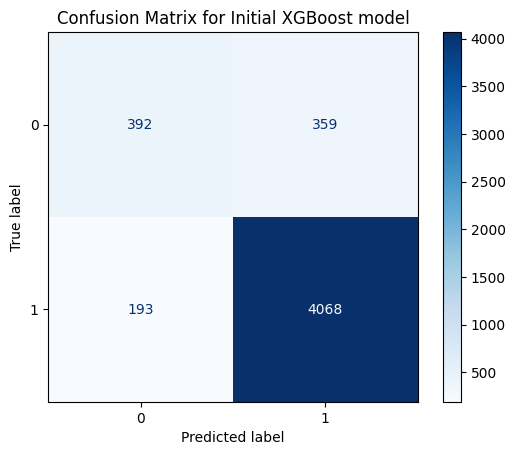

In [ ]:
import xgboost as xgb
initial_xg_model = xgb.XGBClassifier(random_state=42)
initial_xg_model.fit(X_train, y_train)

#Model Evaluation metrics
y_pred = initial_xg_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)
auc_score = roc_auc_score(y_test, y_pred)

# View output
print(f"Initial Model Accuracy: {accuracy}")
print(f"Initial Model AUC Score: {auc_score}")
print("Initial Model Classification Report:")
print(classification_rep)

#plot confusion matrix
conf_matrix_Initial = confusion_matrix(y_test, y_pred)
Initial_conf_matrix = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_Initial, display_labels=initial_xg_model.classes_)
Initial_conf_matrix.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix for Initial XGBoost model")
plt.show()


### Feature Importance Bar Chart for Initial XGBoost Model

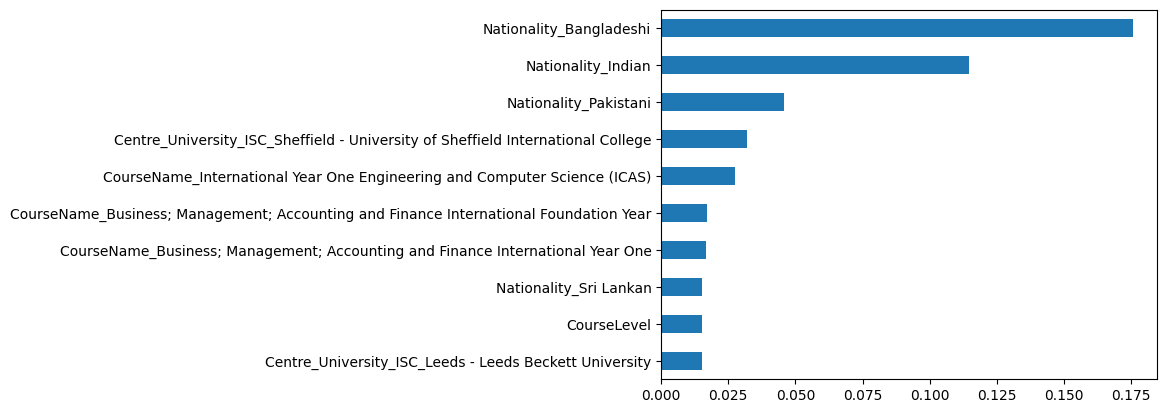

In [ ]:
# Convert x_train which is a numpy array into a data frame
x_train_df = pd.DataFrame(X_train, columns=X_train.columns)

#feature importance
feature_importance = pd.Series(initial_xg_model.feature_importances_,index=x_train_df.columns).sort_values()

feature_importance.iloc[-10:].plot.barh()
plt.show()

### Hyperparameter Tuning for XGBoost Model

In [ ]:
#Hyperparameter Tuning for XGBoost Model
from sklearn.model_selection import GridSearchCV

hyperparameter_tuning = {
    'alpha': [0.1, 0.3, 0.5],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [50, 100,200]
}

#GridSearchCV
grid_search = GridSearchCV(estimator=initial_xg_model, param_grid=hyperparameter_tuning, cv=5, scoring='roc_auc', verbose=1)
grid_search.fit(X_train, y_train)

#Output for the best Hyperparameter combination with regards to AUC
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best AUC score: {grid_search.best_score_}")


Fitting 5 folds for each of 81 candidates, totalling 405 fits
Best parameters: {'alpha': 0.5, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200}
Best AUC score: 0.876840367912975


Final Model Accuracy: 0.8896648044692738
Final Model AUC Score: 0.727800466935895
Final Model Classification Report:
              precision    recall  f1-score   support

         0.0       0.68      0.50      0.57       751
         1.0       0.92      0.96      0.94      4261

    accuracy                           0.89      5012
   macro avg       0.80      0.73      0.76      5012
weighted avg       0.88      0.89      0.88      5012



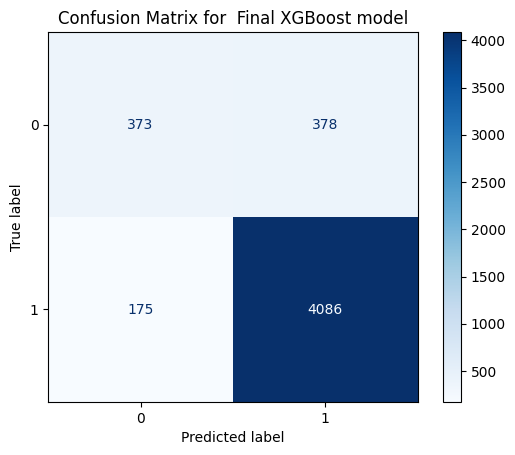

In [ ]:
#Test the hyperparameter combination selectef from the tuning
final_xg_model = xgb.XGBClassifier(random_state=42, alpha= 0.5, learning_rate=0.1, max_depth= 5, n_estimators=200)
final_xg_model.fit(X_train, y_train)

#Model Evaluation metrics
y_pred = final_xg_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)
auc_score = roc_auc_score(y_test, y_pred)

# View output
print(f"Final Model Accuracy: {accuracy}")
print(f"Final Model AUC Score: {auc_score}")
print("Final Model Classification Report:")
print(classification_rep)

#plot confusion matrix
conf_matrix_final = confusion_matrix(y_test, y_pred)
Initial_conf_matrix = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_final, display_labels=final_xg_model .classes_)
Initial_conf_matrix.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix for  Final XGBoost model")
plt.show()


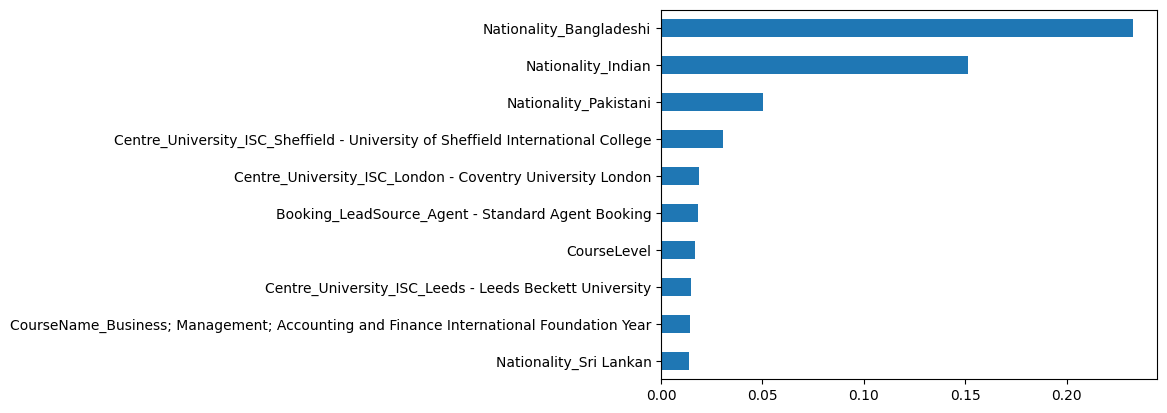

In [ ]:
# Feature Importance for Final XGBOOST:
# Convert x_train which is a numpy array into a data frame
x_train_df = pd.DataFrame(X_train, columns=X_train.columns)

#feature importance
feature_importance = pd.Series(final_xg_model.feature_importances_,index=x_train_df.columns).sort_values()

feature_importance.iloc[-10:].plot.barh()
plt.show()

### Comparsion on Performance metrics of the XGBoost Model before and after hyper parameter tuning:



Hyperparameter tuning produced minimal improvements in the predictive perfomance metrics of the XBoost model.

Also from the feature importance, its evident that Nationality is the most the most important feature from the stage 1 data set, it is represented 4 times in the top 10 features.


# Neural Network Modelling for Stage 1 :

In [ ]:
#Scale training Data before using on Neural Network

#Scaling using standard Scaler:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_val= scaler.transform(X_val)

#view output
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: (16037, 378)
X_test shape: (5012, 378)
y_train shape: (16037,)
y_test shape: (5012,)


The sequential model type was used to build our neural network model, this is because we used one input data set and want one output and used no branches in our model.  

In our initial model we used the following hyperparameters:
- Binary cross-entropy loss function was used as this is a binary classification
- Relu was the chosen hiddenlayer activation function,
- sigmoid activation function was used
in the output layer
- 2 hidden layers was chosen since the data set has only 25059 rows
- 128 neurons was used in the first hidden layer and in the second hidden layer the number of neurons was halved
- 1 neuron was used in the output layer
- Adam Optimiser was selected as the initial optimiser for this model
- L1 regulariser with 0.001 alpha strength was selected in the initial model to prevent overfitting as it is better at dealing with sparse one-hot encoded features.

- The metrics, Accuracy, Precision, Recall, AUC were recorded for our model when it was ran for 20 epochs with a batch size of 32.

In [ ]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, roc_auc_score
from keras import layers
from keras.models import Sequential
from keras.layers import Dense
from keras.regularizers import l1, l2

#Create Function for the model
def create_model(neurons=128, hidden_layers=2, activation='relu', optimizer='adam', kernel_regularizer=l1(0.001)):
    model = Sequential()
    model.add(Dense(units=neurons, activation=activation, input_shape=(X_train.shape[1],),kernel_regularizer=kernel_regularizer))
    model.add(Dense(units=neurons//2, activation=activation))
    model.add(Dense(1, activation='sigmoid'))


  #Compile Model
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy', 'Precision', 'Recall', 'AUC',])
    return model


L1 was used as regulariser as we have alot of sparsity in our dataset with 377 binary features out of 378. We have huge number of features

Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


502/502 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - AUC: 0.7796 - Precision: 0.8884 - Recall: 0.9398 - accuracy: 0.8492 - loss: 1.3326 - val_AUC: 0.8811 - val_Precision: 0.9055 - val_Recall: 0.9698 - val_accuracy: 0.8883 - val_loss: 0.4088
Epoch 2/20
502/502 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - AUC: 0.8629 - Precision: 0.9127 - Recall: 0.9606 - accuracy: 0.8883 - loss: 0.4051 - val_AUC: 0.8781 - val_Precision: 0.9280 - val_Recall: 0.9495 - val_accuracy: 0.8945 - val_loss: 0.3612
Epoch 3/20
502/502 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - AUC: 0.8802 - Precision: 0.9206 - Recall: 0.9536 - accuracy: 0.8908 - loss: 0.3569 - val_AUC: 0.8827 - val_Precision: 0.9197 - val_Recall: 0.9542 - val_accuracy: 0.8903 - val_loss: 0.3495
Epoch 4/20
502/502 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - AUC: 0.8794 - Precision: 0.9224 - Recall: 0.9582 - accuracy: 0.8957 - loss: 0.3375 - val_AUC: 0.8826 - val_Precision: 0.9110 - val_Recall: 0.9669 - val_accuracy: 0.8915 - val_loss: 0.3306
Epoch 5/20
502/502 ━━━━━━━━━━━━━━━━━━━━ 3s 

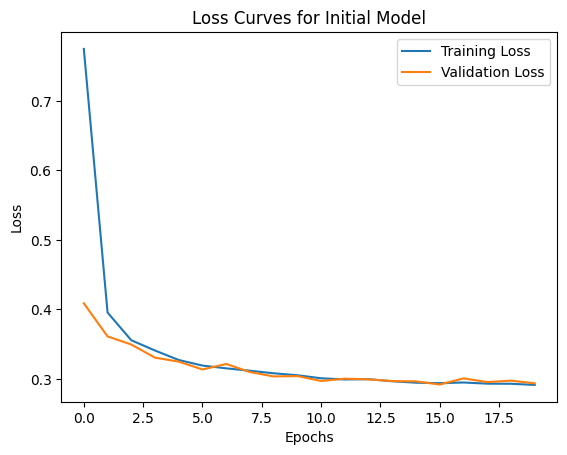

In [ ]:
#Instantiate the initial model
model= create_model()
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_val, y_val))

#Plot loss curves for training and validation:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Curves for Initial Model')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [ ]:
#Evaluate the initial model on the test set
y_pred = model.predict(X_test).round()

# Performance metrics of the initial model on the test data
initial_model_accuracy = accuracy_score(y_test, y_pred)
initial_model_conf_matrix = confusion_matrix(y_test, y_pred)
initial_model_precision = precision_score(y_test, y_pred)
initial_model_recall = recall_score(y_test, y_pred)
initial_model_auc_score = roc_auc_score(y_test, y_pred)

#Print the performance metrics:
print("Initial model Accuracy:", initial_model_accuracy )
print("Initial model Confusion Matrix:\n",initial_model_conf_matrix)
print("Initial model Precision:", initial_model_precision)
print("Initial model Recall:", initial_model_recall)
print("Initial model AUC Score:", initial_model_auc_score)


157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Initial model Accuracy: 0.8954509177972865
Initial model Confusion Matrix:
 [[ 405  346]
 [ 178 4083]]
Initial model Precision: 0.9218785278843983
Initial model Recall: 0.9582257685989204
Initial model AUC Score: 0.7487533636603124


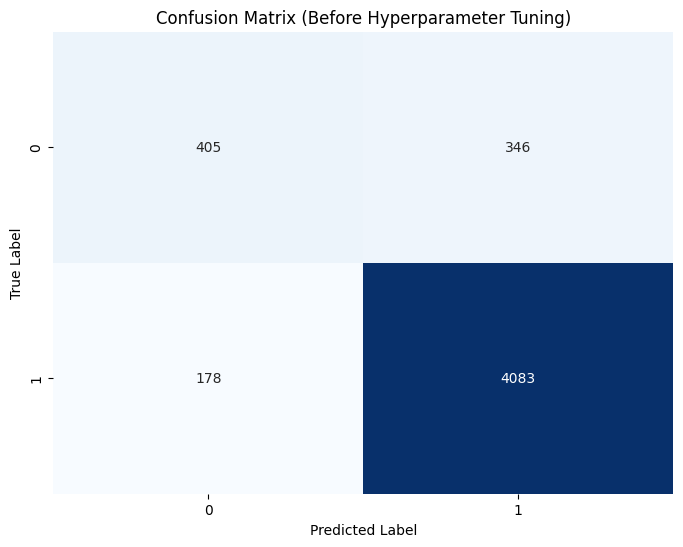

In [ ]:
def plot_confusion_matrix(initial_model_conf_matrix, title="Confusion Matrix"):
    plt.figure(figsize=(8, 6))
    sns.heatmap(initial_model_conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(title)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

# Plot confusion matrix before hyperparameter tuning
plot_confusion_matrix(initial_model_conf_matrix, title="Confusion Matrix (Before Hyperparameter Tuning)")

#Hyper Parameter tuning for stage 1 Data set

In [ ]:
from keras.optimizers import Adam, RMSprop
from keras.models import Sequential
from keras.layers import Dense
from keras import regularizers
import numpy as np
import matplotlib.pyplot as plt

#Results dictionary:
results = {}

# Hyperparameter tuning
neurons = [32, 64, 128]
activations = ['relu', 'tanh']
regularizers = [regularizers.l1(0.001),regularizers.l1(0.01)]
optimizers = ['adam', 'rmsprop']

#Loop for each Vector:
for neuron in neurons:
    for activation in activations:
        for optimizer in optimizers:
            for regularizer in regularizers:
                print(f"Training with {neuron} neurons, {activation} activation, {optimizer} optimizer, {regularizer} regularizer")
                model = create_model(neurons=neuron, activation=activation, optimizer=optimizer, kernel_regularizer=regularizer)
                history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_val, y_val))
                val_AUC = history.history['val_AUC'][-1]
                results[(neuron, activation, optimizer, regularizer)] = val_AUC

# Output for the hyperparameter combination with highest Val_AUC
best_params = max(results, key=results.get)
best_val_auc = results[best_params]
print(f"Best combination: {best_params} with validation AUC: {best_val_auc}")

Training with 32 neurons, relu activation, adam optimizer, <keras.src.regularizers.regularizers.L1 object at 0x7e8b6afdbd10> regularizer
Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


502/502 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - AUC: 0.7755 - Precision: 0.8849 - Recall: 0.9214 - accuracy: 0.8307 - loss: 0.7719 - val_AUC: 0.8769 - val_Precision: 0.9138 - val_Recall: 0.9613 - val_accuracy: 0.8900 - val_loss: 0.3908
Epoch 2/20
502/502 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8734 - Precision: 0.9178 - Recall: 0.9616 - accuracy: 0.8938 - loss: 0.3748 - val_AUC: 0.8777 - val_Precision: 0.9176 - val_Recall: 0.9598 - val_accuracy: 0.8925 - val_loss: 0.3502
Epoch 3/20
502/502 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.8790 - Precision: 0.9212 - Recall: 0.9600 - accuracy: 0.8959 - loss: 0.3385 - val_AUC: 0.8840 - val_Precision: 0.9226 - val_Recall: 0.9586 - val_accuracy: 0.8965 - val_loss: 0.3325
Epoch 4/20
502/502 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8829 - Precision: 0.9215 - Recall: 0.9576 - accuracy: 0.8945 - loss: 0.3266 - val_AUC: 0.8822 - val_Precision: 0.9235 - val_Recall: 0.9557 - val_accuracy: 0.8950 - val_loss: 0.3242
Epoch 5/20
502/502 ━━━━━━━━━━━━━━━━━━━━ 3s 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


502/502 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - AUC: 0.7547 - Precision: 0.8555 - Recall: 0.9784 - accuracy: 0.8425 - loss: 2.6038 - val_AUC: 0.8585 - val_Precision: 0.9190 - val_Recall: 0.9451 - val_accuracy: 0.8825 - val_loss: 0.4047
Epoch 2/20
502/502 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8495 - Precision: 0.9124 - Recall: 0.9541 - accuracy: 0.8828 - loss: 0.4132 - val_AUC: 0.8531 - val_Precision: 0.9093 - val_Recall: 0.9563 - val_accuracy: 0.8818 - val_loss: 0.4137
Epoch 3/20
502/502 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - AUC: 0.8590 - Precision: 0.9127 - Recall: 0.9527 - accuracy: 0.8830 - loss: 0.4064 - val_AUC: 0.8752 - val_Precision: 0.9047 - val_Recall: 0.9718 - val_accuracy: 0.8890 - val_loss: 0.3817
Epoch 4/20
502/502 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8563 - Precision: 0.9109 - Recall: 0.9546 - accuracy: 0.8825 - loss: 0.3912 - val_AUC: 0.8652 - val_Precision: 0.9086 - val_Recall: 0.9566 - val_accuracy: 0.8813 - val_loss: 0.4020
Epoch 5/20
502/502 ━━━━━━━━━━━━━━━━━━━━ 3s 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


502/502 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - AUC: 0.8037 - Precision: 0.8763 - Recall: 0.9789 - accuracy: 0.8647 - loss: 0.6448 - val_AUC: 0.8795 - val_Precision: 0.9208 - val_Recall: 0.9510 - val_accuracy: 0.8888 - val_loss: 0.3581
Epoch 2/20
502/502 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8752 - Precision: 0.9196 - Recall: 0.9572 - accuracy: 0.8925 - loss: 0.3497 - val_AUC: 0.8785 - val_Precision: 0.9144 - val_Recall: 0.9616 - val_accuracy: 0.8908 - val_loss: 0.3437
Epoch 3/20
502/502 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8714 - Precision: 0.9188 - Recall: 0.9615 - accuracy: 0.8956 - loss: 0.3494 - val_AUC: 0.8836 - val_Precision: 0.9189 - val_Recall: 0.9601 - val_accuracy: 0.8940 - val_loss: 0.3400
Epoch 4/20
502/502 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - AUC: 0.8677 - Precision: 0.9177 - Recall: 0.9576 - accuracy: 0.8911 - loss: 0.3500 - val_AUC: 0.8849 - val_Precision: 0.9196 - val_Recall: 0.9627 - val_accuracy: 0.8968 - val_loss: 0.3363
Epoch 5/20
502/502 ━━━━━━━━━━━━━━━━━━━━ 2s 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


502/502 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - AUC: 0.7471 - Precision: 0.8679 - Recall: 0.9158 - accuracy: 0.8147 - loss: 2.3592 - val_AUC: 0.8684 - val_Precision: 0.9041 - val_Recall: 0.9627 - val_accuracy: 0.8815 - val_loss: 0.4000
Epoch 2/20
502/502 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8517 - Precision: 0.9079 - Recall: 0.9608 - accuracy: 0.8839 - loss: 0.4061 - val_AUC: 0.8754 - val_Precision: 0.9044 - val_Recall: 0.9715 - val_accuracy: 0.8885 - val_loss: 0.3797
Epoch 3/20
502/502 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.8638 - Precision: 0.9114 - Recall: 0.9604 - accuracy: 0.8870 - loss: 0.3877 - val_AUC: 0.8697 - val_Precision: 0.9241 - val_Recall: 0.9460 - val_accuracy: 0.8880 - val_loss: 0.3832
Epoch 4/20
502/502 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8646 - Precision: 0.9115 - Recall: 0.9560 - accuracy: 0.8840 - loss: 0.3867 - val_AUC: 0.8679 - val_Precision: 0.9103 - val_Recall: 0.9645 - val_accuracy: 0.8890 - val_loss: 0.3812
Epoch 5/20
502/502 ━━━━━━━━━━━━━━━━━━━━ 2s 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


502/502 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - AUC: 0.7972 - Precision: 0.9169 - Recall: 0.8440 - accuracy: 0.8059 - loss: 0.8025 - val_AUC: 0.8779 - val_Precision: 0.9150 - val_Recall: 0.9572 - val_accuracy: 0.8880 - val_loss: 0.3702
Epoch 2/20
502/502 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8652 - Precision: 0.9143 - Recall: 0.9592 - accuracy: 0.8885 - loss: 0.3532 - val_AUC: 0.8796 - val_Precision: 0.9197 - val_Recall: 0.9542 - val_accuracy: 0.8903 - val_loss: 0.3170
Epoch 3/20
502/502 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8663 - Precision: 0.9159 - Recall: 0.9573 - accuracy: 0.8892 - loss: 0.3254 - val_AUC: 0.8732 - val_Precision: 0.9147 - val_Recall: 0.9566 - val_accuracy: 0.8873 - val_loss: 0.3120
Epoch 4/20
502/502 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8675 - Precision: 0.9114 - Recall: 0.9569 - accuracy: 0.8850 - loss: 0.3225 - val_AUC: 0.8781 - val_Precision: 0.9145 - val_Recall: 0.9604 - val_accuracy: 0.8900 - val_loss: 0.3034
Epoch 5/20
502/502 ━━━━━━━━━━━━━━━━━━━━ 3s 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


502/502 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - AUC: 0.7867 - Precision: 0.9133 - Recall: 0.8565 - accuracy: 0.8096 - loss: 2.6441 - val_AUC: 0.8682 - val_Precision: 0.9193 - val_Recall: 0.9554 - val_accuracy: 0.8908 - val_loss: 0.3957
Epoch 2/20
502/502 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8523 - Precision: 0.9096 - Recall: 0.9610 - accuracy: 0.8858 - loss: 0.3991 - val_AUC: 0.8686 - val_Precision: 0.9151 - val_Recall: 0.9554 - val_accuracy: 0.8868 - val_loss: 0.3639
Epoch 3/20
502/502 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.8551 - Precision: 0.9116 - Recall: 0.9599 - accuracy: 0.8863 - loss: 0.3720 - val_AUC: 0.8716 - val_Precision: 0.9264 - val_Recall: 0.9493 - val_accuracy: 0.8928 - val_loss: 0.3613
Epoch 4/20
502/502 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.8532 - Precision: 0.9140 - Recall: 0.9564 - accuracy: 0.8865 - loss: 0.3681 - val_AUC: 0.8681 - val_Precision: 0.9145 - val_Recall: 0.9542 - val_accuracy: 0.8853 - val_loss: 0.3564
Epoch 5/20
502/502 ━━━━━━━━━━━━━━━━━━━━ 2s 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


502/502 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - AUC: 0.8057 - Precision: 0.9212 - Recall: 0.8540 - accuracy: 0.8138 - loss: 0.7355 - val_AUC: 0.8770 - val_Precision: 0.9187 - val_Recall: 0.9581 - val_accuracy: 0.8923 - val_loss: 0.3187
Epoch 2/20
502/502 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8557 - Precision: 0.9144 - Recall: 0.9599 - accuracy: 0.8890 - loss: 0.3260 - val_AUC: 0.8778 - val_Precision: 0.9206 - val_Recall: 0.9557 - val_accuracy: 0.8923 - val_loss: 0.3029
Epoch 3/20
502/502 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8709 - Precision: 0.9155 - Recall: 0.9574 - accuracy: 0.8892 - loss: 0.3145 - val_AUC: 0.8776 - val_Precision: 0.8983 - val_Recall: 0.9771 - val_accuracy: 0.8865 - val_loss: 0.3057
Epoch 4/20
502/502 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.8660 - Precision: 0.9139 - Recall: 0.9623 - accuracy: 0.8909 - loss: 0.3107 - val_AUC: 0.8797 - val_Precision: 0.9040 - val_Recall: 0.9721 - val_accuracy: 0.8885 - val_loss: 0.3024
Epoch 5/20
502/502 ━━━━━━━━━━━━━━━━━━━━ 2s 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


502/502 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - AUC: 0.7895 - Precision: 0.9117 - Recall: 0.8795 - accuracy: 0.8257 - loss: 2.2707 - val_AUC: 0.8710 - val_Precision: 0.9035 - val_Recall: 0.9671 - val_accuracy: 0.8843 - val_loss: 0.3817
Epoch 2/20
502/502 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.8486 - Precision: 0.9044 - Recall: 0.9616 - accuracy: 0.8813 - loss: 0.3984 - val_AUC: 0.8736 - val_Precision: 0.9320 - val_Recall: 0.9366 - val_accuracy: 0.8880 - val_loss: 0.3757
Epoch 3/20
502/502 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.8520 - Precision: 0.9114 - Recall: 0.9577 - accuracy: 0.8850 - loss: 0.3877 - val_AUC: 0.8683 - val_Precision: 0.9097 - val_Recall: 0.9698 - val_accuracy: 0.8925 - val_loss: 0.3665
Epoch 4/20
502/502 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.8653 - Precision: 0.9146 - Recall: 0.9579 - accuracy: 0.8881 - loss: 0.3706 - val_AUC: 0.8778 - val_Precision: 0.9035 - val_Recall: 0.9698 - val_accuracy: 0.8863 - val_loss: 0.3750
Epoch 5/20
502/502 ━━━━━━━━━━━━━━━━━━━━ 2s 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


502/502 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - AUC: 0.7728 - Precision: 0.8865 - Recall: 0.9037 - accuracy: 0.8211 - loss: 1.0285 - val_AUC: 0.8748 - val_Precision: 0.8991 - val_Recall: 0.9727 - val_accuracy: 0.8840 - val_loss: 0.4127
Epoch 2/20
502/502 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8764 - Precision: 0.9138 - Recall: 0.9621 - accuracy: 0.8908 - loss: 0.3972 - val_AUC: 0.8743 - val_Precision: 0.9206 - val_Recall: 0.9563 - val_accuracy: 0.8928 - val_loss: 0.3644
Epoch 3/20
502/502 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - AUC: 0.8735 - Precision: 0.9173 - Recall: 0.9636 - accuracy: 0.8953 - loss: 0.3599 - val_AUC: 0.8786 - val_Precision: 0.9258 - val_Recall: 0.9446 - val_accuracy: 0.8885 - val_loss: 0.3455
Epoch 4/20
502/502 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8745 - Precision: 0.9176 - Recall: 0.9532 - accuracy: 0.8877 - loss: 0.3475 - val_AUC: 0.8826 - val_Precision: 0.9251 - val_Recall: 0.9572 - val_accuracy: 0.8978 - val_loss: 0.3262
Epoch 5/20
502/502 ━━━━━━━━━━━━━━━━━━━━ 2s 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


502/502 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - AUC: 0.7797 - Precision: 0.8612 - Recall: 0.9848 - accuracy: 0.8517 - loss: 4.2696 - val_AUC: 0.8621 - val_Precision: 0.8964 - val_Recall: 0.9698 - val_accuracy: 0.8791 - val_loss: 0.4496
Epoch 2/20
502/502 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.8523 - Precision: 0.9092 - Recall: 0.9554 - accuracy: 0.8813 - loss: 0.4523 - val_AUC: 0.8674 - val_Precision: 0.9086 - val_Recall: 0.9595 - val_accuracy: 0.8835 - val_loss: 0.4270
Epoch 3/20
502/502 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8594 - Precision: 0.9106 - Recall: 0.9577 - accuracy: 0.8845 - loss: 0.4205 - val_AUC: 0.8698 - val_Precision: 0.9158 - val_Recall: 0.9575 - val_accuracy: 0.8890 - val_loss: 0.3882
Epoch 4/20
502/502 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8682 - Precision: 0.9143 - Recall: 0.9566 - accuracy: 0.8878 - loss: 0.3981 - val_AUC: 0.8821 - val_Precision: 0.9153 - val_Recall: 0.9601 - val_accuracy: 0.8905 - val_loss: 0.3855
Epoch 5/20
502/502 ━━━━━━━━━━━━━━━━━━━━ 3s 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


502/502 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - AUC: 0.8119 - Precision: 0.8932 - Recall: 0.9628 - accuracy: 0.8707 - loss: 0.8478 - val_AUC: 0.8830 - val_Precision: 0.9118 - val_Recall: 0.9645 - val_accuracy: 0.8905 - val_loss: 0.3692
Epoch 2/20
502/502 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8637 - Precision: 0.9090 - Recall: 0.9590 - accuracy: 0.8847 - loss: 0.3854 - val_AUC: 0.8793 - val_Precision: 0.9154 - val_Recall: 0.9589 - val_accuracy: 0.8898 - val_loss: 0.3569
Epoch 3/20
502/502 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.8634 - Precision: 0.9176 - Recall: 0.9603 - accuracy: 0.8927 - loss: 0.3627 - val_AUC: 0.8864 - val_Precision: 0.9284 - val_Recall: 0.9504 - val_accuracy: 0.8955 - val_loss: 0.3457
Epoch 4/20
502/502 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.8695 - Precision: 0.9178 - Recall: 0.9577 - accuracy: 0.8915 - loss: 0.3569 - val_AUC: 0.8858 - val_Precision: 0.9302 - val_Recall: 0.9495 - val_accuracy: 0.8965 - val_loss: 0.3464
Epoch 5/20
502/502 ━━━━━━━━━━━━━━━━━━━━ 3s 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


502/502 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - AUC: 0.7644 - Precision: 0.8670 - Recall: 0.9622 - accuracy: 0.8430 - loss: 3.7631 - val_AUC: 0.8558 - val_Precision: 0.8985 - val_Recall: 0.9578 - val_accuracy: 0.8721 - val_loss: 0.4626
Epoch 2/20
502/502 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - AUC: 0.8595 - Precision: 0.9024 - Recall: 0.9591 - accuracy: 0.8767 - loss: 0.4636 - val_AUC: 0.8690 - val_Precision: 0.9079 - val_Recall: 0.9633 - val_accuracy: 0.8858 - val_loss: 0.4445
Epoch 3/20
502/502 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - AUC: 0.8542 - Precision: 0.9097 - Recall: 0.9621 - accuracy: 0.8864 - loss: 0.4532 - val_AUC: 0.8621 - val_Precision: 0.9151 - val_Recall: 0.9578 - val_accuracy: 0.8885 - val_loss: 0.4471
Epoch 4/20
502/502 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.8587 - Precision: 0.9129 - Recall: 0.9615 - accuracy: 0.8887 - loss: 0.4455 - val_AUC: 0.8711 - val_Precision: 0.9290 - val_Recall: 0.9440 - val_accuracy: 0.8910 - val_loss: 0.4392
Epoch 5/20
502/502 ━━━━━━━━━━━━━━━━━━━━ 3s 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


502/502 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - AUC: 0.7930 - Precision: 0.9142 - Recall: 0.8611 - accuracy: 0.8130 - loss: 1.0427 - val_AUC: 0.8791 - val_Precision: 0.9177 - val_Recall: 0.9551 - val_accuracy: 0.8890 - val_loss: 0.3578
Epoch 2/20
502/502 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - AUC: 0.8632 - Precision: 0.9131 - Recall: 0.9580 - accuracy: 0.8867 - loss: 0.3526 - val_AUC: 0.8779 - val_Precision: 0.9222 - val_Recall: 0.9463 - val_accuracy: 0.8865 - val_loss: 0.3169
Epoch 3/20
502/502 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.8671 - Precision: 0.9147 - Recall: 0.9586 - accuracy: 0.8882 - loss: 0.3187 - val_AUC: 0.8790 - val_Precision: 0.9177 - val_Recall: 0.9513 - val_accuracy: 0.8860 - val_loss: 0.3112
Epoch 4/20
502/502 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.8731 - Precision: 0.9161 - Recall: 0.9576 - accuracy: 0.8898 - loss: 0.3128 - val_AUC: 0.8823 - val_Precision: 0.9214 - val_Recall: 0.9566 - val_accuracy: 0.8938 - val_loss: 0.3007
Epoch 5/20
502/502 ━━━━━━━━━━━━━━━━━━━━ 2s 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


502/502 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - AUC: 0.7789 - Precision: 0.9018 - Recall: 0.8753 - accuracy: 0.8138 - loss: 4.3317 - val_AUC: 0.8595 - val_Precision: 0.9042 - val_Recall: 0.9610 - val_accuracy: 0.8803 - val_loss: 0.4207
Epoch 2/20
502/502 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.8542 - Precision: 0.9063 - Recall: 0.9605 - accuracy: 0.8820 - loss: 0.4173 - val_AUC: 0.8757 - val_Precision: 0.9126 - val_Recall: 0.9592 - val_accuracy: 0.8873 - val_loss: 0.3833
Epoch 3/20
502/502 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - AUC: 0.8603 - Precision: 0.9116 - Recall: 0.9595 - accuracy: 0.8864 - loss: 0.3901 - val_AUC: 0.8664 - val_Precision: 0.9019 - val_Recall: 0.9686 - val_accuracy: 0.8838 - val_loss: 0.3679
Epoch 4/20
502/502 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.8590 - Precision: 0.9145 - Recall: 0.9612 - accuracy: 0.8904 - loss: 0.3704 - val_AUC: 0.8817 - val_Precision: 0.9113 - val_Recall: 0.9619 - val_accuracy: 0.8880 - val_loss: 0.3640
Epoch 5/20
502/502 ━━━━━━━━━━━━━━━━━━━━ 2s 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


502/502 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - AUC: 0.8088 - Precision: 0.9193 - Recall: 0.8676 - accuracy: 0.8240 - loss: 0.9732 - val_AUC: 0.8716 - val_Precision: 0.9178 - val_Recall: 0.9537 - val_accuracy: 0.8880 - val_loss: 0.3336
Epoch 2/20
502/502 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8687 - Precision: 0.9150 - Recall: 0.9565 - accuracy: 0.8873 - loss: 0.3316 - val_AUC: 0.8679 - val_Precision: 0.9066 - val_Recall: 0.9680 - val_accuracy: 0.8880 - val_loss: 0.3172
Epoch 3/20
502/502 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - AUC: 0.8696 - Precision: 0.9155 - Recall: 0.9592 - accuracy: 0.8900 - loss: 0.3188 - val_AUC: 0.8826 - val_Precision: 0.9279 - val_Recall: 0.9443 - val_accuracy: 0.8903 - val_loss: 0.3088
Epoch 4/20
502/502 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.8677 - Precision: 0.9162 - Recall: 0.9546 - accuracy: 0.8879 - loss: 0.3260 - val_AUC: 0.8761 - val_Precision: 0.9363 - val_Recall: 0.9311 - val_accuracy: 0.8875 - val_loss: 0.3129
Epoch 5/20
502/502 ━━━━━━━━━━━━━━━━━━━━ 2s 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


502/502 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - AUC: 0.7914 - Precision: 0.9069 - Recall: 0.8926 - accuracy: 0.8303 - loss: 3.7685 - val_AUC: 0.8740 - val_Precision: 0.9186 - val_Recall: 0.9504 - val_accuracy: 0.8863 - val_loss: 0.4453
Epoch 2/20
502/502 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8527 - Precision: 0.9072 - Recall: 0.9568 - accuracy: 0.8806 - loss: 0.4622 - val_AUC: 0.8730 - val_Precision: 0.9004 - val_Recall: 0.9683 - val_accuracy: 0.8820 - val_loss: 0.4427
Epoch 3/20
502/502 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.8526 - Precision: 0.9054 - Recall: 0.9575 - accuracy: 0.8792 - loss: 0.4531 - val_AUC: 0.8755 - val_Precision: 0.9250 - val_Recall: 0.9449 - val_accuracy: 0.8880 - val_loss: 0.4291
Epoch 4/20
502/502 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - AUC: 0.8642 - Precision: 0.9168 - Recall: 0.9583 - accuracy: 0.8905 - loss: 0.4333 - val_AUC: 0.8749 - val_Precision: 0.9052 - val_Recall: 0.9663 - val_accuracy: 0.8853 - val_loss: 0.4343
Epoch 5/20
502/502 ━━━━━━━━━━━━━━━━━━━━ 2s 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


502/502 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - AUC: 0.8026 - Precision: 0.8943 - Recall: 0.9641 - accuracy: 0.8717 - loss: 1.2673 - val_AUC: 0.8660 - val_Precision: 0.9169 - val_Recall: 0.9578 - val_accuracy: 0.8903 - val_loss: 0.4356
Epoch 2/20
502/502 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - AUC: 0.8707 - Precision: 0.9161 - Recall: 0.9577 - accuracy: 0.8892 - loss: 0.4096 - val_AUC: 0.8723 - val_Precision: 0.9165 - val_Recall: 0.9560 - val_accuracy: 0.8885 - val_loss: 0.3722
Epoch 3/20
502/502 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - AUC: 0.8737 - Precision: 0.9182 - Recall: 0.9607 - accuracy: 0.8938 - loss: 0.3641 - val_AUC: 0.8757 - val_Precision: 0.9120 - val_Recall: 0.9671 - val_accuracy: 0.8928 - val_loss: 0.3483
Epoch 4/20
502/502 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.8783 - Precision: 0.9228 - Recall: 0.9618 - accuracy: 0.8989 - loss: 0.3372 - val_AUC: 0.8830 - val_Precision: 0.9175 - val_Recall: 0.9657 - val_accuracy: 0.8970 - val_loss: 0.3314
Epoch 5/20
502/502 ━━━━━━━━━━━━━━━━━━━━ 2s 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


502/502 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - AUC: 0.7700 - Precision: 0.8670 - Recall: 0.9830 - accuracy: 0.8572 - loss: 7.2071 - val_AUC: 0.8477 - val_Precision: 0.9076 - val_Recall: 0.9566 - val_accuracy: 0.8803 - val_loss: 0.5226
Epoch 2/20
502/502 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.8459 - Precision: 0.9063 - Recall: 0.9579 - accuracy: 0.8802 - loss: 0.5116 - val_AUC: 0.8726 - val_Precision: 0.9205 - val_Recall: 0.9472 - val_accuracy: 0.8855 - val_loss: 0.4803
Epoch 3/20
502/502 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.8575 - Precision: 0.9128 - Recall: 0.9546 - accuracy: 0.8844 - loss: 0.4793 - val_AUC: 0.8713 - val_Precision: 0.9044 - val_Recall: 0.9686 - val_accuracy: 0.8863 - val_loss: 0.4845
Epoch 4/20
502/502 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.8599 - Precision: 0.9134 - Recall: 0.9561 - accuracy: 0.8857 - loss: 0.4576 - val_AUC: 0.8758 - val_Precision: 0.9280 - val_Recall: 0.9449 - val_accuracy: 0.8908 - val_loss: 0.4467
Epoch 5/20
502/502 ━━━━━━━━━━━━━━━━━━━━ 3s 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


502/502 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - AUC: 0.8231 - Precision: 0.8997 - Recall: 0.9585 - accuracy: 0.8734 - loss: 1.1549 - val_AUC: 0.8824 - val_Precision: 0.9098 - val_Recall: 0.9648 - val_accuracy: 0.8888 - val_loss: 0.3897
Epoch 2/20
502/502 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.8708 - Precision: 0.9160 - Recall: 0.9573 - accuracy: 0.8894 - loss: 0.3904 - val_AUC: 0.8817 - val_Precision: 0.9051 - val_Recall: 0.9677 - val_accuracy: 0.8863 - val_loss: 0.3643
Epoch 3/20
502/502 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - AUC: 0.8733 - Precision: 0.9125 - Recall: 0.9620 - accuracy: 0.8896 - loss: 0.3687 - val_AUC: 0.8857 - val_Precision: 0.9201 - val_Recall: 0.9563 - val_accuracy: 0.8923 - val_loss: 0.3679
Epoch 4/20
502/502 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.8660 - Precision: 0.9165 - Recall: 0.9574 - accuracy: 0.8896 - loss: 0.3708 - val_AUC: 0.8836 - val_Precision: 0.9268 - val_Recall: 0.9472 - val_accuracy: 0.8915 - val_loss: 0.3618
Epoch 5/20
502/502 ━━━━━━━━━━━━━━━━━━━━ 2s 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


502/502 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - AUC: 0.7744 - Precision: 0.8766 - Recall: 0.9670 - accuracy: 0.8561 - loss: 6.1180 - val_AUC: 0.8637 - val_Precision: 0.9017 - val_Recall: 0.9692 - val_accuracy: 0.8840 - val_loss: 0.5832
Epoch 2/20
502/502 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.8468 - Precision: 0.9090 - Recall: 0.9635 - accuracy: 0.8868 - loss: 0.5878 - val_AUC: 0.8752 - val_Precision: 0.9312 - val_Recall: 0.9449 - val_accuracy: 0.8938 - val_loss: 0.5714
Epoch 3/20
502/502 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.8525 - Precision: 0.9081 - Recall: 0.9570 - accuracy: 0.8814 - loss: 0.5822 - val_AUC: 0.8754 - val_Precision: 0.9038 - val_Recall: 0.9724 - val_accuracy: 0.8885 - val_loss: 0.5556
Epoch 4/20
502/502 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - AUC: 0.8685 - Precision: 0.9145 - Recall: 0.9577 - accuracy: 0.8876 - loss: 0.5614 - val_AUC: 0.8800 - val_Precision: 0.9067 - val_Recall: 0.9666 - val_accuracy: 0.8870 - val_loss: 0.5544
Epoch 5/20
502/502 ━━━━━━━━━━━━━━━━━━━━ 3s 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


502/502 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - AUC: 0.8175 - Precision: 0.9197 - Recall: 0.8731 - accuracy: 0.8268 - loss: 1.4230 - val_AUC: 0.8761 - val_Precision: 0.9124 - val_Recall: 0.9625 - val_accuracy: 0.8895 - val_loss: 0.3767
Epoch 2/20
502/502 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.8669 - Precision: 0.9142 - Recall: 0.9583 - accuracy: 0.8876 - loss: 0.3533 - val_AUC: 0.8740 - val_Precision: 0.9139 - val_Recall: 0.9586 - val_accuracy: 0.8880 - val_loss: 0.3342
Epoch 3/20
502/502 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - AUC: 0.8635 - Precision: 0.9138 - Recall: 0.9563 - accuracy: 0.8866 - loss: 0.3291 - val_AUC: 0.8753 - val_Precision: 0.9217 - val_Recall: 0.9537 - val_accuracy: 0.8918 - val_loss: 0.3143
Epoch 4/20
502/502 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - AUC: 0.8705 - Precision: 0.9192 - Recall: 0.9582 - accuracy: 0.8927 - loss: 0.3122 - val_AUC: 0.8791 - val_Precision: 0.9060 - val_Recall: 0.9727 - val_accuracy: 0.8910 - val_loss: 0.2988
Epoch 5/20
502/502 ━━━━━━━━━━━━━━━━━━━━ 4s 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


502/502 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - AUC: 0.7948 - Precision: 0.9050 - Recall: 0.8853 - accuracy: 0.8233 - loss: 7.3108 - val_AUC: 0.8601 - val_Precision: 0.9072 - val_Recall: 0.9633 - val_accuracy: 0.8850 - val_loss: 0.4952
Epoch 2/20
502/502 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.8502 - Precision: 0.9103 - Recall: 0.9606 - accuracy: 0.8859 - loss: 0.4685 - val_AUC: 0.8803 - val_Precision: 0.9102 - val_Recall: 0.9630 - val_accuracy: 0.8878 - val_loss: 0.4212
Epoch 3/20
502/502 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - AUC: 0.8579 - Precision: 0.9115 - Recall: 0.9581 - accuracy: 0.8852 - loss: 0.4229 - val_AUC: 0.8660 - val_Precision: 0.9060 - val_Recall: 0.9666 - val_accuracy: 0.8863 - val_loss: 0.4040
Epoch 4/20
502/502 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - AUC: 0.8616 - Precision: 0.9152 - Recall: 0.9567 - accuracy: 0.8876 - loss: 0.4065 - val_AUC: 0.8799 - val_Precision: 0.9139 - val_Recall: 0.9595 - val_accuracy: 0.8888 - val_loss: 0.3969
Epoch 5/20
502/502 ━━━━━━━━━━━━━━━━━━━━ 2s 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


502/502 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - AUC: 0.8131 - Precision: 0.9165 - Recall: 0.8909 - accuracy: 0.8385 - loss: 1.2935 - val_AUC: 0.8775 - val_Precision: 0.9247 - val_Recall: 0.9542 - val_accuracy: 0.8950 - val_loss: 0.3424
Epoch 2/20
502/502 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.8588 - Precision: 0.9129 - Recall: 0.9590 - accuracy: 0.8869 - loss: 0.3447 - val_AUC: 0.8803 - val_Precision: 0.9145 - val_Recall: 0.9630 - val_accuracy: 0.8920 - val_loss: 0.3281
Epoch 3/20
502/502 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.8651 - Precision: 0.9136 - Recall: 0.9608 - accuracy: 0.8893 - loss: 0.3326 - val_AUC: 0.8817 - val_Precision: 0.9251 - val_Recall: 0.9451 - val_accuracy: 0.8883 - val_loss: 0.3238
Epoch 4/20
502/502 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.8679 - Precision: 0.9193 - Recall: 0.9565 - accuracy: 0.8914 - loss: 0.3281 - val_AUC: 0.8799 - val_Precision: 0.9193 - val_Recall: 0.9519 - val_accuracy: 0.8880 - val_loss: 0.3274
Epoch 5/20
502/502 ━━━━━━━━━━━━━━━━━━━━ 2s 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


502/502 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - AUC: 0.8008 - Precision: 0.9024 - Recall: 0.9084 - accuracy: 0.8392 - loss: 6.2255 - val_AUC: 0.8742 - val_Precision: 0.9297 - val_Recall: 0.9422 - val_accuracy: 0.8903 - val_loss: 0.5676
Epoch 2/20
502/502 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - AUC: 0.8558 - Precision: 0.9132 - Recall: 0.9610 - accuracy: 0.8888 - loss: 0.5678 - val_AUC: 0.8759 - val_Precision: 0.9057 - val_Recall: 0.9715 - val_accuracy: 0.8898 - val_loss: 0.5466
Epoch 3/20
502/502 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - AUC: 0.8585 - Precision: 0.9140 - Recall: 0.9643 - accuracy: 0.8918 - loss: 0.5562 - val_AUC: 0.8805 - val_Precision: 0.9239 - val_Recall: 0.9443 - val_accuracy: 0.8865 - val_loss: 0.5484
Epoch 4/20
502/502 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - AUC: 0.8654 - Precision: 0.9184 - Recall: 0.9614 - accuracy: 0.8943 - loss: 0.5511 - val_AUC: 0.8806 - val_Precision: 0.8842 - val_Recall: 0.9833 - val_accuracy: 0.8763 - val_loss: 0.5584
Epoch 5/20
502/502 ━━━━━━━━━━━━━━━━━━━━ 2s 

The combination of hyperparameters with the highest validation AUC score will be selected for testing, as AUC is a robust metric for evaluating performance on imbalanced datasets

Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


502/502 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - AUC: 0.8050 - Precision: 0.9140 - Recall: 0.8745 - accuracy: 0.8241 - loss: 1.4440 - val_AUC: 0.8702 - val_Precision: 0.9069 - val_Recall: 0.9633 - val_accuracy: 0.8848 - val_loss: 0.3780
Epoch 2/20
502/502 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.8649 - Precision: 0.9103 - Recall: 0.9591 - accuracy: 0.8851 - loss: 0.3538 - val_AUC: 0.8794 - val_Precision: 0.9120 - val_Recall: 0.9610 - val_accuracy: 0.8880 - val_loss: 0.3259
Epoch 3/20
502/502 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.8675 - Precision: 0.9144 - Recall: 0.9608 - accuracy: 0.8902 - loss: 0.3283 - val_AUC: 0.8841 - val_Precision: 0.9223 - val_Recall: 0.9607 - val_accuracy: 0.8978 - val_loss: 0.3087
Epoch 4/20
502/502 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.8745 - Precision: 0.9166 - Recall: 0.9563 - accuracy: 0.8889 - loss: 0.3124 - val_AUC: 0.8785 - val_Precision: 0.9184 - val_Recall: 0.9607 - val_accuracy: 0.8940 - val_loss: 0.3111
Epoch 5/20
502/502 ━━━━━━━━━━━━━━━━━━━━ 4s 

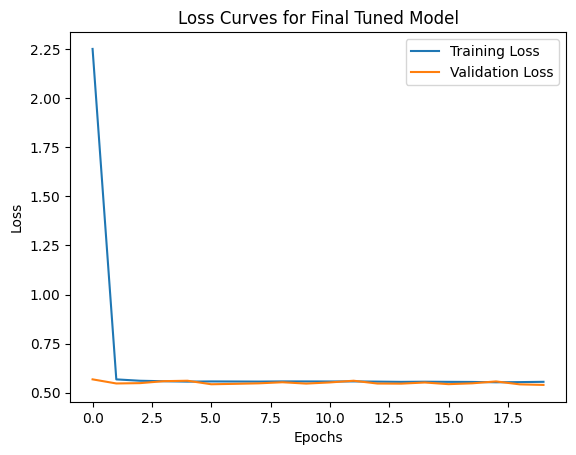

In [ ]:
#Create Model for best combination of hyperparameters
model_after_tuning = create_model(neurons=128, activation='tanh', optimizer='adam', kernel_regularizer=l1(0.001))
model_after_tuning.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_val, y_val))

#Plot loss curves for training and validation:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Curves for Final Tuned Model')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
#Evaluate the model after hyper parameter tuning on the test set
y_pred = model_after_tuning.predict(X_test).round()

# Performance metrics of the model after hyper parameter tuning on the test data
final_model_accuracy = accuracy_score(y_test, y_pred)
final_model_conf_matrix = confusion_matrix(y_test, y_pred)
final_model_precision = precision_score(y_test, y_pred)
final_model_recall = recall_score(y_test, y_pred)
final_model_auc_score = roc_auc_score(y_test, y_pred)

#Print the performance metrics:
print("Final model Accuracy:", final_model_accuracy)
print("Final model Confusion Matrix:\n", final_model_conf_matrix)
print("Final model Precision:", final_model_precision)
print("Final model Recall:", final_model_recall)
print("Final model AUC Score:", final_model_auc_score)

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Final model Accuracy: 0.8846767757382282
Final model Confusion Matrix:
 [[ 316  435]
 [ 143 4118]]
Final model Precision: 0.9044585987261147
Final model Recall: 0.9664398028631777
Final model AUC Score: 0.693606053229192


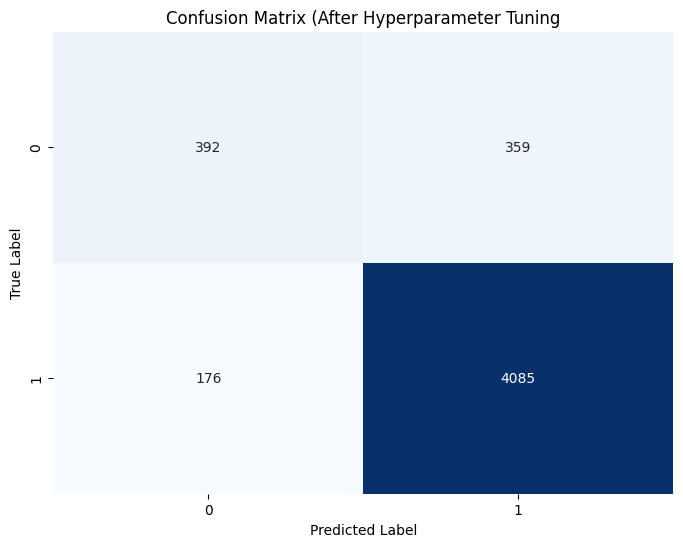

In [ ]:
def plot_confusion_matrix(final_model_conf_matrix, title="Confusion Matrix for the Final Model"):
    plt.figure(figsize=(8, 6))
    sns.heatmap(final_model_conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(title)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

# Plot confusion matrix before hyperparameter tuning
plot_confusion_matrix(final_model_conf_matrix, title="Confusion Matrix (After Hyperparameter Tuning")

### Comparison of performance metrics on the neural network model before and after hyperparameter Tuning:


Neural network modelling produced minimal improvement in the models predictive performance metrics compared with inital model

# Stage 2 data

Stage 2 Dataset includes all of the features from Stage 1 and two additional features:
- Authorised Absence Count
- UnAuthorised Absence Count



In [ ]:
# File URL
file_url_2 = "https://drive.google.com/uc?id=1vy1JFQZva3lhMJQV69C43AB1NTM4W-DZ"

In [ ]:
stg_2_data = pd.read_csv(file_url_2)
stg_2_data.head()

,CentreName,LearnerCode,BookingType,LeadSource,DiscountType,DateofBirth,Gender,Nationality,HomeState,HomeCity,CourseLevel,CourseName,IsFirstIntake,CompletedCourse,ProgressionDegree,ProgressionUniversity,AuthorisedAbsenceCount,UnauthorisedAbsenceCount
0,ISC_Aberdeen,2284932,Agent,Standard Agent Booking,NaN,13/01/1998,Male,Chinese,Jianye District; Jiangsu Province,Nanjing,Pre-Masters,Business and Law Pre-Masters,True,Yes,Msc Econ Accounting and Investment Management,University of Aberdeen,NaN,NaN
1,ISC_Aberdeen,2399500,Agent,Standard Agent Booking,NaN,12/2/1998,Male,Chinese,NaN,Xi'an,Foundation,Life Sciences Undergraduate Foundation Programme,False,Yes,BSc Biological Sciences,University of Aberdeen,93.0,5.0
2,ISC_Aberdeen,2424946,Agent,Standard Agent Booking,NaN,7/4/2000,Male,Chinese,NaN,Chengdu,International Year Two,Business Management and Finance International ...,False,Yes,MA Finance,University of Aberdeen,92.0,6.0
3,ISC_Aberdeen,2426583,Agent,Standard Agent Booking,NaN,18/05/1999,Male,Chinese,NaN,LIUYANG CITY ;CHANGSHA,International Year Two,Business Management and Finance International ...,True,Yes,MA Business Management,University of Aberdeen,67.0,15.0
4,ISC_Aberdeen,2434674,Agent,Standard Agent Booking,NaN,19/04/1996,Male,Chinese,NaN,Xiamen,Pre-Masters,Business and Law Pre-Masters,True,Yes,MSc International Business Management,University of Aberdeen,NaN,NaN


In [ ]:
stg_2_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25059 entries, 0 to 25058
Data columns (total 18 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   CentreName                25059 non-null  object 
 1   LearnerCode               25059 non-null  int64  
 2   BookingType               25059 non-null  object 
 3   LeadSource                25059 non-null  object 
 4   DiscountType              7595 non-null   object 
 5   DateofBirth               25059 non-null  object 
 6   Gender                    25059 non-null  object 
 7   Nationality               25059 non-null  object 
 8   HomeState                 8925 non-null   object 
 9   HomeCity                  21611 non-null  object 
 10  CourseLevel               25059 non-null  object 
 11  CourseName                25059 non-null  object 
 12  IsFirstIntake             25059 non-null  bool   
 13  CompletedCourse           25059 non-null  object 
 14  Progre

In [ ]:
#Unique Values for each Feature
n_unique_values= stg_2_data.nunique()
print("number of unique values for all features:\n", n_unique_values, end="\n\n")

number of unique values for all features:
 CentreName                     19
LearnerCode                 24877
BookingType                     2
LeadSource                      7
DiscountType                   11
DateofBirth                  4705
Gender                          2
Nationality                   151
HomeState                    2448
HomeCity                     5881
CourseLevel                     4
CourseName                    172
IsFirstIntake                   2
CompletedCourse                 2
ProgressionDegree            2616
ProgressionUniversity          40
AuthorisedAbsenceCount        190
UnauthorisedAbsenceCount      258
dtype: int64



In [ ]:
#features with more than 200 unique Values
Features_more_than_200_unique_values = n_unique_values[n_unique_values>200]
print("Features with more than 200 unique values:\n", Features_more_than_200_unique_values , end="\n")

Features with more than 200 unique values:
 LearnerCode                 24877
DateofBirth                  4705
HomeState                    2448
HomeCity                     5881
ProgressionDegree            2616
UnauthorisedAbsenceCount      258
dtype: int64


We will drop all features from Stage 1 and Unauthorised Absence which has more than 200 unique categories.

After cleaning and feature engineering the remaing feature 'Authorised Absence Count' stage 2 will be combined with our pre-processed features from stage 1 before splitting the dataset into training and testing

In [ ]:
#Drop all stage 1 data and UnauthorisedAbsenceCount Feature( which has more than 200 unique values)
stage_2_data = stg_2_data.drop(['CentreName','LearnerCode','BookingType','LeadSource','DiscountType','DateofBirth','Gender','Nationality','HomeState','HomeCity','CourseLevel','CourseName','IsFirstIntake','CompletedCourse','ProgressionDegree','ProgressionUniversity','UnauthorisedAbsenceCount'], axis=1)

In [ ]:
stage_2_data.head()

,AuthorisedAbsenceCount
0,NaN
1,93.0
2,92.0
3,67.0
4,NaN


In [ ]:
# Total number of rows
total_rows = 25059

# Total number of missing values for each column
missing_values = stage_2_data.isnull().sum()

print(missing_values)

AuthorisedAbsenceCount    208
dtype: int64


There is 208 missing values, before imputing the distribution of the Authorised Absence Count was reviewed.

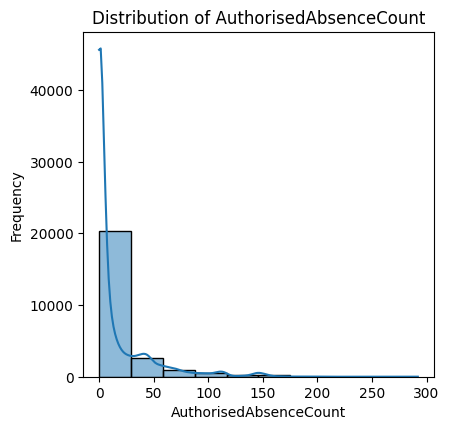

In [ ]:
#Distribution of the features in Stage 2 Dataset:
plt.figure(figsize=(12, 8))
for i, column in enumerate(stage_2_data.columns, 1):
    plt.subplot(2, 3, i)
    sns.histplot(stage_2_data[column], kde=True, bins=10)
    plt.title(f'Distribution of {column}')
    plt.xlabel(column)
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

The distribution of the feature is extremely skewed and so the mode was utilised to impute the missing values in the feature

In [ ]:
#imputation of missing values:
#mode impute
mode_imputer = SimpleImputer(strategy='most_frequent')
stage_2_data[['AuthorisedAbsenceCount']] = mode_imputer.fit_transform(stage_2_data[['AuthorisedAbsenceCount']])

In [ ]:
stage_2_data.head()


,AuthorisedAbsenceCount
0,0.0
1,93.0
2,92.0
3,67.0
4,0.0


In [ ]:
# Combine Encoded Stage 1 Data and Stage 2 Data
combined_stage_1_and_2_data = pd.concat([final_encoded_df, stage_2_data], axis=1)

#Display Output
combined_stage_1_and_2_data.head()

,CourseLevel,CompletedCourse,IsFirstIntake,Age,Gender,Nationality_(Not known),Nationality_Afghan,Nationality_Albanian,Nationality_Algerian,Nationality_American,...,Booking_LeadSource_Agent - APD,Booking_LeadSource_Agent - Sponsor,Booking_LeadSource_Agent - Standard Agent Booking,Booking_LeadSource_Direct - APD,Booking_LeadSource_Direct - Digital (Web),Booking_LeadSource_Direct - Re-enrolment,Booking_LeadSource_Direct - Referrals,Booking_LeadSource_Direct - Sponsor,Booking_LeadSource_Direct - Walk-in,AuthorisedAbsenceCount
0,3.0,1.0,1.0,27.120548,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,1.0,0.0,27.038356,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,93.0
2,2.0,1.0,0.0,24.887671,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,92.0
3,2.0,1.0,1.0,25.778082,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,67.0
4,3.0,1.0,1.0,28.857534,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Data Splitting for Stage 2 Model training and testing

Similar to Stage 1 80-20% training testing split was used.

The features used in the training were all the features used in stage 1 modelling with the addition of 'Authorised Absence Count' from stage 2

The target variable remained as 'CompletedCourse' and was stratified to reduce impact of the outcomes in the target varibale being imbalanced.

The features summarised are:
'Course Level', 'Completed
Course', 'IsFirstIntake', 'Age', 'Gender', 'Nationality', 'Course Name', 'Centre_University',
'Booking_LeadSource' & 'Authorised Absence Count'

In [ ]:
#Data Splitting and Training:
# Split the data into features (X) and the target variable (y)
X2 = combined_stage_1_and_2_data.drop('CompletedCourse', axis=1)
y2 = combined_stage_1_and_2_data['CompletedCourse']

#Train Test Split
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X2, y2, test_size=0.2, random_state=42,stratify=y2)
X_train_2,X_val_2,y_train_2,y_val_2 = train_test_split(X_train_2,y_train_2,test_size=0.2,random_state=42, stratify=y_train_2)

#view output
print("X_train shape:", X_train_2.shape)
print("X_test shape:", X_test_2.shape)

X_train shape: (16037, 379)
X_test shape: (5012, 379)


## XGBoost Model training and testing

The initial models and hyperparameters from previous stages were used as starting points
for training and testing Stage 2 and Stage 3 Datasets.
Hyperparameter tuning was conducted similarly, and the best combination (based on the
highest validation AUC) was selected to build the final model.
Performance metrics were recorded for the initial & final models for the model

Initial Model Accuracy: 0.8974461292897047
Initial Model AUC Score: 0.7471846190528721
Initial Model Classification Report:
              precision    recall  f1-score   support

         0.0       0.71      0.53      0.61       751
         1.0       0.92      0.96      0.94      4261

    accuracy                           0.90      5012
   macro avg       0.82      0.75      0.77      5012
weighted avg       0.89      0.90      0.89      5012



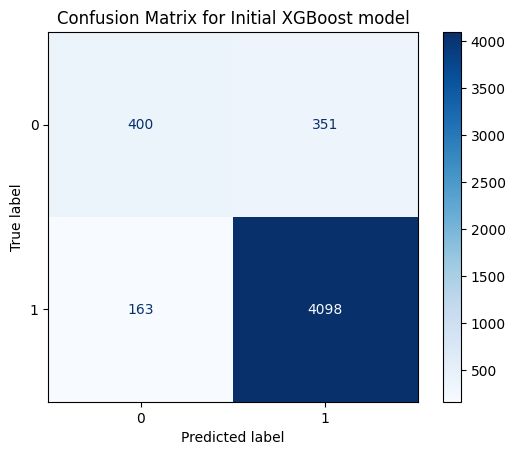

In [ ]:
import xgboost as xgb
initial_xg_model = xgb.XGBClassifier(random_state=42, alpha= 0.5, learning_rate=0.1, max_depth= 5, n_estimators=200) #used best parameters from the stage 1 model
initial_xg_model.fit(X_train_2, y_train_2)

#Model Evaluation metrics
y_pred = initial_xg_model.predict(X_test_2)
accuracy = accuracy_score(y_test_2, y_pred)
classification_rep = classification_report(y_test_2, y_pred)
auc_score = roc_auc_score(y_test_2, y_pred)

# View output
print(f"Initial Model Accuracy: {accuracy}")
print(f"Initial Model AUC Score: {auc_score}")
print("Initial Model Classification Report:")
print(classification_rep)

#plot confusion matrix
conf_matrix_Initial = confusion_matrix(y_test_2, y_pred)
Initial_conf_matrix = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_Initial, display_labels=initial_xg_model.classes_)
Initial_conf_matrix.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix for Initial XGBoost model")
plt.show()


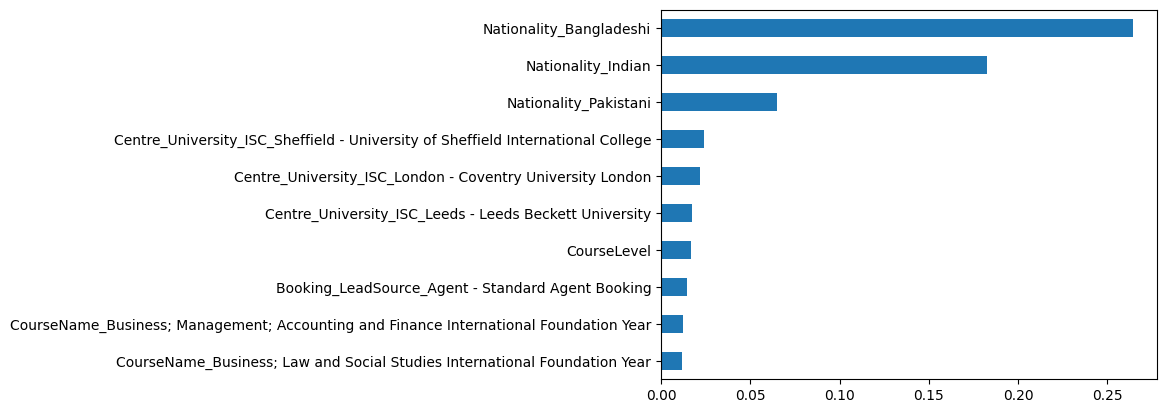

In [ ]:
# Convert x_train_2 which is a numpy array into a data frame
x_train_2_df = pd.DataFrame(X_train_2, columns=X_train_2.columns)

#feature importance
feature_importance = pd.Series(initial_xg_model.feature_importances_,index=x_train_2_df.columns).sort_values()

feature_importance.iloc[-10:].plot.barh()
plt.show()

In [ ]:
from sklearn.model_selection import GridSearchCV

hyperparameter_tuning = {
    'alpha': [0.1, 0.3, 0.5],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [50, 100,200]
}

#GridSearchCV
grid_search = GridSearchCV(estimator=initial_xg_model, param_grid=hyperparameter_tuning, cv=5, scoring='roc_auc', verbose=1)
grid_search.fit(X_train_2, y_train_2)

#Output for the best Hyperparameter combination with regards to AUC
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best AUC score: {grid_search.best_score_}")

Fitting 5 folds for each of 81 candidates, totalling 405 fits


KeyboardInterrupt: 

Final Model Accuracy: 0.8988427773343974
Final Model AUC Score: 0.7501997649383081
Final Model Classification Report:
              precision    recall  f1-score   support

         0.0       0.72      0.54      0.61       751
         1.0       0.92      0.96      0.94      4261

    accuracy                           0.90      5012
   macro avg       0.82      0.75      0.78      5012
weighted avg       0.89      0.90      0.89      5012



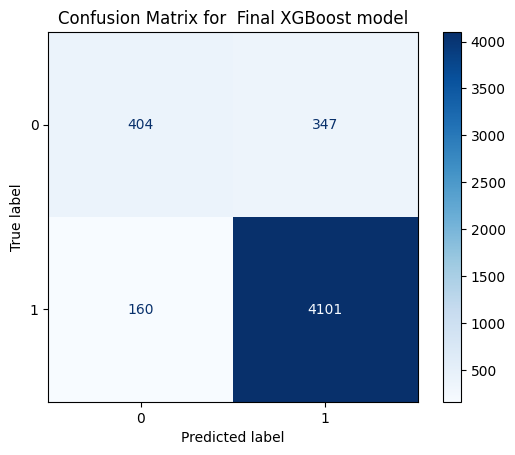

In [ ]:
#Test the hyperparameter combination selectef from the tuning
final_xg_model = xgb.XGBClassifier(random_state=42, alpha= 0.1, learning_rate=0.1, max_depth= 5, n_estimators=200)
final_xg_model.fit(X_train_2, y_train_2)

#Model Evaluation metrics
y_pred = final_xg_model.predict(X_test_2)
accuracy = accuracy_score(y_test_2, y_pred)
classification_rep = classification_report(y_test_2, y_pred)
auc_score = roc_auc_score(y_test_2, y_pred)

# View output
print(f"Final Model Accuracy: {accuracy}")
print(f"Final Model AUC Score: {auc_score}")
print("Final Model Classification Report:")
print(classification_rep)

#plot confusion matrix
conf_matrix_final = confusion_matrix(y_test_2, y_pred)
Initial_conf_matrix = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_final, display_labels=final_xg_model .classes_)
Initial_conf_matrix.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix for  Final XGBoost model")
plt.show()

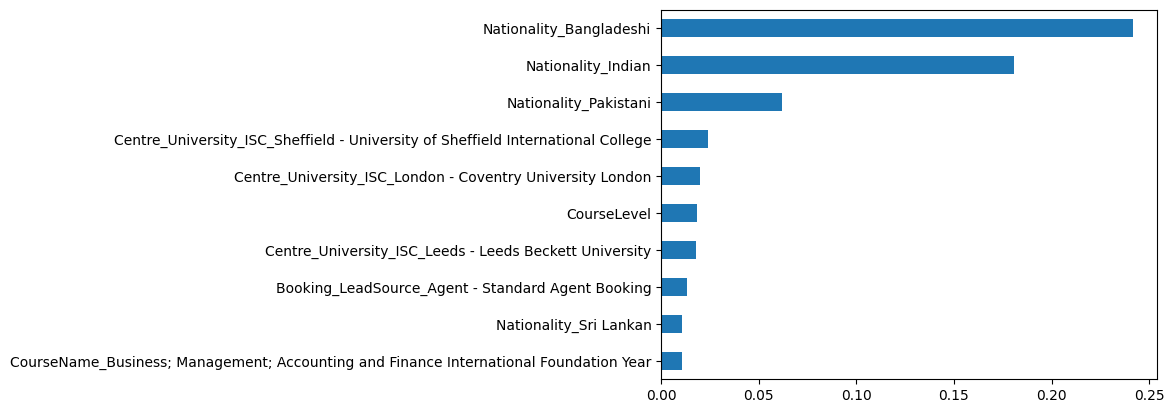

In [ ]:
# Convert x_train_2 which is a numpy array into a data frame
x_train_2_df = pd.DataFrame(X_train_2, columns=X_train_2.columns)

#feature importance
feature_importance = pd.Series(final_xg_model.feature_importances_,index=x_train_2_df.columns).sort_values()

feature_importance.iloc[-10:].plot.barh()
plt.show()

Again minimal improvement in the models predictive performance metrics after hyper parameter tunining between initial and final. There is also not much increase between final model in stage 1 performance metrics and the final model in stage 2.

The feature importance doesnot show any representation from the additional feature from Stage 2 'Authorised Absence Count'.

This may suggest stage 2 data didnot do anything to improve model performance

## Neural Network Modelling for Stage 2 Data Set:

 The initial models and hyperparameters from previous stages were used as starting points
for training and testing the Stage 2 and Stage 3 models respectively.
• Hyperparameter tuning was conducted for both stages, with the best combinations selected
based on the highest validation AUC.
• Performance metrics were recorded for both the initial and final models in each stage.

In [ ]:
#Scaling using standard Scaler:
scaler = StandardScaler()
X_train_2 = scaler.fit_transform(X_train_2)
X_test_2 = scaler.transform(X_test_2)
X_val_2= scaler.transform(X_val_2)


In [ ]:
#Create Function for the model for stage 2 Dataset
def create_model(neurons=128, activation='tanh', optimizer='adam', kernel_regularizer=l1(0.001)): #will run initial model with best parameters from stage 1 hyperparameter tuning
    model = Sequential()
    model.add(Dense(units=neurons, activation=activation, input_shape=(X_train_2.shape[1],),kernel_regularizer=kernel_regularizer))
    model.add(Dense(units=neurons//2, activation=activation))
    model.add(Dense(1, activation='sigmoid'))


  #Compile Model
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy', 'Precision', 'Recall', 'AUC',])
    return model

Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


502/502 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - AUC: 0.8129 - Precision: 0.9193 - Recall: 0.8703 - accuracy: 0.8246 - loss: 1.4616 - val_AUC: 0.8848 - val_Precision: 0.9051 - val_Recall: 0.9654 - val_accuracy: 0.8845 - val_loss: 0.3804
Epoch 2/20
502/502 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.8777 - Precision: 0.9160 - Recall: 0.9597 - accuracy: 0.8912 - loss: 0.3582 - val_AUC: 0.8875 - val_Precision: 0.9133 - val_Recall: 0.9677 - val_accuracy: 0.8945 - val_loss: 0.3266
Epoch 3/20
502/502 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.8845 - Precision: 0.9210 - Recall: 0.9563 - accuracy: 0.8933 - loss: 0.3196 - val_AUC: 0.8924 - val_Precision: 0.9283 - val_Recall: 0.9498 - val_accuracy: 0.8950 - val_loss: 0.3037
Epoch 4/20
502/502 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - AUC: 0.8893 - Precision: 0.9230 - Recall: 0.9513 - accuracy: 0.8914 - loss: 0.3052 - val_AUC: 0.8903 - val_Precision: 0.9208 - val_Recall: 0.9545 - val_accuracy: 0.8915 - val_loss: 0.3049
Epoch 5/20
502/502 ━━━━━━━━━━━━━━━━━━━━ 4s 

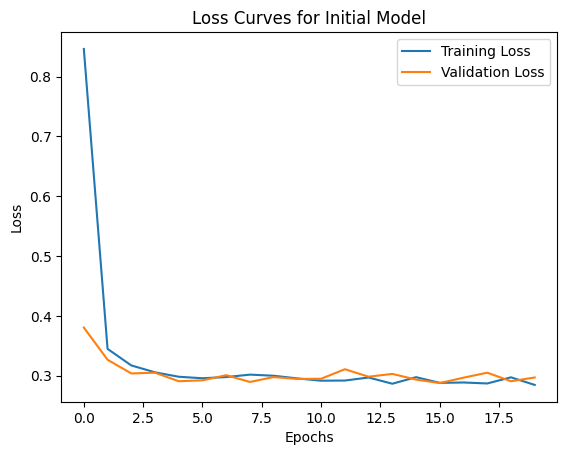

In [ ]:
#Instantiate the initial model
model_2= create_model()
history = model_2.fit(X_train_2, y_train_2, epochs=20, batch_size=32, validation_data=(X_val_2, y_val_2))

#Plot loss curves for training and validation:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Curves for Initial Model')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
#Evaluate the initial model on the test set
y_pred = model_2.predict(X_test_2).round()

# Performance metrics of the initial model on the test data
initial_model_2_accuracy = accuracy_score(y_test_2, y_pred)
initial_model_2_conf_matrix = confusion_matrix(y_test_2, y_pred)
initial_model_2_precision = precision_score(y_test_2, y_pred)
initial_model_2_recall = recall_score(y_test_2, y_pred)
initial_model_2_auc_score = roc_auc_score(y_test_2, y_pred)

#Print the performance metrics:
print("Initial model 2 Accuracy:", initial_model_2_accuracy )
print("Initial model 2 Confusion Matrix:\n",initial_model_2_conf_matrix)
print("Initial model 2 Precision:", initial_model_2_precision)
print("Initial model 2 Recall:", initial_model_2_recall)
print("Initial model 2 AUC Score:", initial_model_2_auc_score)

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Initial model 2 Accuracy: 0.890462889066241
Initial model 2 Confusion Matrix:
 [[ 310  441]
 [ 108 4153]]
Initial model 2 Precision: 0.9040052242054855
Initial model 2 Recall: 0.9746538371274349
Initial model 2 AUC Score: 0.6937183965930117


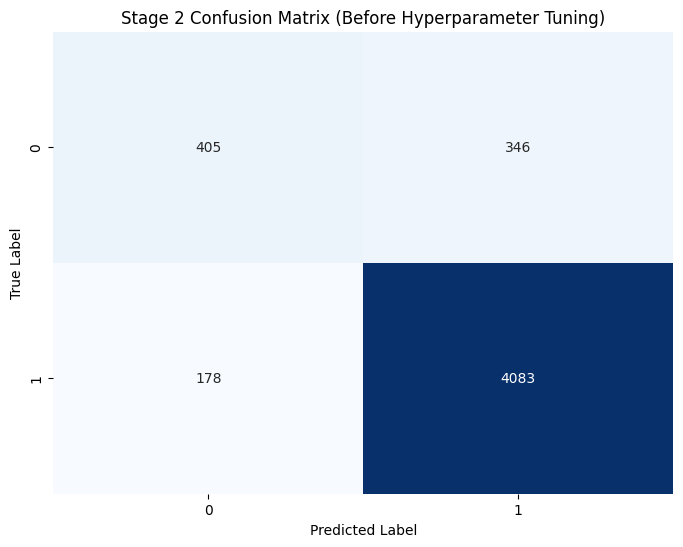

In [ ]:
def plot_confusion_matrix(initial_model_2_conf_matrix, title="Confusion Matrix"):
    plt.figure(figsize=(8, 6))
    sns.heatmap(initial_model_conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(title)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

# Plot confusion matrix before hyperparameter tuning
plot_confusion_matrix(initial_model_2_conf_matrix, title="Stage 2 Confusion Matrix (Before Hyperparameter Tuning)")


In [ ]:
from keras.optimizers import Adam, RMSprop
from keras.models import Sequential
from keras.layers import Dense
from keras import regularizers
import numpy as np
import matplotlib.pyplot as plt

#Results dictionary:
results = {}

# Hyperparameter tuning
neurons = [32, 64, 128]
activations = ['relu', 'tanh']
regularizers = [regularizers.l1(0.001),regularizers.l1(0.01)]
optimizers = ['adam', 'rmsprop']

#Loop for each Vector:
for neuron in neurons:
    for activation in activations:
        for optimizer in optimizers:
            for regularizer in regularizers:
                print(f"Training with {neuron} neurons, {activation} activation, {optimizer} optimizer, {regularizer} regularizer")
                model = create_model(neurons=neuron, activation=activation, optimizer=optimizer, kernel_regularizer=regularizer)
                history = model.fit(X_train_2, y_train_2, epochs=20, batch_size=32, validation_data=(X_val_2, y_val_2))
                val_AUC = history.history['val_AUC'][-1]
                results[(neuron, activation, optimizer, regularizer)] = val_AUC

# Output for the hyperparameter combination with highest Val_AUC
best_params = max(results, key=results.get)
best_val_auc = results[best_params]
print(f"Best combination: {best_params} with validation AUC: {best_val_auc}")

Training with 32 neurons, relu activation, adam optimizer, <keras.src.regularizers.regularizers.L1 object at 0x7e8b66dd7250> regularizer
Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


502/502 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - AUC: 0.7567 - Precision: 0.8581 - Recall: 0.9965 - accuracy: 0.8569 - loss: 0.5876 - val_AUC: 0.8757 - val_Precision: 0.8872 - val_Recall: 0.9894 - val_accuracy: 0.8840 - val_loss: 0.3195
Epoch 2/20
502/502 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8740 - Precision: 0.9118 - Recall: 0.9678 - accuracy: 0.8929 - loss: 0.3049 - val_AUC: 0.8898 - val_Precision: 0.9323 - val_Recall: 0.9454 - val_accuracy: 0.8953 - val_loss: 0.2983
Epoch 3/20
502/502 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - AUC: 0.8794 - Precision: 0.9209 - Recall: 0.9660 - accuracy: 0.9005 - loss: 0.2939 - val_AUC: 0.8922 - val_Precision: 0.9225 - val_Recall: 0.9633 - val_accuracy: 0.9000 - val_loss: 0.2832
Epoch 4/20
502/502 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - AUC: 0.8819 - Precision: 0.9187 - Recall: 0.9678 - accuracy: 0.8991 - loss: 0.2864 - val_AUC: 0.8909 - val_Precision: 0.9351 - val_Recall: 0.9422 - val_accuracy: 0.8953 - val_loss: 0.2907
Epoch 5/20
502/502 ━━━━━━━━━━━━━━━━━━━━ 2s 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


502/502 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - AUC: 0.6839 - Precision: 0.8540 - Recall: 0.9318 - accuracy: 0.8083 - loss: 2.4320 - val_AUC: 0.7593 - val_Precision: 0.8501 - val_Recall: 1.0000 - val_accuracy: 0.8501 - val_loss: 0.4168
Epoch 2/20
502/502 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.7711 - Precision: 0.8462 - Recall: 0.9999 - accuracy: 0.8462 - loss: 0.4152 - val_AUC: 0.8496 - val_Precision: 0.8756 - val_Recall: 0.9930 - val_accuracy: 0.8741 - val_loss: 0.3624
Epoch 3/20
502/502 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.8495 - Precision: 0.8818 - Recall: 0.9859 - accuracy: 0.8754 - loss: 0.3566 - val_AUC: 0.8690 - val_Precision: 0.9211 - val_Recall: 0.9554 - val_accuracy: 0.8925 - val_loss: 0.3421
Epoch 4/20
502/502 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - AUC: 0.8583 - Precision: 0.9069 - Recall: 0.9638 - accuracy: 0.8850 - loss: 0.3380 - val_AUC: 0.8783 - val_Precision: 0.9171 - val_Recall: 0.9601 - val_accuracy: 0.8923 - val_loss: 0.3213
Epoch 5/20
502/502 ━━━━━━━━━━━━━━━━━━━━ 5s 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


502/502 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - AUC: 0.8110 - Precision: 0.8705 - Recall: 0.9906 - accuracy: 0.8661 - loss: 0.5441 - val_AUC: 0.8819 - val_Precision: 0.9004 - val_Recall: 0.9806 - val_accuracy: 0.8913 - val_loss: 0.3144
Epoch 2/20
502/502 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8785 - Precision: 0.9183 - Recall: 0.9660 - accuracy: 0.8979 - loss: 0.3059 - val_AUC: 0.8885 - val_Precision: 0.8811 - val_Recall: 0.9912 - val_accuracy: 0.8788 - val_loss: 0.3134
Epoch 3/20
502/502 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - AUC: 0.8766 - Precision: 0.9171 - Recall: 0.9665 - accuracy: 0.8971 - loss: 0.3023 - val_AUC: 0.8870 - val_Precision: 0.9401 - val_Recall: 0.9343 - val_accuracy: 0.8935 - val_loss: 0.3086
Epoch 4/20
502/502 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.8840 - Precision: 0.9219 - Recall: 0.9616 - accuracy: 0.8980 - loss: 0.2959 - val_AUC: 0.8907 - val_Precision: 0.9430 - val_Recall: 0.9273 - val_accuracy: 0.8905 - val_loss: 0.3081
Epoch 5/20
502/502 ━━━━━━━━━━━━━━━━━━━━ 2s 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


502/502 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - AUC: 0.6474 - Precision: 0.8414 - Recall: 0.9234 - accuracy: 0.7971 - loss: 2.2243 - val_AUC: 0.7845 - val_Precision: 0.8501 - val_Recall: 1.0000 - val_accuracy: 0.8501 - val_loss: 0.4722
Epoch 2/20
502/502 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.8020 - Precision: 0.8586 - Recall: 0.9980 - accuracy: 0.8579 - loss: 0.4443 - val_AUC: 0.8691 - val_Precision: 0.8944 - val_Recall: 0.9742 - val_accuracy: 0.8803 - val_loss: 0.4428
Epoch 3/20
502/502 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.8447 - Precision: 0.8822 - Recall: 0.9808 - accuracy: 0.8725 - loss: 0.4235 - val_AUC: 0.8748 - val_Precision: 0.8937 - val_Recall: 0.9789 - val_accuracy: 0.8830 - val_loss: 0.3941
Epoch 4/20
502/502 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8605 - Precision: 0.8993 - Recall: 0.9712 - accuracy: 0.8834 - loss: 0.4019 - val_AUC: 0.8799 - val_Precision: 0.8794 - val_Recall: 0.9921 - val_accuracy: 0.8776 - val_loss: 0.3930
Epoch 5/20
502/502 ━━━━━━━━━━━━━━━━━━━━ 3s 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


502/502 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - AUC: 0.7459 - Precision: 0.8683 - Recall: 0.9838 - accuracy: 0.8587 - loss: 0.5753 - val_AUC: 0.8876 - val_Precision: 0.9468 - val_Recall: 0.9185 - val_accuracy: 0.8868 - val_loss: 0.3191
Epoch 2/20
502/502 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8745 - Precision: 0.9179 - Recall: 0.9591 - accuracy: 0.8927 - loss: 0.3020 - val_AUC: 0.8851 - val_Precision: 0.9001 - val_Recall: 0.9806 - val_accuracy: 0.8910 - val_loss: 0.2885
Epoch 3/20
502/502 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8843 - Precision: 0.9194 - Recall: 0.9638 - accuracy: 0.8977 - loss: 0.2877 - val_AUC: 0.8948 - val_Precision: 0.8991 - val_Recall: 0.9824 - val_accuracy: 0.8913 - val_loss: 0.2861
Epoch 4/20
502/502 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8752 - Precision: 0.9152 - Recall: 0.9659 - accuracy: 0.8950 - loss: 0.2932 - val_AUC: 0.8953 - val_Precision: 0.9395 - val_Recall: 0.9378 - val_accuracy: 0.8958 - val_loss: 0.2848
Epoch 5/20
502/502 ━━━━━━━━━━━━━━━━━━━━ 3s 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
502/502 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - AUC: 0.6778 - Precision: 0.8605 - Recall: 0.8904 - accuracy: 0.7802 - loss: 2.4514 - val_AUC: 0.8572 - val_Precision: 0.8541 - val_Recall: 0.9997 - val_accuracy: 0.8546 - val_loss: 0.3673
Epoch 2/20
502/502 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.8510 - Precision: 0.8824 - Recall: 0.9806 - accuracy: 0.8727 - loss: 0.3622 - val_AUC: 0.8839 - val_Precision: 0.9157 - val_Recall: 0.9595 - val_accuracy: 0.8905 - val_loss: 0.3232
Epoch 3/20
502/502 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.8762 - Precision: 0.9095 - Recall: 0.9625 - accuracy: 0.8870 - loss: 0.3276 - val_AUC: 0.8805 - val_Precision: 0.9279 - val_Recall: 0.9516 - val_accuracy: 0.8960 - val_loss: 0.3166
Epoch 4/20
502/502 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.8727 - Precision: 0.9159 - Recall: 0.9601 - accuracy: 0.8910 - loss: 0.3193 - val_AUC: 0.8889 - val_Precision: 0.9393 - val_Recall: 0.9346 - val_accuracy: 0.8930 - val_loss: 0.3121
Epoch 5/20
502/502 ━━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


502/502 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - AUC: 0.7714 - Precision: 0.8654 - Recall: 0.9930 - accuracy: 0.8625 - loss: 0.5521 - val_AUC: 0.8855 - val_Precision: 0.9096 - val_Recall: 0.9739 - val_accuracy: 0.8955 - val_loss: 0.2941
Epoch 2/20
502/502 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8708 - Precision: 0.9117 - Recall: 0.9623 - accuracy: 0.8890 - loss: 0.3054 - val_AUC: 0.8830 - val_Precision: 0.8667 - val_Recall: 0.9974 - val_accuracy: 0.8673 - val_loss: 0.3435
Epoch 3/20
502/502 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.8851 - Precision: 0.9209 - Recall: 0.9652 - accuracy: 0.8999 - loss: 0.2886 - val_AUC: 0.8935 - val_Precision: 0.8996 - val_Recall: 0.9803 - val_accuracy: 0.8903 - val_loss: 0.2876
Epoch 4/20
502/502 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.8742 - Precision: 0.9176 - Recall: 0.9619 - accuracy: 0.8941 - loss: 0.2936 - val_AUC: 0.8908 - val_Precision: 0.9043 - val_Recall: 0.9759 - val_accuracy: 0.8918 - val_loss: 0.2852
Epoch 5/20
502/502 ━━━━━━━━━━━━━━━━━━━━ 2s 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
502/502 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - AUC: 0.6440 - Precision: 0.8421 - Recall: 0.9229 - accuracy: 0.7985 - loss: 2.1769 - val_AUC: 0.8528 - val_Precision: 0.8547 - val_Recall: 0.9994 - val_accuracy: 0.8551 - val_loss: 0.4162
Epoch 2/20
502/502 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8527 - Precision: 0.8894 - Recall: 0.9767 - accuracy: 0.8770 - loss: 0.3979 - val_AUC: 0.8839 - val_Precision: 0.9310 - val_Recall: 0.9457 - val_accuracy: 0.8943 - val_loss: 0.3736
Epoch 3/20
502/502 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8647 - Precision: 0.9161 - Recall: 0.9634 - accuracy: 0.8934 - loss: 0.3720 - val_AUC: 0.8888 - val_Precision: 0.9488 - val_Recall: 0.9135 - val_accuracy: 0.8845 - val_loss: 0.3947
Epoch 4/20
502/502 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8739 - Precision: 0.9155 - Recall: 0.9624 - accuracy: 0.8928 - loss: 0.3688 - val_AUC: 0.8866 - val_Precision: 0.9501 - val_Recall: 0.9158 - val_accuracy: 0.8875 - val_loss: 0.3909
Epoch 5/20
502/502 ━━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


502/502 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - AUC: 0.7925 - Precision: 0.8694 - Recall: 0.9938 - accuracy: 0.8667 - loss: 0.7406 - val_AUC: 0.8842 - val_Precision: 0.9060 - val_Recall: 0.9730 - val_accuracy: 0.8913 - val_loss: 0.3103
Epoch 2/20
502/502 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8783 - Precision: 0.9123 - Recall: 0.9650 - accuracy: 0.8912 - loss: 0.3111 - val_AUC: 0.8898 - val_Precision: 0.9221 - val_Recall: 0.9625 - val_accuracy: 0.8990 - val_loss: 0.2968
Epoch 3/20
502/502 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - AUC: 0.8697 - Precision: 0.9167 - Recall: 0.9643 - accuracy: 0.8951 - loss: 0.3098 - val_AUC: 0.8901 - val_Precision: 0.9114 - val_Recall: 0.9718 - val_accuracy: 0.8958 - val_loss: 0.2946
Epoch 4/20
502/502 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8834 - Precision: 0.9214 - Recall: 0.9637 - accuracy: 0.8995 - loss: 0.2962 - val_AUC: 0.8930 - val_Precision: 0.9240 - val_Recall: 0.9595 - val_accuracy: 0.8985 - val_loss: 0.2870
Epoch 5/20
502/502 ━━━━━━━━━━━━━━━━━━━━ 3s 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


502/502 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - AUC: 0.6371 - Precision: 0.8544 - Recall: 0.9607 - accuracy: 0.8262 - loss: 4.1561 - val_AUC: 0.6918 - val_Precision: 0.8501 - val_Recall: 1.0000 - val_accuracy: 0.8501 - val_loss: 0.4484
Epoch 2/20
502/502 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - AUC: 0.7331 - Precision: 0.8481 - Recall: 0.9997 - accuracy: 0.8480 - loss: 0.4364 - val_AUC: 0.8528 - val_Precision: 0.8828 - val_Recall: 0.9900 - val_accuracy: 0.8798 - val_loss: 0.3718
Epoch 3/20
502/502 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.8593 - Precision: 0.8912 - Recall: 0.9805 - accuracy: 0.8811 - loss: 0.3581 - val_AUC: 0.8795 - val_Precision: 0.9133 - val_Recall: 0.9674 - val_accuracy: 0.8943 - val_loss: 0.3382
Epoch 4/20
502/502 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.8637 - Precision: 0.9073 - Recall: 0.9677 - accuracy: 0.8881 - loss: 0.3433 - val_AUC: 0.8842 - val_Precision: 0.9135 - val_Recall: 0.9660 - val_accuracy: 0.8933 - val_loss: 0.3289
Epoch 5/20
502/502 ━━━━━━━━━━━━━━━━━━━━ 3s 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


502/502 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - AUC: 0.8117 - Precision: 0.8714 - Recall: 0.9870 - accuracy: 0.8650 - loss: 0.7193 - val_AUC: 0.8814 - val_Precision: 0.9319 - val_Recall: 0.9469 - val_accuracy: 0.8960 - val_loss: 0.3248
Epoch 2/20
502/502 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.8614 - Precision: 0.9142 - Recall: 0.9644 - accuracy: 0.8927 - loss: 0.3276 - val_AUC: 0.8828 - val_Precision: 0.8945 - val_Recall: 0.9853 - val_accuracy: 0.8888 - val_loss: 0.3226
Epoch 3/20
502/502 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - AUC: 0.8716 - Precision: 0.9169 - Recall: 0.9612 - accuracy: 0.8929 - loss: 0.3145 - val_AUC: 0.8899 - val_Precision: 0.9295 - val_Recall: 0.9513 - val_accuracy: 0.8973 - val_loss: 0.2996
Epoch 4/20
502/502 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.8805 - Precision: 0.9167 - Recall: 0.9596 - accuracy: 0.8919 - loss: 0.3095 - val_AUC: 0.8873 - val_Precision: 0.8644 - val_Recall: 0.9982 - val_accuracy: 0.8653 - val_loss: 0.3552
Epoch 5/20
502/502 ━━━━━━━━━━━━━━━━━━━━ 2s 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


502/502 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - AUC: 0.6525 - Precision: 0.8552 - Recall: 0.9609 - accuracy: 0.8263 - loss: 3.5864 - val_AUC: 0.7214 - val_Precision: 0.8501 - val_Recall: 1.0000 - val_accuracy: 0.8501 - val_loss: 0.5311
Epoch 2/20
502/502 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - AUC: 0.7575 - Precision: 0.8498 - Recall: 0.9992 - accuracy: 0.8495 - loss: 0.5188 - val_AUC: 0.8552 - val_Precision: 0.9179 - val_Recall: 0.9604 - val_accuracy: 0.8933 - val_loss: 0.4828
Epoch 3/20
502/502 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - AUC: 0.8570 - Precision: 0.8937 - Recall: 0.9770 - accuracy: 0.8819 - loss: 0.4583 - val_AUC: 0.8744 - val_Precision: 0.9335 - val_Recall: 0.9396 - val_accuracy: 0.8918 - val_loss: 0.4578
Epoch 4/20
502/502 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.8643 - Precision: 0.9110 - Recall: 0.9664 - accuracy: 0.8910 - loss: 0.4389 - val_AUC: 0.8754 - val_Precision: 0.9569 - val_Recall: 0.8853 - val_accuracy: 0.8686 - val_loss: 0.5469
Epoch 5/20
502/502 ━━━━━━━━━━━━━━━━━━━━ 2

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


502/502 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - AUC: 0.7638 - Precision: 0.8674 - Recall: 0.9832 - accuracy: 0.8580 - loss: 0.7538 - val_AUC: 0.8849 - val_Precision: 0.8928 - val_Recall: 0.9845 - val_accuracy: 0.8863 - val_loss: 0.3133
Epoch 2/20
502/502 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - AUC: 0.8709 - Precision: 0.9174 - Recall: 0.9642 - accuracy: 0.8959 - loss: 0.3046 - val_AUC: 0.8893 - val_Precision: 0.9093 - val_Recall: 0.9707 - val_accuracy: 0.8928 - val_loss: 0.2852
Epoch 3/20
502/502 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.8794 - Precision: 0.9210 - Recall: 0.9638 - accuracy: 0.8991 - loss: 0.2916 - val_AUC: 0.8936 - val_Precision: 0.9254 - val_Recall: 0.9539 - val_accuracy: 0.8955 - val_loss: 0.2788
Epoch 4/20
502/502 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.8791 - Precision: 0.9201 - Recall: 0.9624 - accuracy: 0.8973 - loss: 0.2899 - val_AUC: 0.8948 - val_Precision: 0.9291 - val_Recall: 0.9566 - val_accuracy: 0.9010 - val_loss: 0.2772
Epoch 5/20
502/502 ━━━━━━━━━━━━━━━━━━━━ 2s 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


502/502 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - AUC: 0.6987 - Precision: 0.8541 - Recall: 0.9987 - accuracy: 0.8536 - loss: 4.0767 - val_AUC: 0.8752 - val_Precision: 0.8948 - val_Recall: 0.9801 - val_accuracy: 0.8850 - val_loss: 0.3524
Epoch 2/20
502/502 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.8613 - Precision: 0.9046 - Recall: 0.9685 - accuracy: 0.8864 - loss: 0.3583 - val_AUC: 0.8859 - val_Precision: 0.9343 - val_Recall: 0.9422 - val_accuracy: 0.8945 - val_loss: 0.3409
Epoch 3/20
502/502 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - AUC: 0.8757 - Precision: 0.9179 - Recall: 0.9603 - accuracy: 0.8934 - loss: 0.3382 - val_AUC: 0.8820 - val_Precision: 0.9183 - val_Recall: 0.9660 - val_accuracy: 0.8980 - val_loss: 0.3256
Epoch 4/20
502/502 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - AUC: 0.8714 - Precision: 0.9176 - Recall: 0.9615 - accuracy: 0.8935 - loss: 0.3324 - val_AUC: 0.8871 - val_Precision: 0.9381 - val_Recall: 0.9337 - val_accuracy: 0.8913 - val_loss: 0.3375
Epoch 5/20
502/502 ━━━━━━━━━━━━━━━━━━━━ 3s 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


502/502 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - AUC: 0.8052 - Precision: 0.8719 - Recall: 0.9869 - accuracy: 0.8652 - loss: 0.7023 - val_AUC: 0.8865 - val_Precision: 0.9280 - val_Recall: 0.9534 - val_accuracy: 0.8975 - val_loss: 0.3101
Epoch 2/20
502/502 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.8732 - Precision: 0.9165 - Recall: 0.9629 - accuracy: 0.8940 - loss: 0.3134 - val_AUC: 0.8886 - val_Precision: 0.9135 - val_Recall: 0.9724 - val_accuracy: 0.8983 - val_loss: 0.2981
Epoch 3/20
502/502 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - AUC: 0.8759 - Precision: 0.9173 - Recall: 0.9629 - accuracy: 0.8947 - loss: 0.3067 - val_AUC: 0.8870 - val_Precision: 0.9194 - val_Recall: 0.9642 - val_accuracy: 0.8978 - val_loss: 0.2951
Epoch 4/20
502/502 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.8791 - Precision: 0.9196 - Recall: 0.9641 - accuracy: 0.8977 - loss: 0.3016 - val_AUC: 0.8904 - val_Precision: 0.9132 - val_Recall: 0.9715 - val_accuracy: 0.8973 - val_loss: 0.2973
Epoch 5/20
502/502 ━━━━━━━━━━━━━━━━━━━━ 2s 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


502/502 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - AUC: 0.6989 - Precision: 0.8502 - Recall: 0.9996 - accuracy: 0.8501 - loss: 3.5236 - val_AUC: 0.8645 - val_Precision: 0.8693 - val_Recall: 0.9953 - val_accuracy: 0.8688 - val_loss: 0.4574
Epoch 2/20
502/502 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.8581 - Precision: 0.9004 - Recall: 0.9727 - accuracy: 0.8852 - loss: 0.4434 - val_AUC: 0.8701 - val_Precision: 0.9133 - val_Recall: 0.9707 - val_accuracy: 0.8968 - val_loss: 0.4321
Epoch 3/20
502/502 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.8668 - Precision: 0.9155 - Recall: 0.9636 - accuracy: 0.8934 - loss: 0.4294 - val_AUC: 0.8884 - val_Precision: 0.9063 - val_Recall: 0.9759 - val_accuracy: 0.8938 - val_loss: 0.4137
Epoch 4/20
502/502 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.8776 - Precision: 0.9170 - Recall: 0.9631 - accuracy: 0.8944 - loss: 0.4146 - val_AUC: 0.8899 - val_Precision: 0.9304 - val_Recall: 0.9490 - val_accuracy: 0.8963 - val_loss: 0.4102
Epoch 5/20
502/502 ━━━━━━━━━━━━━━━━━━━━ 4s 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


502/502 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - AUC: 0.7640 - Precision: 0.8642 - Recall: 0.9663 - accuracy: 0.8449 - loss: 1.0899 - val_AUC: 0.8828 - val_Precision: 0.9114 - val_Recall: 0.9689 - val_accuracy: 0.8935 - val_loss: 0.3133
Epoch 2/20
502/502 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - AUC: 0.8683 - Precision: 0.9144 - Recall: 0.9691 - accuracy: 0.8962 - loss: 0.3145 - val_AUC: 0.8862 - val_Precision: 0.9311 - val_Recall: 0.9507 - val_accuracy: 0.8983 - val_loss: 0.3009
Epoch 3/20
502/502 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - AUC: 0.8693 - Precision: 0.9154 - Recall: 0.9619 - accuracy: 0.8923 - loss: 0.3151 - val_AUC: 0.8911 - val_Precision: 0.9136 - val_Recall: 0.9683 - val_accuracy: 0.8953 - val_loss: 0.2916
Epoch 4/20
502/502 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - AUC: 0.8808 - Precision: 0.9225 - Recall: 0.9638 - accuracy: 0.8998 - loss: 0.2892 - val_AUC: 0.8943 - val_Precision: 0.9283 - val_Recall: 0.9528 - val_accuracy: 0.8973 - val_loss: 0.2861
Epoch 5/20
502/502 ━━━━━━━━━━━━━━━━━━━━ 5s 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
502/502 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - AUC: 0.6118 - Precision: 0.8403 - Recall: 0.9515 - accuracy: 0.8134 - loss: 7.1993 - val_AUC: 0.6342 - val_Precision: 0.8501 - val_Recall: 1.0000 - val_accuracy: 0.8501 - val_loss: 0.4996
Epoch 2/20
502/502 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6405 - Precision: 0.8514 - Recall: 1.0000 - accuracy: 0.8514 - loss: 0.4877 - val_AUC: 0.7883 - val_Precision: 0.8501 - val_Recall: 1.0000 - val_accuracy: 0.8501 - val_loss: 0.4581
Epoch 3/20
502/502 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.8096 - Precision: 0.8616 - Recall: 0.9942 - accuracy: 0.8591 - loss: 0.4285 - val_AUC: 0.8705 - val_Precision: 0.9252 - val_Recall: 0.9545 - val_accuracy: 0.8958 - val_loss: 0.3798
Epoch 4/20
502/502 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - AUC: 0.8699 - Precision: 0.9130 - Recall: 0.9644 - accuracy: 0.8909 - loss: 0.3667 - val_AUC: 0.8759 - val_Precision: 0.9153 - val_Recall: 0.9663 - val_accuracy: 0.8953 - val_loss: 0.3596
Epoch 5/20
502/502 ━━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


502/502 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - AUC: 0.7738 - Precision: 0.8710 - Recall: 0.9842 - accuracy: 0.8626 - loss: 0.9970 - val_AUC: 0.8669 - val_Precision: 0.8801 - val_Recall: 0.9924 - val_accuracy: 0.8786 - val_loss: 0.3731
Epoch 2/20
502/502 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.8634 - Precision: 0.9130 - Recall: 0.9678 - accuracy: 0.8940 - loss: 0.3400 - val_AUC: 0.8875 - val_Precision: 0.9215 - val_Recall: 0.9613 - val_accuracy: 0.8975 - val_loss: 0.3158
Epoch 3/20
502/502 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - AUC: 0.8692 - Precision: 0.9199 - Recall: 0.9634 - accuracy: 0.8974 - loss: 0.3262 - val_AUC: 0.8882 - val_Precision: 0.8853 - val_Recall: 0.9897 - val_accuracy: 0.8823 - val_loss: 0.3284
Epoch 4/20
502/502 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - AUC: 0.8717 - Precision: 0.9219 - Recall: 0.9634 - accuracy: 0.8991 - loss: 0.3169 - val_AUC: 0.8914 - val_Precision: 0.9254 - val_Recall: 0.9604 - val_accuracy: 0.9005 - val_loss: 0.3037
Epoch 5/20
502/502 ━━━━━━━━━━━━━━━━━━━━ 2s 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


502/502 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - AUC: 0.6638 - Precision: 0.8496 - Recall: 0.9788 - accuracy: 0.8361 - loss: 6.0255 - val_AUC: 0.7990 - val_Precision: 0.8501 - val_Recall: 1.0000 - val_accuracy: 0.8501 - val_loss: 0.6631
Epoch 2/20
502/502 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - AUC: 0.8199 - Precision: 0.8663 - Recall: 0.9907 - accuracy: 0.8622 - loss: 0.6108 - val_AUC: 0.8729 - val_Precision: 0.9290 - val_Recall: 0.9484 - val_accuracy: 0.8945 - val_loss: 0.5708
Epoch 3/20
502/502 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.8579 - Precision: 0.9083 - Recall: 0.9638 - accuracy: 0.8863 - loss: 0.5652 - val_AUC: 0.8813 - val_Precision: 0.8668 - val_Recall: 0.9947 - val_accuracy: 0.8656 - val_loss: 0.5707
Epoch 4/20
502/502 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.8638 - Precision: 0.9097 - Recall: 0.9614 - accuracy: 0.8858 - loss: 0.5503 - val_AUC: 0.8872 - val_Precision: 0.9234 - val_Recall: 0.9578 - val_accuracy: 0.8965 - val_loss: 0.5393
Epoch 5/20
502/502 ━━━━━━━━━━━━━━━━━━━━ 3s

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


502/502 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - AUC: 0.7479 - Precision: 0.8744 - Recall: 0.9768 - accuracy: 0.8594 - loss: 1.0488 - val_AUC: 0.8859 - val_Precision: 0.9098 - val_Recall: 0.9730 - val_accuracy: 0.8950 - val_loss: 0.3067
Epoch 2/20
502/502 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - AUC: 0.8742 - Precision: 0.9159 - Recall: 0.9622 - accuracy: 0.8929 - loss: 0.3102 - val_AUC: 0.8919 - val_Precision: 0.9259 - val_Recall: 0.9569 - val_accuracy: 0.8983 - val_loss: 0.2885
Epoch 3/20
502/502 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - AUC: 0.8834 - Precision: 0.9245 - Recall: 0.9640 - accuracy: 0.9017 - loss: 0.2879 - val_AUC: 0.8876 - val_Precision: 0.9020 - val_Recall: 0.9801 - val_accuracy: 0.8925 - val_loss: 0.2965
Epoch 4/20
502/502 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.8780 - Precision: 0.9188 - Recall: 0.9621 - accuracy: 0.8953 - loss: 0.2924 - val_AUC: 0.8956 - val_Precision: 0.8962 - val_Recall: 0.9830 - val_accuracy: 0.8888 - val_loss: 0.2905
Epoch 5/20
502/502 ━━━━━━━━━━━━━━━━━━━━ 2s 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


502/502 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - AUC: 0.6865 - Precision: 0.8557 - Recall: 0.9978 - accuracy: 0.8547 - loss: 7.0065 - val_AUC: 0.8781 - val_Precision: 0.9031 - val_Recall: 0.9701 - val_accuracy: 0.8860 - val_loss: 0.3840
Epoch 2/20
502/502 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - AUC: 0.8676 - Precision: 0.9066 - Recall: 0.9642 - accuracy: 0.8855 - loss: 0.3846 - val_AUC: 0.8840 - val_Precision: 0.9223 - val_Recall: 0.9581 - val_accuracy: 0.8958 - val_loss: 0.3555
Epoch 3/20
502/502 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - AUC: 0.8738 - Precision: 0.9200 - Recall: 0.9614 - accuracy: 0.8956 - loss: 0.3568 - val_AUC: 0.8897 - val_Precision: 0.9200 - val_Recall: 0.9610 - val_accuracy: 0.8958 - val_loss: 0.3485
Epoch 4/20
502/502 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.8722 - Precision: 0.9177 - Recall: 0.9615 - accuracy: 0.8937 - loss: 0.3560 - val_AUC: 0.8858 - val_Precision: 0.9240 - val_Recall: 0.9554 - val_accuracy: 0.8953 - val_loss: 0.3455
Epoch 5/20
502/502 ━━━━━━━━━━━━━━━━━━━━ 2s 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


502/502 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - AUC: 0.7678 - Precision: 0.8769 - Recall: 0.9838 - accuracy: 0.8678 - loss: 0.9759 - val_AUC: 0.8741 - val_Precision: 0.9581 - val_Recall: 0.8181 - val_accuracy: 0.8150 - val_loss: 0.4992
Epoch 2/20
502/502 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.8648 - Precision: 0.9177 - Recall: 0.9616 - accuracy: 0.8941 - loss: 0.3322 - val_AUC: 0.8868 - val_Precision: 0.8925 - val_Recall: 0.9839 - val_accuracy: 0.8855 - val_loss: 0.3185
Epoch 3/20
502/502 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - AUC: 0.8740 - Precision: 0.9163 - Recall: 0.9601 - accuracy: 0.8921 - loss: 0.3226 - val_AUC: 0.8908 - val_Precision: 0.9440 - val_Recall: 0.9205 - val_accuracy: 0.8860 - val_loss: 0.3255
Epoch 4/20
502/502 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - AUC: 0.8775 - Precision: 0.9162 - Recall: 0.9589 - accuracy: 0.8909 - loss: 0.3156 - val_AUC: 0.8941 - val_Precision: 0.9398 - val_Recall: 0.9387 - val_accuracy: 0.8968 - val_loss: 0.3071
Epoch 5/20
502/502 ━━━━━━━━━━━━━━━━━━━━ 4s 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


502/502 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - AUC: 0.6995 - Precision: 0.8489 - Recall: 0.9832 - accuracy: 0.8395 - loss: 5.9742 - val_AUC: 0.8631 - val_Precision: 0.8757 - val_Recall: 0.9938 - val_accuracy: 0.8748 - val_loss: 0.5935
Epoch 2/20
502/502 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - AUC: 0.8723 - Precision: 0.9041 - Recall: 0.9686 - accuracy: 0.8866 - loss: 0.5651 - val_AUC: 0.8860 - val_Precision: 0.9410 - val_Recall: 0.9314 - val_accuracy: 0.8920 - val_loss: 0.5501
Epoch 3/20
502/502 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - AUC: 0.8679 - Precision: 0.9159 - Recall: 0.9641 - accuracy: 0.8940 - loss: 0.5484 - val_AUC: 0.8866 - val_Precision: 0.8995 - val_Recall: 0.9789 - val_accuracy: 0.8890 - val_loss: 0.5384
Epoch 4/20
502/502 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - AUC: 0.8730 - Precision: 0.9152 - Recall: 0.9624 - accuracy: 0.8923 - loss: 0.5439 - val_AUC: 0.8731 - val_Precision: 0.9509 - val_Recall: 0.8973 - val_accuracy: 0.8733 - val_loss: 0.6165
Epoch 5/20
502/502 ━━━━━━━━━━━━━━━━━━━━ 5s 

Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


502/502 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - AUC: 0.8221 - Precision: 0.8952 - Recall: 0.9670 - accuracy: 0.8756 - loss: 1.2668 - val_AUC: 0.8890 - val_Precision: 0.9230 - val_Recall: 0.9563 - val_accuracy: 0.8950 - val_loss: 0.4201
Epoch 2/20
502/502 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - AUC: 0.8879 - Precision: 0.9231 - Recall: 0.9609 - accuracy: 0.8984 - loss: 0.3947 - val_AUC: 0.8879 - val_Precision: 0.9113 - val_Recall: 0.9669 - val_accuracy: 0.8918 - val_loss: 0.3884
Epoch 3/20
502/502 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - AUC: 0.8910 - Precision: 0.9264 - Recall: 0.9594 - accuracy: 0.9001 - loss: 0.3493 - val_AUC: 0.8969 - val_Precision: 0.9288 - val_Recall: 0.9534 - val_accuracy: 0.8983 - val_loss: 0.3486
Epoch 4/20
502/502 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.8932 - Precision: 0.9247 - Recall: 0.9597 - accuracy: 0.8992 - loss: 0.3365 - val_AUC: 0.8950 - val_Precision: 0.9335 - val_Recall: 0.9437 - val_accuracy: 0.8950 - val_loss: 0.3268
Epoch 5/20
502/502 ━━━━━━━━━━━━━━━━━━━━ 2s 

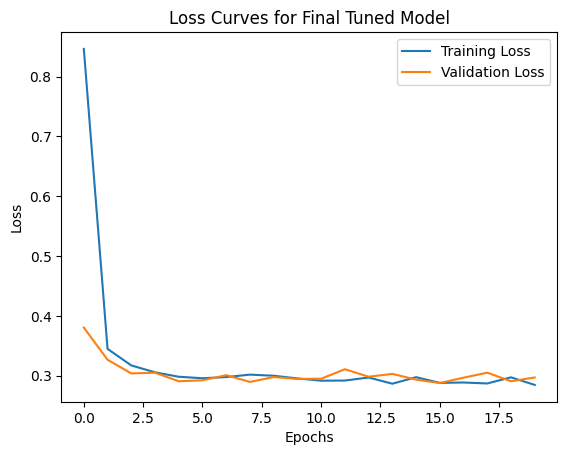

In [ ]:
model_2_after_tuning = create_model(neurons=128, activation='relu', optimizer='adam', kernel_regularizer=l1(0.001))
model_2_after_tuning.fit(X_train_2, y_train_2, epochs=20, batch_size=32, validation_data=(X_val_2, y_val_2))

#Plot loss curves for training and validation:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Curves for Final Tuned Model')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
#Evaluate the final model on the test set
y_pred = model_2.predict(X_test_2).round()

# Performance metrics of the Final model on the test data
final_model_2_accuracy = accuracy_score(y_test_2, y_pred)
final_model_2_conf_matrix = confusion_matrix(y_test_2, y_pred)
final_model_2_precision = precision_score(y_test_2, y_pred)
final_model_2_recall = recall_score(y_test_2, y_pred)
final_model_2_auc_score = roc_auc_score(y_test_2, y_pred)

#Print the performance metrics:
print("Final model 2 Accuracy:", final_model_2_accuracy )
print("Final model 2 Confusion Matrix:\n",final_model_2_conf_matrix)
print("Final model 2 Precision:", final_model_2_precision)
print("Final model 2 Recall:", final_model_2_recall)
print("Final model 2 AUC Score:", final_model_2_auc_score)

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Final model 2 Accuracy: 0.8940542697525937
Final model 2 Confusion Matrix:
 [[ 419  332]
 [ 199 4062]]
Final model 2 Precision: 0.9244424214838416
Final model 2 Recall: 0.9532973480403661
Final model 2 AUC Score: 0.7556100588404228


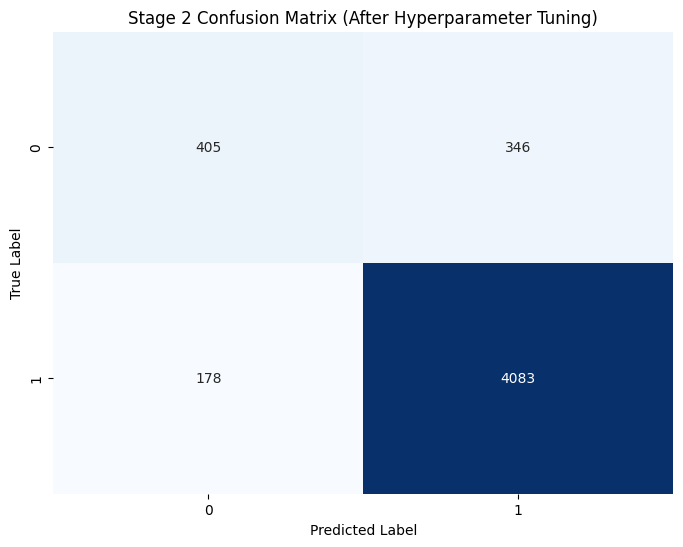

In [ ]:
def plot_confusion_matrix(final_model_2_conf_matrix, title="Confusion Matrix"):
    plt.figure(figsize=(8, 6))
    sns.heatmap(initial_model_conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(title)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

# Plot confusion matrix before hyperparameter tuning
plot_confusion_matrix(final_model_2_conf_matrix, title="Stage 2 Confusion Matrix (After Hyperparameter Tuning)")

Again minimal improvement in the models predictive performance metrics after hyper parameter tunining between initial and final. There is also not much increase between final model in stage 1 performance metrics and the final model in stage 2.

# Stage 3 dataset - Academic performance data

The Stage 3 Dataset included all the features from stage 1 & 2 and 3 additional new features,
‘Assessed Module’, ‘Passed Module’ and ‘Failed Module’



In [ ]:
# File URL
file_url_3 = "https://drive.google.com/uc?id=18oyu-RQotQN6jaibsLBoPdqQJbj_cV2-"

In [ ]:
stg_3_data = pd.read_csv(file_url_3)
stg_3_data.head()

,CentreName,LearnerCode,BookingType,LeadSource,DiscountType,DateofBirth,Gender,Nationality,HomeState,HomeCity,...,CourseName,IsFirstIntake,CompletedCourse,AssessedModules,PassedModules,FailedModules,ProgressionDegree,ProgressionUniversity,AuthorisedAbsenceCount,UnauthorisedAbsenceCount
0,ISC_Aberdeen,2284932,Agent,Standard Agent Booking,NaN,13/01/1998,Male,Chinese,Jianye District; Jiangsu Province,Nanjing,...,Business and Law Pre-Masters,True,Yes,4.0,4.0,0.0,Msc Econ Accounting and Investment Management,University of Aberdeen,NaN,NaN
1,ISC_Aberdeen,2399500,Agent,Standard Agent Booking,NaN,12/2/1998,Male,Chinese,NaN,Xi'an,...,Life Sciences Undergraduate Foundation Programme,False,Yes,7.0,7.0,0.0,BSc Biological Sciences,University of Aberdeen,93.0,5.0
2,ISC_Aberdeen,2424946,Agent,Standard Agent Booking,NaN,7/4/2000,Male,Chinese,NaN,Chengdu,...,Business Management and Finance International ...,False,Yes,8.0,8.0,0.0,MA Finance,University of Aberdeen,92.0,6.0
3,ISC_Aberdeen,2426583,Agent,Standard Agent Booking,NaN,18/05/1999,Male,Chinese,NaN,LIUYANG CITY ;CHANGSHA,...,Business Management and Finance International ...,True,Yes,8.0,8.0,0.0,MA Business Management,University of Aberdeen,67.0,15.0
4,ISC_Aberdeen,2434674,Agent,Standard Agent Booking,NaN,19/04/1996,Male,Chinese,NaN,Xiamen,...,Business and Law Pre-Masters,True,Yes,4.0,4.0,0.0,MSc International Business Management,University of Aberdeen,NaN,NaN


In [ ]:
stg_3_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25059 entries, 0 to 25058
Data columns (total 21 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   CentreName                25059 non-null  object 
 1   LearnerCode               25059 non-null  int64  
 2   BookingType               25059 non-null  object 
 3   LeadSource                25059 non-null  object 
 4   DiscountType              7595 non-null   object 
 5   DateofBirth               25059 non-null  object 
 6   Gender                    25059 non-null  object 
 7   Nationality               25059 non-null  object 
 8   HomeState                 8925 non-null   object 
 9   HomeCity                  21611 non-null  object 
 10  CourseLevel               25059 non-null  object 
 11  CourseName                25059 non-null  object 
 12  IsFirstIntake             25059 non-null  bool   
 13  CompletedCourse           25059 non-null  object 
 14  Assess

All three addtional features are in numeric format, have less than 200 unique feature categories.

However, all three features have missing values and so their feature distribution will be reviewed and feature imputation will be applied.

In [ ]:
#Drop all stage 2 data
stage_3_data = stg_3_data.drop(['CentreName','LearnerCode','BookingType','LeadSource','DiscountType','DateofBirth','Gender','Nationality','HomeState','HomeCity','CourseLevel','CourseName','IsFirstIntake','CompletedCourse','ProgressionDegree','ProgressionUniversity','UnauthorisedAbsenceCount','AuthorisedAbsenceCount'], axis=1)

In [ ]:
#Unique Values for each Feature
n_unique_values= stage_3_data.nunique()
print("number of unique values for all features:\n", n_unique_values, end="\n\n")

number of unique values for all features:
 AssessedModules    12
PassedModules      12
FailedModules      11
dtype: int64



In [ ]:
#features with more than 200 unique Values
Features_more_than_200_unique_values = n_unique_values[n_unique_values>200]
print("Features with more than 200 unique values:\n", Features_more_than_200_unique_values , end="\n")

Features with more than 200 unique values:
 Series([], dtype: int64)


In [ ]:
# Total number of rows
total_rows = 25059

# Total number of missing values for each column
missing_values = stage_3_data.isnull().sum()

print(missing_values)

AssessedModules    2231
PassedModules      2231
FailedModules      2231
dtype: int64


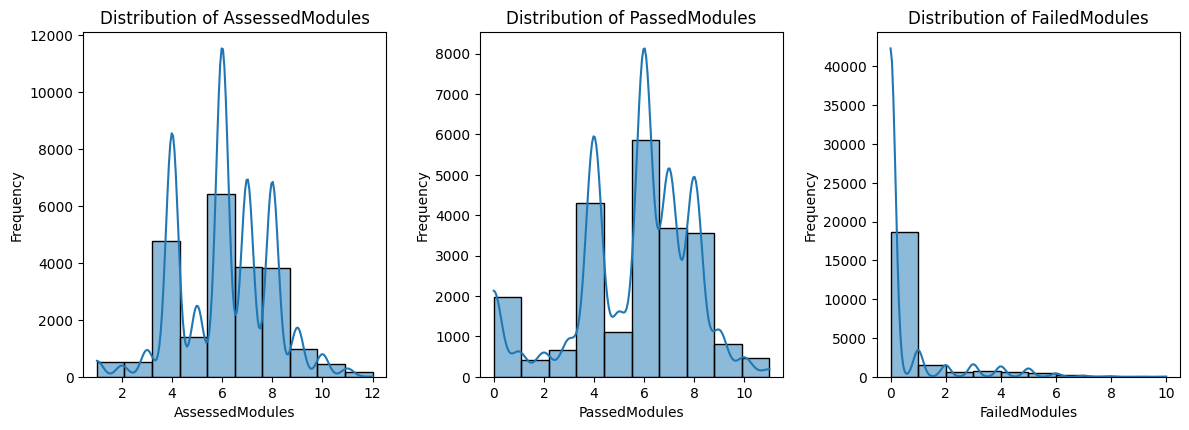

In [ ]:
#Histogram of the features in Stage 3 Dataset:
plt.figure(figsize=(12, 8))
for i, column in enumerate(stage_3_data.columns, 1):
    plt.subplot(2, 3, i)
    sns.histplot(stage_3_data[column], kde=True, bins=10)
    plt.title(f'Distribution of {column}')
    plt.xlabel(column)
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

These missing values were imputed using median for the features with skewed
distribution, mode for features with extremely skewed distribution.

'Failed module' feature Distribution showed extremely skewed distribution. For this feature the mode will be used to impute missing values.

The other two features show multimodal distribution and so further visual analysis will be conducted using a boxplot.

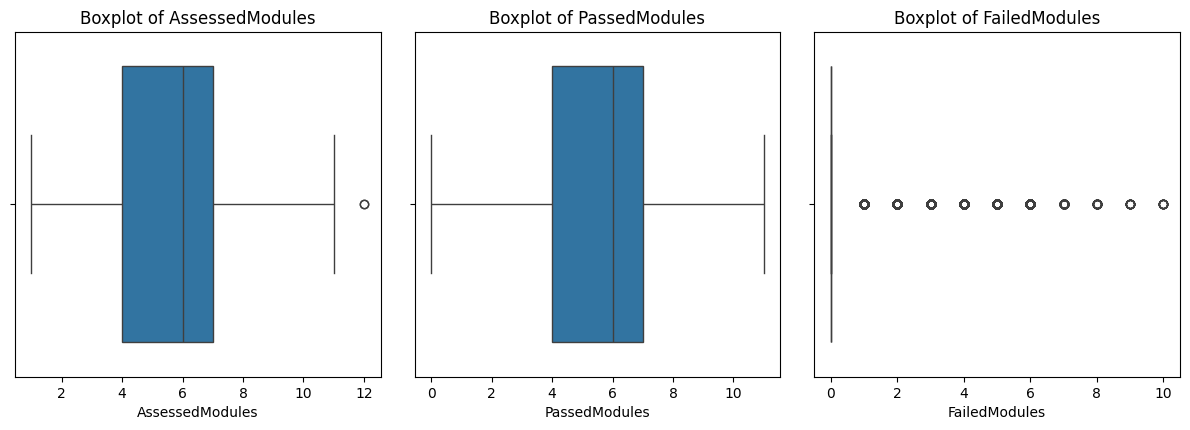

In [ ]:
plt.figure(figsize=(12, 8))
for i, column in enumerate(stage_3_data.columns, 1):
    plt.subplot(2, 3, i)
    sns.boxplot(x=stage_3_data[column],  orient='h')
    plt.title(f'Boxplot of {column}')

plt.tight_layout()
plt.show()

Both 'Assessed module' and 'Passed Modules' are left-skewed and hence we will use the median to impute the missing values in these features.



In [ ]:
from sklearn.impute import SimpleImputer

#Feature Imputation:
#Median impute
median_imputer = SimpleImputer(strategy='median')
stage_3_data[['AssessedModules', 'PassedModules']] = median_imputer.fit_transform(stage_3_data[['AssessedModules', 'PassedModules']])

#mode impute
mode_imputer = SimpleImputer(strategy='most_frequent')
stage_3_data[['FailedModules']] = mode_imputer.fit_transform(stage_3_data[['FailedModules']])


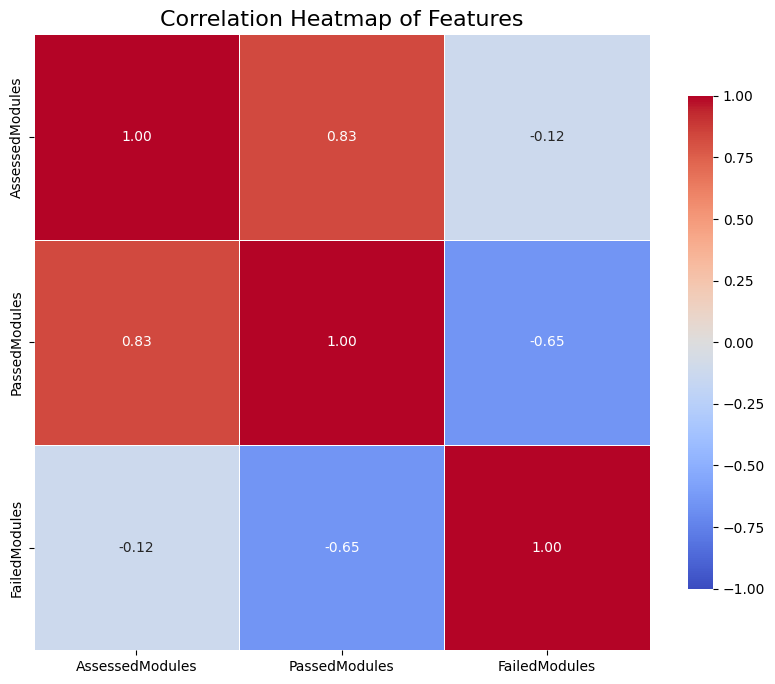

In [ ]:
#Compute the correlation matrix
correlation_matrix = stage_3_data.corr()
plt.figure(figsize=(10, 8))

# Create a heatmap using seaborn
sns.heatmap(correlation_matrix,
            annot=True,
            fmt='.2f',
            cmap='coolwarm',
            vmin=-1, vmax=1,
            square=True,
            linewidths=0.5,
            cbar_kws={"shrink": 0.8})

plt.title('Correlation Heatmap of Features', fontsize=16)
plt.show()

The Correlation matrix shows that the features are highly correlated.Strong positive correlation between AssessedModules and PassedModules,Strong negative correlation between PassedModules and FailedModules, Weak negative correlation between Passed Modules and FailedModules

In [ ]:
#Combine encoded stage 1 data, stage 2 and stage 3
combined_stage_1_2_3_data = pd.concat([combined_stage_1_and_2_data, stage_3_data], axis=1)
combined_stage_1_2_3_data.head()


,CourseLevel,CompletedCourse,IsFirstIntake,Age,Gender,Nationality_(Not known),Nationality_Afghan,Nationality_Albanian,Nationality_Algerian,Nationality_American,...,Booking_LeadSource_Direct - APD,Booking_LeadSource_Direct - Digital (Web),Booking_LeadSource_Direct - Re-enrolment,Booking_LeadSource_Direct - Referrals,Booking_LeadSource_Direct - Sponsor,Booking_LeadSource_Direct - Walk-in,AuthorisedAbsenceCount,AssessedModules,PassedModules,FailedModules
0,3.0,1.0,1.0,27.120548,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,4.0,0.0
1,0.0,1.0,0.0,27.038356,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,93.0,7.0,7.0,0.0
2,2.0,1.0,0.0,24.887671,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,92.0,8.0,8.0,0.0
3,2.0,1.0,1.0,25.778082,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,67.0,8.0,8.0,0.0
4,3.0,1.0,1.0,28.857534,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,4.0,0.0


The model was trained using all per-processed features from Stage 2, along with Assessed
Module, Passed Module, and Failed Module provided in the stage 3 Dataset

Similar to Stage 2 80-20% training testing split was used.

The features summarised are: 'Course Level', 'Completed Course', 'IsFirstIntake', 'Age', 'Gender', 'Nationality', 'Course Name', 'Centre_University', 'Booking_LeadSource','Authorised Absence Count','Assessed
Module', 'Passed Module', and 'Failed Module'

The target variable remained as 'CompletedCourse' and was stratified to reduce impact of the outcomes in the target varibale being imbalanced.

In [ ]:
#Data Splitting and Training:
# Split the data into features (X) and the target variable (y)
X3 = combined_stage_1_2_3_data.drop('CompletedCourse', axis=1)
y3 = combined_stage_1_2_3_data['CompletedCourse']

#Train Test Split
X_train_3, X_test_3, y_train_3, y_test_3 = train_test_split(X3, y3, test_size=0.2, random_state=42,stratify=y3)
X_train_3,X_val_3,y_train_3,y_val_3 = train_test_split(X_train_3,y_train_3,test_size=0.2,random_state=42, stratify=y_train_3)

#view output
print("X_train shape:", X_train_3.shape)
print("X_test shape:", X_test_3.shape)

X_train shape: (16037, 382)
X_test shape: (5012, 382)


 ## XGBoost Modelling for Stage 3 Dataset

The initial models and hyperparameters from previous stages were used as starting points
for training and testing Stage 2 and Stage 3 Datasets.
Hyperparameter tuning was conducted similarly, and the best combination (based on the
highest validation AUC) was selected to build the final model.
Performance metrics were recorded for the initial & final models for the models.

Initial Model Accuracy: 0.9710694333599361
Initial Model AUC Score: 0.9270447820335617
Initial Model Classification Report:
              precision    recall  f1-score   support

         0.0       0.94      0.86      0.90       751
         1.0       0.98      0.99      0.98      4261

    accuracy                           0.97      5012
   macro avg       0.96      0.93      0.94      5012
weighted avg       0.97      0.97      0.97      5012



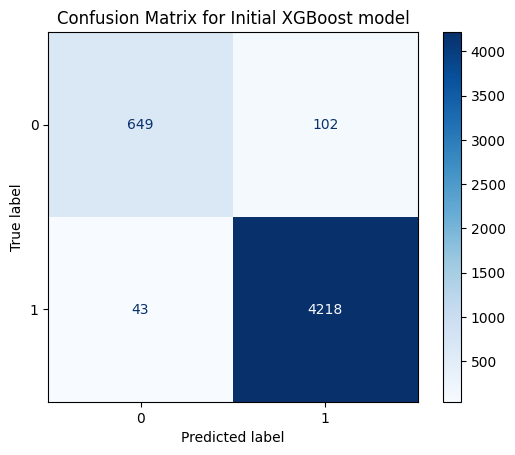

In [ ]:
import xgboost as xgb
initial_xg_model = xgb.XGBClassifier(random_state=42, alpha= 0.1, learning_rate=0.1, max_depth= 5, n_estimators=200) #used best parameters from the stage 2 model
initial_xg_model.fit(X_train_3, y_train_3)

#Model Evaluation metrics
y_pred = initial_xg_model.predict(X_test_3)
accuracy = accuracy_score(y_test_3, y_pred)
classification_rep = classification_report(y_test_3, y_pred)
auc_score = roc_auc_score(y_test_3, y_pred)

# View output
print(f"Initial Model Accuracy: {accuracy}")
print(f"Initial Model AUC Score: {auc_score}")
print("Initial Model Classification Report:")
print(classification_rep)

#plot confusion matrix
conf_matrix_Initial = confusion_matrix(y_test_3, y_pred)
Initial_conf_matrix = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_Initial, display_labels=initial_xg_model.classes_)
Initial_conf_matrix.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix for Initial XGBoost model")
plt.show()

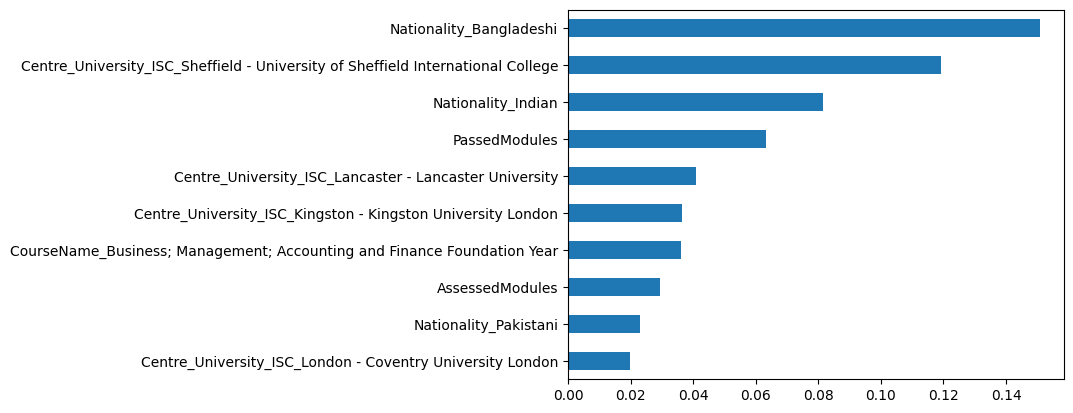

In [ ]:
# Feature Importance for Final XGBOOST:
# Convert x_train which is a numpy array into a data frame
x_train_3_df = pd.DataFrame(X_train_3, columns=X_train_3.columns)

#feature importance
feature_importance = pd.Series(initial_xg_model.feature_importances_,index=x_train_3_df.columns).sort_values()

feature_importance.iloc[-10:].plot.barh()
plt.show()

In [ ]:
from sklearn.model_selection import GridSearchCV

hyperparameter_tuning = {
    'alpha': [0.1, 0.3, 0.5],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [50, 100,200]
}

#GridSearchCV
grid_search = GridSearchCV(estimator=initial_xg_model, param_grid=hyperparameter_tuning, cv=5, scoring='roc_auc', verbose=1)
grid_search.fit(X_train_3, y_train_3)

#Output for the best Hyperparameter combination with regards to AUC
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best AUC score: {grid_search.best_score_}")

Fitting 5 folds for each of 81 candidates, totalling 405 fits
Best parameters: {'alpha': 0.5, 'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 200}
Best AUC score: 0.9910144399603972


Final Model Accuracy: 0.9724660814046289
Final Model AUC Score: 0.9355442840665235
Final Model Classification Report:
              precision    recall  f1-score   support

         0.0       0.93      0.88      0.91       751
         1.0       0.98      0.99      0.98      4261

    accuracy                           0.97      5012
   macro avg       0.95      0.94      0.94      5012
weighted avg       0.97      0.97      0.97      5012



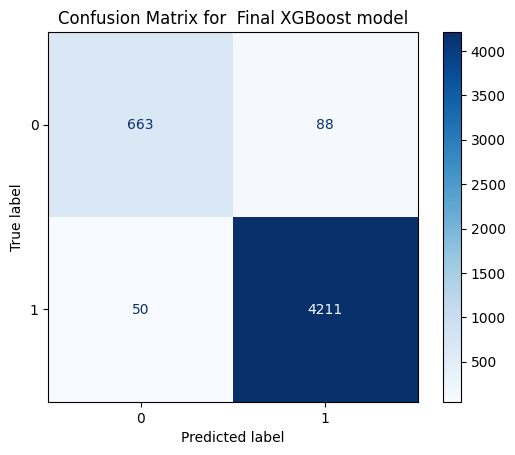

In [ ]:
#Test the hyperparameter combination selectef from the tuning
final_xg_model = xgb.XGBClassifier(random_state=42, alpha= 0.5, learning_rate=0.2, max_depth= 5, n_estimators=200)
final_xg_model.fit(X_train_3, y_train_3)

#Model Evaluation metrics
y_pred = final_xg_model.predict(X_test_3)
accuracy = accuracy_score(y_test_3, y_pred)
classification_rep = classification_report(y_test_3, y_pred)
auc_score = roc_auc_score(y_test_3, y_pred)

# View output
print(f"Final Model Accuracy: {accuracy}")
print(f"Final Model AUC Score: {auc_score}")
print("Final Model Classification Report:")
print(classification_rep)

#plot confusion matrix
conf_matrix_final = confusion_matrix(y_test_3, y_pred)
Initial_conf_matrix = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_final, display_labels=final_xg_model .classes_)
Initial_conf_matrix.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix for  Final XGBoost model")
plt.show()

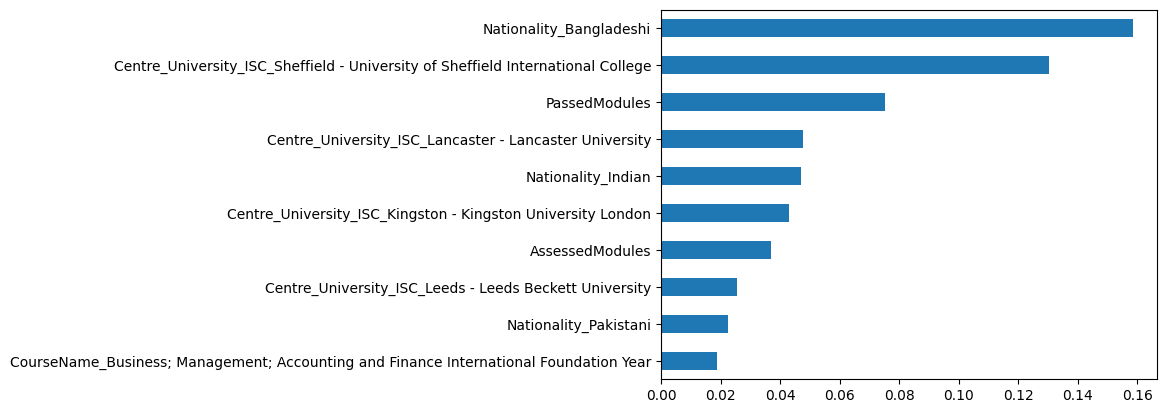

In [ ]:
# Feature Importance for Final XGBOOST:
# Convert x_train which is a numpy array into a data frame
x_train_3_df = pd.DataFrame(X_train_3, columns=X_train_3.columns)

#feature importance
feature_importance = pd.Series(final_xg_model.feature_importances_,index=x_train_3_df.columns).sort_values()

feature_importance.iloc[-10:].plot.barh()
plt.show()

This is evident from the substantial increase in performance metrics between Stages 2 and 3, compared to the minimal or no improvement observed between the final model in Stage 1 and the initial model in Stage 2. Both Passed Module and Assessed Module are in the top 10 in feature importance chart

 ## Neural Network Modelling for Stage 3 Data Set:

In [ ]:
#Scaling using standard Scaler:
scaler = StandardScaler()
X_train_3 = scaler.fit_transform(X_train_3)
X_test_3 = scaler.transform(X_test_3)
X_val_3= scaler.transform(X_val_3)

In [ ]:
#Create Function for the model for stage 3 Dataset
def create_model(neurons=128, activation='relu', optimizer='adam', kernel_regularizer=l1(0.001)): #will run initial model with best hyperparameters from stage 2 hyperparameter tuning
    model = Sequential()
    model.add(Dense(units=neurons, activation=activation, input_shape=(X_train_3.shape[1],),kernel_regularizer=kernel_regularizer))
    model.add(Dense(units=neurons//2, activation=activation))
    model.add(Dense(1, activation='sigmoid'))


  #Compile Model
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy', 'Precision', 'Recall', 'AUC',])
    return model

Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


502/502 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - AUC: 0.8560 - Precision: 0.9115 - Recall: 0.9572 - accuracy: 0.8839 - loss: 1.2669 - val_AUC: 0.9505 - val_Precision: 0.9530 - val_Recall: 0.9642 - val_accuracy: 0.9292 - val_loss: 0.3596
Epoch 2/20
502/502 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - AUC: 0.9534 - Precision: 0.9500 - Recall: 0.9732 - accuracy: 0.9339 - loss: 0.3314 - val_AUC: 0.9767 - val_Precision: 0.9577 - val_Recall: 0.9897 - val_accuracy: 0.9541 - val_loss: 0.2682
Epoch 3/20
502/502 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.9783 - Precision: 0.9680 - Recall: 0.9858 - accuracy: 0.9602 - loss: 0.2389 - val_AUC: 0.9806 - val_Precision: 0.9660 - val_Recall: 0.9845 - val_accuracy: 0.9574 - val_loss: 0.2230
Epoch 4/20
502/502 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.9829 - Precision: 0.9733 - Recall: 0.9869 - accuracy: 0.9660 - loss: 0.2010 - val_AUC: 0.9855 - val_Precision: 0.9745 - val_Recall: 0.9880 - val_accuracy: 0.9678 - val_loss: 0.1936
Epoch 5/20
502/502 ━━━━━━━━━━━━━━━━━━━━ 2s 

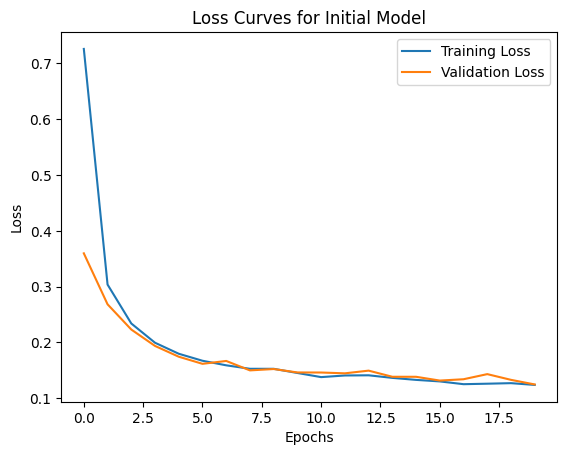

In [ ]:
#Instantiate the initial model
model_3= create_model()
history = model_3.fit(X_train_3, y_train_3, epochs=20, batch_size=32, validation_data=(X_val_3, y_val_3))

#Plot loss curves for training and validation:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Curves for Initial Model')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
#Evaluate the initial model on the test set
y_pred = model_3.predict(X_test_3).round()

# Performance metrics of the initial model on the test data
initial_model_3_accuracy = accuracy_score(y_test_3, y_pred)
initial_model_3_conf_matrix = confusion_matrix(y_test_3, y_pred)
initial_model_3_precision = precision_score(y_test_3, y_pred)
initial_model_3_recall = recall_score(y_test_3, y_pred)
initial_model_3_auc_score = roc_auc_score(y_test_3, y_pred)

#Print the performance metrics:
print("Initial model 3 Accuracy:", initial_model_3_accuracy )
print("Initial model 3 Confusion Matrix:\n",initial_model_3_conf_matrix)
print("Initial model 3 Precision:", initial_model_3_precision)
print("Initial model 3 Recall:", initial_model_3_recall)
print("Initial model 3 AUC Score:", initial_model_3_auc_score)

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Initial model 3 Accuracy: 0.9680766161213089
Initial model 3 Confusion Matrix:
 [[ 645  106]
 [  54 4207]]
Initial model 3 Precision: 0.9754231393461628
Initial model 3 Recall: 0.9873269185637175
Initial model 3 AUC Score: 0.9230908893750678


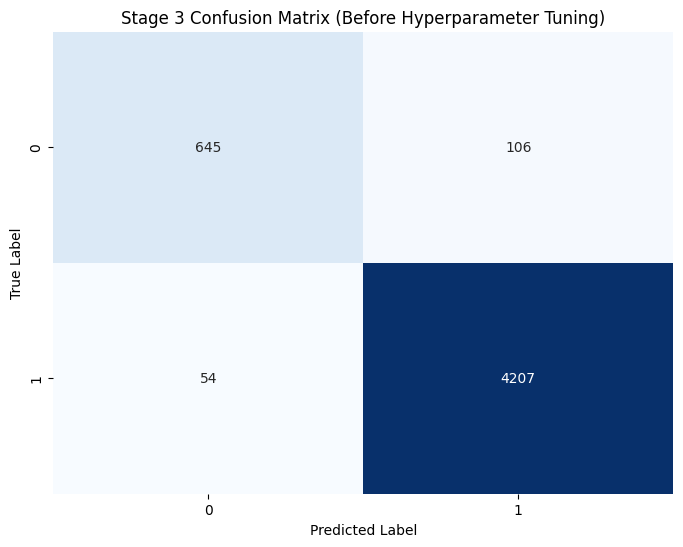

In [ ]:
def plot_confusion_matrix(initial_model_3_conf_matrix, title="Confusion Matrix"):
    plt.figure(figsize=(8, 6))
    sns.heatmap(initial_model_3_conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(title)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

# Plot confusion matrix before hyperparameter tuning
plot_confusion_matrix(initial_model_3_conf_matrix, title="Stage 3 Confusion Matrix (Before Hyperparameter Tuning)")


In [ ]:
from keras.optimizers import Adam, RMSprop
from keras.models import Sequential
from keras.layers import Dense
from keras import regularizers
import numpy as np
import matplotlib.pyplot as plt

#Results dictionary:
results = {}

# Hyperparameter tuning
neurons = [32, 64, 128]
activations = ['relu', 'tanh']
regularizers = [regularizers.l1(0.001),regularizers.l1(0.01)]
optimizers = ['adam', 'rmsprop']

#Loop for each Vector:
for neuron in neurons:
    for activation in activations:
        for optimizer in optimizers:
            for regularizer in regularizers:
                print(f"Training with {neuron} neurons, {activation} activation, {optimizer} optimizer, {regularizer} regularizer")
                model = create_model(neurons=neuron, activation=activation, optimizer=optimizer, kernel_regularizer=regularizer)
                history = model.fit(X_train_3, y_train_3, epochs=20, batch_size=32, validation_data=(X_val_3, y_val_3))
                val_AUC = history.history['val_AUC'][-1]
                results[(neuron, activation, optimizer, regularizer)] = val_AUC

# Output for the hyperparameter combination with highest Val_AUC
best_params = max(results, key=results.get)
best_val_auc = results[best_params]
print(f"Best combination: {best_params} with validation AUC: {best_val_auc}")

Training with 32 neurons, relu activation, adam optimizer, <keras.src.regularizers.regularizers.L1 object at 0x7e8b640a3590> regularizer


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
502/502 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - AUC: 0.7953 - Precision: 0.8961 - Recall: 0.8867 - accuracy: 0.8167 - loss: 0.7880 - val_AUC: 0.9337 - val_Precision: 0.9207 - val_Recall: 0.9707 - val_accuracy: 0.9040 - val_loss: 0.3476
Epoch 2/20
502/502 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.9416 - Precision: 0.9362 - Recall: 0.9740 - accuracy: 0.9211 - loss: 0.3097 - val_AUC: 0.9562 - val_Precision: 0.9508 - val_Recall: 0.9692 - val_accuracy: 0.9312 - val_loss: 0.2732
Epoch 3/20
502/502 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.9557 - Precision: 0.9542 - Recall: 0.9769 - accuracy: 0.9403 - loss: 0.2578 - val_AUC: 0.9737 - val_Precision: 0.9673 - val_Recall: 0.9812 - val_accuracy: 0.9559 - val_loss: 0.2171
Epoch 4/20
502/502 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9727 - Precision: 0.9638 - Recall: 0.9837 - accuracy: 0.9549 - loss: 0.2140 - val_AUC: 0.9773 - val_Precision: 0.9688 - val_Recall: 0.9839 - val_accuracy: 0.9594 - val_loss: 0.1940
Epoch 5/20
502/502 ━━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


502/502 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - AUC: 0.7938 - Precision: 0.8786 - Recall: 0.9400 - accuracy: 0.8367 - loss: 2.6450 - val_AUC: 0.9233 - val_Precision: 0.9416 - val_Recall: 0.9407 - val_accuracy: 0.9000 - val_loss: 0.3712
Epoch 2/20
502/502 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.9203 - Precision: 0.9266 - Recall: 0.9461 - accuracy: 0.8907 - loss: 0.3716 - val_AUC: 0.9366 - val_Precision: 0.9339 - val_Recall: 0.9575 - val_accuracy: 0.9062 - val_loss: 0.3534
Epoch 3/20
502/502 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.9296 - Precision: 0.9324 - Recall: 0.9546 - accuracy: 0.9028 - loss: 0.3502 - val_AUC: 0.9392 - val_Precision: 0.9280 - val_Recall: 0.9677 - val_accuracy: 0.9087 - val_loss: 0.3333
Epoch 4/20
502/502 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9374 - Precision: 0.9361 - Recall: 0.9622 - accuracy: 0.9119 - loss: 0.3281 - val_AUC: 0.9458 - val_Precision: 0.9502 - val_Recall: 0.9569 - val_accuracy: 0.9207 - val_loss: 0.3243
Epoch 5/20
502/502 ━━━━━━━━━━━━━━━━━━━━ 2s 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


502/502 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - AUC: 0.8060 - Precision: 0.8699 - Recall: 0.9890 - accuracy: 0.8646 - loss: 0.6344 - val_AUC: 0.9316 - val_Precision: 0.9305 - val_Recall: 0.9578 - val_accuracy: 0.9032 - val_loss: 0.3008
Epoch 2/20
502/502 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9334 - Precision: 0.9348 - Recall: 0.9599 - accuracy: 0.9091 - loss: 0.2932 - val_AUC: 0.9509 - val_Precision: 0.9538 - val_Recall: 0.9572 - val_accuracy: 0.9242 - val_loss: 0.2638
Epoch 3/20
502/502 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9464 - Precision: 0.9466 - Recall: 0.9690 - accuracy: 0.9272 - loss: 0.2601 - val_AUC: 0.9645 - val_Precision: 0.9624 - val_Recall: 0.9748 - val_accuracy: 0.9461 - val_loss: 0.2237
Epoch 4/20
502/502 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9618 - Precision: 0.9597 - Recall: 0.9773 - accuracy: 0.9460 - loss: 0.2269 - val_AUC: 0.9706 - val_Precision: 0.9639 - val_Recall: 0.9803 - val_accuracy: 0.9521 - val_loss: 0.2034
Epoch 5/20
502/502 ━━━━━━━━━━━━━━━━━━━━ 2s 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


502/502 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - AUC: 0.7712 - Precision: 0.8649 - Recall: 0.9776 - accuracy: 0.8507 - loss: 2.2688 - val_AUC: 0.9327 - val_Precision: 0.9123 - val_Recall: 0.9671 - val_accuracy: 0.8930 - val_loss: 0.3642
Epoch 2/20
502/502 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9315 - Precision: 0.9275 - Recall: 0.9631 - accuracy: 0.9046 - loss: 0.3514 - val_AUC: 0.9446 - val_Precision: 0.9440 - val_Recall: 0.9595 - val_accuracy: 0.9172 - val_loss: 0.3218
Epoch 3/20
502/502 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.9369 - Precision: 0.9388 - Recall: 0.9588 - accuracy: 0.9117 - loss: 0.3311 - val_AUC: 0.9433 - val_Precision: 0.9533 - val_Recall: 0.9454 - val_accuracy: 0.9142 - val_loss: 0.3582
Epoch 4/20
502/502 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.9421 - Precision: 0.9454 - Recall: 0.9592 - accuracy: 0.9179 - loss: 0.3207 - val_AUC: 0.9476 - val_Precision: 0.9400 - val_Recall: 0.9654 - val_accuracy: 0.9182 - val_loss: 0.3297
Epoch 5/20
502/502 ━━━━━━━━━━━━━━━━━━━━ 3s 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
502/502 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - AUC: 0.8174 - Precision: 0.9247 - Recall: 0.8361 - accuracy: 0.8030 - loss: 0.8015 - val_AUC: 0.9268 - val_Precision: 0.9309 - val_Recall: 0.9563 - val_accuracy: 0.9025 - val_loss: 0.3336
Epoch 2/20
502/502 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.9219 - Precision: 0.9313 - Recall: 0.9625 - accuracy: 0.9074 - loss: 0.3186 - val_AUC: 0.9354 - val_Precision: 0.9367 - val_Recall: 0.9630 - val_accuracy: 0.9132 - val_loss: 0.2862
Epoch 3/20
502/502 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.9333 - Precision: 0.9380 - Recall: 0.9708 - accuracy: 0.9207 - loss: 0.2767 - val_AUC: 0.9421 - val_Precision: 0.9427 - val_Recall: 0.9698 - val_accuracy: 0.9242 - val_loss: 0.2676
Epoch 4/20
502/502 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9380 - Precision: 0.9435 - Recall: 0.9730 - accuracy: 0.9274 - loss: 0.2596 - val_AUC: 0.9545 - val_Precision: 0.9586 - val_Recall: 0.9639 - val_accuracy: 0.9339 - val_loss: 0.2418
Epoch 5/20
502/502 ━━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


502/502 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - AUC: 0.8150 - Precision: 0.9110 - Recall: 0.8492 - accuracy: 0.8040 - loss: 2.6447 - val_AUC: 0.9092 - val_Precision: 0.9159 - val_Recall: 0.9493 - val_accuracy: 0.8828 - val_loss: 0.3942
Epoch 2/20
502/502 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8993 - Precision: 0.9124 - Recall: 0.9556 - accuracy: 0.8843 - loss: 0.3890 - val_AUC: 0.9151 - val_Precision: 0.9213 - val_Recall: 0.9581 - val_accuracy: 0.8948 - val_loss: 0.3502
Epoch 3/20
502/502 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.9094 - Precision: 0.9245 - Recall: 0.9581 - accuracy: 0.8977 - loss: 0.3452 - val_AUC: 0.9187 - val_Precision: 0.9140 - val_Recall: 0.9598 - val_accuracy: 0.8890 - val_loss: 0.3322
Epoch 4/20
502/502 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.9104 - Precision: 0.9203 - Recall: 0.9533 - accuracy: 0.8899 - loss: 0.3303 - val_AUC: 0.9233 - val_Precision: 0.9264 - val_Recall: 0.9484 - val_accuracy: 0.8920 - val_loss: 0.3319
Epoch 5/20
502/502 ━━━━━━━━━━━━━━━━━━━━ 3s 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


502/502 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - AUC: 0.8153 - Precision: 0.9169 - Recall: 0.8440 - accuracy: 0.8024 - loss: 0.7428 - val_AUC: 0.9289 - val_Precision: 0.9251 - val_Recall: 0.9671 - val_accuracy: 0.9055 - val_loss: 0.2878
Epoch 2/20
502/502 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.9225 - Precision: 0.9289 - Recall: 0.9636 - accuracy: 0.9063 - loss: 0.2845 - val_AUC: 0.9354 - val_Precision: 0.9424 - val_Recall: 0.9507 - val_accuracy: 0.9087 - val_loss: 0.2682
Epoch 3/20
502/502 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.9228 - Precision: 0.9322 - Recall: 0.9649 - accuracy: 0.9108 - loss: 0.2754 - val_AUC: 0.9432 - val_Precision: 0.9531 - val_Recall: 0.9598 - val_accuracy: 0.9257 - val_loss: 0.2496
Epoch 4/20
502/502 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.9389 - Precision: 0.9489 - Recall: 0.9754 - accuracy: 0.9346 - loss: 0.2444 - val_AUC: 0.9594 - val_Precision: 0.9557 - val_Recall: 0.9801 - val_accuracy: 0.9444 - val_loss: 0.2168
Epoch 5/20
502/502 ━━━━━━━━━━━━━━━━━━━━ 2s 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


502/502 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - AUC: 0.8280 - Precision: 0.9163 - Recall: 0.8757 - accuracy: 0.8259 - loss: 2.2839 - val_AUC: 0.9172 - val_Precision: 0.9243 - val_Recall: 0.9522 - val_accuracy: 0.8930 - val_loss: 0.3688
Epoch 2/20
502/502 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.9056 - Precision: 0.9125 - Recall: 0.9600 - accuracy: 0.8877 - loss: 0.3704 - val_AUC: 0.9076 - val_Precision: 0.8878 - val_Recall: 0.9909 - val_accuracy: 0.8858 - val_loss: 0.3788
Epoch 3/20
502/502 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.9111 - Precision: 0.9169 - Recall: 0.9617 - accuracy: 0.8936 - loss: 0.3554 - val_AUC: 0.9135 - val_Precision: 0.9071 - val_Recall: 0.9592 - val_accuracy: 0.8818 - val_loss: 0.3507
Epoch 4/20
502/502 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.9044 - Precision: 0.9139 - Recall: 0.9580 - accuracy: 0.8877 - loss: 0.3626 - val_AUC: 0.9196 - val_Precision: 0.9365 - val_Recall: 0.9349 - val_accuracy: 0.8908 - val_loss: 0.3691
Epoch 5/20
502/502 ━━━━━━━━━━━━━━━━━━━━ 3s 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


502/502 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - AUC: 0.8057 - Precision: 0.8922 - Recall: 0.9402 - accuracy: 0.8517 - loss: 0.9595 - val_AUC: 0.9441 - val_Precision: 0.9392 - val_Recall: 0.9701 - val_accuracy: 0.9212 - val_loss: 0.3414
Epoch 2/20
502/502 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - AUC: 0.9375 - Precision: 0.9379 - Recall: 0.9752 - accuracy: 0.9238 - loss: 0.3274 - val_AUC: 0.9577 - val_Precision: 0.9618 - val_Recall: 0.9754 - val_accuracy: 0.9461 - val_loss: 0.2845
Epoch 3/20
502/502 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.9578 - Precision: 0.9597 - Recall: 0.9836 - accuracy: 0.9511 - loss: 0.2630 - val_AUC: 0.9790 - val_Precision: 0.9716 - val_Recall: 0.9842 - val_accuracy: 0.9621 - val_loss: 0.2147
Epoch 4/20
502/502 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.9796 - Precision: 0.9689 - Recall: 0.9861 - accuracy: 0.9613 - loss: 0.2045 - val_AUC: 0.9833 - val_Precision: 0.9737 - val_Recall: 0.9871 - val_accuracy: 0.9663 - val_loss: 0.1892
Epoch 5/20
502/502 ━━━━━━━━━━━━━━━━━━━━ 3s 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


502/502 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - AUC: 0.7616 - Precision: 0.8585 - Recall: 0.9387 - accuracy: 0.8183 - loss: 4.3762 - val_AUC: 0.9202 - val_Precision: 0.9163 - val_Recall: 0.9601 - val_accuracy: 0.8915 - val_loss: 0.4287
Epoch 2/20
502/502 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - AUC: 0.9101 - Precision: 0.9226 - Recall: 0.9575 - accuracy: 0.8949 - loss: 0.4256 - val_AUC: 0.9334 - val_Precision: 0.9289 - val_Recall: 0.9548 - val_accuracy: 0.8995 - val_loss: 0.3965
Epoch 3/20
502/502 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9316 - Precision: 0.9337 - Recall: 0.9602 - accuracy: 0.9077 - loss: 0.3882 - val_AUC: 0.9464 - val_Precision: 0.9478 - val_Recall: 0.9645 - val_accuracy: 0.9247 - val_loss: 0.3770
Epoch 4/20
502/502 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.9472 - Precision: 0.9446 - Recall: 0.9648 - accuracy: 0.9217 - loss: 0.3644 - val_AUC: 0.9509 - val_Precision: 0.9635 - val_Recall: 0.9607 - val_accuracy: 0.9357 - val_loss: 0.3715
Epoch 5/20
502/502 ━━━━━━━━━━━━━━━━━━━━ 3s 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


502/502 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - AUC: 0.8545 - Precision: 0.9065 - Recall: 0.9566 - accuracy: 0.8786 - loss: 0.8244 - val_AUC: 0.9444 - val_Precision: 0.9439 - val_Recall: 0.9633 - val_accuracy: 0.9202 - val_loss: 0.3071
Epoch 2/20
502/502 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9428 - Precision: 0.9456 - Recall: 0.9699 - accuracy: 0.9273 - loss: 0.2953 - val_AUC: 0.9677 - val_Precision: 0.9592 - val_Recall: 0.9795 - val_accuracy: 0.9471 - val_loss: 0.2329
Epoch 3/20
502/502 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.9688 - Precision: 0.9627 - Recall: 0.9813 - accuracy: 0.9517 - loss: 0.2244 - val_AUC: 0.9788 - val_Precision: 0.9737 - val_Recall: 0.9792 - val_accuracy: 0.9599 - val_loss: 0.1939
Epoch 4/20
502/502 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.9786 - Precision: 0.9705 - Recall: 0.9849 - accuracy: 0.9617 - loss: 0.1901 - val_AUC: 0.9844 - val_Precision: 0.9803 - val_Recall: 0.9768 - val_accuracy: 0.9636 - val_loss: 0.1738
Epoch 5/20
502/502 ━━━━━━━━━━━━━━━━━━━━ 2s 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


502/502 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - AUC: 0.8163 - Precision: 0.8802 - Recall: 0.9874 - accuracy: 0.8739 - loss: 3.6839 - val_AUC: 0.9419 - val_Precision: 0.9404 - val_Recall: 0.9680 - val_accuracy: 0.9207 - val_loss: 0.4120
Epoch 2/20
502/502 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - AUC: 0.9339 - Precision: 0.9377 - Recall: 0.9682 - accuracy: 0.9182 - loss: 0.4095 - val_AUC: 0.9585 - val_Precision: 0.9499 - val_Recall: 0.9842 - val_accuracy: 0.9424 - val_loss: 0.3701
Epoch 3/20
502/502 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.9569 - Precision: 0.9523 - Recall: 0.9758 - accuracy: 0.9385 - loss: 0.3694 - val_AUC: 0.9662 - val_Precision: 0.9711 - val_Recall: 0.9645 - val_accuracy: 0.9454 - val_loss: 0.3528
Epoch 4/20
502/502 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.9665 - Precision: 0.9640 - Recall: 0.9823 - accuracy: 0.9538 - loss: 0.3402 - val_AUC: 0.9735 - val_Precision: 0.9684 - val_Recall: 0.9798 - val_accuracy: 0.9556 - val_loss: 0.3328
Epoch 5/20
502/502 ━━━━━━━━━━━━━━━━━━━━ 3s 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
502/502 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - AUC: 0.8439 - Precision: 0.9279 - Recall: 0.8557 - accuracy: 0.8205 - loss: 1.0479 - val_AUC: 0.9231 - val_Precision: 0.9363 - val_Recall: 0.9537 - val_accuracy: 0.9055 - val_loss: 0.3575
Epoch 2/20
502/502 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.9241 - Precision: 0.9316 - Recall: 0.9611 - accuracy: 0.9072 - loss: 0.3326 - val_AUC: 0.9399 - val_Precision: 0.9375 - val_Recall: 0.9718 - val_accuracy: 0.9209 - val_loss: 0.2845
Epoch 3/20
502/502 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.9384 - Precision: 0.9456 - Recall: 0.9738 - accuracy: 0.9300 - loss: 0.2714 - val_AUC: 0.9653 - val_Precision: 0.9609 - val_Recall: 0.9803 - val_accuracy: 0.9494 - val_loss: 0.2385
Epoch 4/20
502/502 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.9695 - Precision: 0.9619 - Recall: 0.9833 - accuracy: 0.9528 - loss: 0.2241 - val_AUC: 0.9732 - val_Precision: 0.9703 - val_Recall: 0.9768 - val_accuracy: 0.9549 - val_loss: 0.2218
Epoch 5/20
502/502 ━━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


502/502 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - AUC: 0.8064 - Precision: 0.9081 - Recall: 0.8697 - accuracy: 0.8148 - loss: 4.3583 - val_AUC: 0.8993 - val_Precision: 0.9047 - val_Recall: 0.9689 - val_accuracy: 0.8868 - val_loss: 0.4282
Epoch 2/20
502/502 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.9021 - Precision: 0.9167 - Recall: 0.9564 - accuracy: 0.8892 - loss: 0.4031 - val_AUC: 0.9155 - val_Precision: 0.9193 - val_Recall: 0.9560 - val_accuracy: 0.8913 - val_loss: 0.3724
Epoch 3/20
502/502 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - AUC: 0.9112 - Precision: 0.9195 - Recall: 0.9556 - accuracy: 0.8910 - loss: 0.3666 - val_AUC: 0.9256 - val_Precision: 0.9385 - val_Recall: 0.9402 - val_accuracy: 0.8968 - val_loss: 0.3304
Epoch 4/20
502/502 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.9180 - Precision: 0.9224 - Recall: 0.9528 - accuracy: 0.8921 - loss: 0.3476 - val_AUC: 0.9241 - val_Precision: 0.9395 - val_Recall: 0.9425 - val_accuracy: 0.8995 - val_loss: 0.3480
Epoch 5/20
502/502 ━━━━━━━━━━━━━━━━━━━━ 2s 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


502/502 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - AUC: 0.8445 - Precision: 0.9243 - Recall: 0.8752 - accuracy: 0.8332 - loss: 0.9357 - val_AUC: 0.9226 - val_Precision: 0.9368 - val_Recall: 0.9484 - val_accuracy: 0.9017 - val_loss: 0.3190
Epoch 2/20
502/502 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.9170 - Precision: 0.9282 - Recall: 0.9625 - accuracy: 0.9053 - loss: 0.3065 - val_AUC: 0.9316 - val_Precision: 0.9511 - val_Recall: 0.9478 - val_accuracy: 0.9142 - val_loss: 0.2786
Epoch 3/20
502/502 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.9334 - Precision: 0.9418 - Recall: 0.9716 - accuracy: 0.9253 - loss: 0.2697 - val_AUC: 0.9644 - val_Precision: 0.9614 - val_Recall: 0.9792 - val_accuracy: 0.9489 - val_loss: 0.2215
Epoch 4/20
502/502 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.9654 - Precision: 0.9618 - Recall: 0.9842 - accuracy: 0.9533 - loss: 0.2087 - val_AUC: 0.9788 - val_Precision: 0.9746 - val_Recall: 0.9786 - val_accuracy: 0.9601 - val_loss: 0.1909
Epoch 5/20
502/502 ━━━━━━━━━━━━━━━━━━━━ 2s 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


502/502 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - AUC: 0.8365 - Precision: 0.9132 - Recall: 0.8896 - accuracy: 0.8340 - loss: 3.7713 - val_AUC: 0.9037 - val_Precision: 0.9033 - val_Recall: 0.9704 - val_accuracy: 0.8865 - val_loss: 0.4424
Epoch 2/20
502/502 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.9031 - Precision: 0.9106 - Recall: 0.9614 - accuracy: 0.8872 - loss: 0.4366 - val_AUC: 0.9169 - val_Precision: 0.9313 - val_Recall: 0.9466 - val_accuracy: 0.8953 - val_loss: 0.4111
Epoch 3/20
502/502 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - AUC: 0.9086 - Precision: 0.9169 - Recall: 0.9594 - accuracy: 0.8915 - loss: 0.4183 - val_AUC: 0.9169 - val_Precision: 0.9249 - val_Recall: 0.9498 - val_accuracy: 0.8918 - val_loss: 0.4331
Epoch 4/20
502/502 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.9098 - Precision: 0.9210 - Recall: 0.9600 - accuracy: 0.8960 - loss: 0.4119 - val_AUC: 0.9211 - val_Precision: 0.9320 - val_Recall: 0.9449 - val_accuracy: 0.8945 - val_loss: 0.4143
Epoch 5/20
502/502 ━━━━━━━━━━━━━━━━━━━━ 2s 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


502/502 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - AUC: 0.8529 - Precision: 0.9056 - Recall: 0.9513 - accuracy: 0.8744 - loss: 1.3104 - val_AUC: 0.9442 - val_Precision: 0.9390 - val_Recall: 0.9798 - val_accuracy: 0.9287 - val_loss: 0.3777
Epoch 2/20
502/502 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - AUC: 0.9515 - Precision: 0.9502 - Recall: 0.9747 - accuracy: 0.9353 - loss: 0.3392 - val_AUC: 0.9767 - val_Precision: 0.9687 - val_Recall: 0.9812 - val_accuracy: 0.9571 - val_loss: 0.2558
Epoch 3/20
502/502 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - AUC: 0.9733 - Precision: 0.9651 - Recall: 0.9842 - accuracy: 0.9563 - loss: 0.2524 - val_AUC: 0.9772 - val_Precision: 0.9755 - val_Recall: 0.9801 - val_accuracy: 0.9621 - val_loss: 0.2323
Epoch 4/20
502/502 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.9804 - Precision: 0.9706 - Recall: 0.9853 - accuracy: 0.9623 - loss: 0.2123 - val_AUC: 0.9856 - val_Precision: 0.9702 - val_Recall: 0.9853 - val_accuracy: 0.9618 - val_loss: 0.1952
Epoch 5/20
502/502 ━━━━━━━━━━━━━━━━━━━━ 2s 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


502/502 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - AUC: 0.7754 - Precision: 0.8683 - Recall: 0.9505 - accuracy: 0.8352 - loss: 7.3689 - val_AUC: 0.9051 - val_Precision: 0.9173 - val_Recall: 0.9440 - val_accuracy: 0.8800 - val_loss: 0.5207
Epoch 2/20
502/502 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - AUC: 0.9080 - Precision: 0.9226 - Recall: 0.9590 - accuracy: 0.8961 - loss: 0.4647 - val_AUC: 0.9216 - val_Precision: 0.9445 - val_Recall: 0.9393 - val_accuracy: 0.9015 - val_loss: 0.4800
Epoch 3/20
502/502 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.9213 - Precision: 0.9308 - Recall: 0.9558 - accuracy: 0.9021 - loss: 0.4370 - val_AUC: 0.9251 - val_Precision: 0.9186 - val_Recall: 0.9636 - val_accuracy: 0.8965 - val_loss: 0.3925
Epoch 4/20
502/502 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - AUC: 0.9183 - Precision: 0.9274 - Recall: 0.9610 - accuracy: 0.9026 - loss: 0.3873 - val_AUC: 0.9296 - val_Precision: 0.9403 - val_Recall: 0.9422 - val_accuracy: 0.9000 - val_loss: 0.4056
Epoch 5/20
502/502 ━━━━━━━━━━━━━━━━━━━━ 2s 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


502/502 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - AUC: 0.8770 - Precision: 0.9086 - Recall: 0.9651 - accuracy: 0.8875 - loss: 1.1116 - val_AUC: 0.9526 - val_Precision: 0.9541 - val_Recall: 0.9522 - val_accuracy: 0.9204 - val_loss: 0.3177
Epoch 2/20
502/502 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.9509 - Precision: 0.9492 - Recall: 0.9713 - accuracy: 0.9315 - loss: 0.3023 - val_AUC: 0.9748 - val_Precision: 0.9742 - val_Recall: 0.9630 - val_accuracy: 0.9469 - val_loss: 0.2381
Epoch 3/20
502/502 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.9725 - Precision: 0.9679 - Recall: 0.9803 - accuracy: 0.9555 - loss: 0.2277 - val_AUC: 0.9797 - val_Precision: 0.9784 - val_Recall: 0.9713 - val_accuracy: 0.9574 - val_loss: 0.2175
Epoch 4/20
502/502 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - AUC: 0.9803 - Precision: 0.9708 - Recall: 0.9851 - accuracy: 0.9621 - loss: 0.2014 - val_AUC: 0.9855 - val_Precision: 0.9775 - val_Recall: 0.9812 - val_accuracy: 0.9648 - val_loss: 0.1854
Epoch 5/20
502/502 ━━━━━━━━━━━━━━━━━━━━ 4s 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


502/502 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - AUC: 0.8157 - Precision: 0.8818 - Recall: 0.9708 - accuracy: 0.8629 - loss: 6.0983 - val_AUC: 0.9285 - val_Precision: 0.8906 - val_Recall: 0.9891 - val_accuracy: 0.8875 - val_loss: 0.5609
Epoch 2/20
502/502 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.9278 - Precision: 0.9272 - Recall: 0.9612 - accuracy: 0.9032 - loss: 0.5476 - val_AUC: 0.9451 - val_Precision: 0.9470 - val_Recall: 0.9698 - val_accuracy: 0.9282 - val_loss: 0.5123
Epoch 3/20
502/502 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.9429 - Precision: 0.9468 - Recall: 0.9688 - accuracy: 0.9269 - loss: 0.5105 - val_AUC: 0.9656 - val_Precision: 0.9645 - val_Recall: 0.9727 - val_accuracy: 0.9464 - val_loss: 0.4702
Epoch 4/20
502/502 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - AUC: 0.9641 - Precision: 0.9596 - Recall: 0.9772 - accuracy: 0.9457 - loss: 0.4762 - val_AUC: 0.9626 - val_Precision: 0.9714 - val_Recall: 0.9751 - val_accuracy: 0.9544 - val_loss: 0.4578
Epoch 5/20
502/502 ━━━━━━━━━━━━━━━━━━━━ 4s 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


502/502 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - AUC: 0.8527 - Precision: 0.9270 - Recall: 0.8758 - accuracy: 0.8361 - loss: 1.4464 - val_AUC: 0.9263 - val_Precision: 0.9214 - val_Recall: 0.9704 - val_accuracy: 0.9045 - val_loss: 0.3440
Epoch 2/20
502/502 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.9207 - Precision: 0.9243 - Recall: 0.9590 - accuracy: 0.8987 - loss: 0.3353 - val_AUC: 0.9345 - val_Precision: 0.9474 - val_Recall: 0.9501 - val_accuracy: 0.9127 - val_loss: 0.2903
Epoch 3/20
502/502 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - AUC: 0.9331 - Precision: 0.9403 - Recall: 0.9661 - accuracy: 0.9190 - loss: 0.2878 - val_AUC: 0.9599 - val_Precision: 0.9542 - val_Recall: 0.9780 - val_accuracy: 0.9414 - val_loss: 0.2669
Epoch 4/20
502/502 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.9611 - Precision: 0.9565 - Recall: 0.9788 - accuracy: 0.9443 - loss: 0.2562 - val_AUC: 0.9748 - val_Precision: 0.9678 - val_Recall: 0.9798 - val_accuracy: 0.9551 - val_loss: 0.2379
Epoch 5/20
502/502 ━━━━━━━━━━━━━━━━━━━━ 2s 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


502/502 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - AUC: 0.8277 - Precision: 0.9141 - Recall: 0.8860 - accuracy: 0.8311 - loss: 7.3485 - val_AUC: 0.9093 - val_Precision: 0.9234 - val_Recall: 0.9619 - val_accuracy: 0.8998 - val_loss: 0.4243
Epoch 2/20
502/502 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - AUC: 0.8983 - Precision: 0.9161 - Recall: 0.9598 - accuracy: 0.8908 - loss: 0.4448 - val_AUC: 0.9177 - val_Precision: 0.9122 - val_Recall: 0.9660 - val_accuracy: 0.8920 - val_loss: 0.4048
Epoch 3/20
502/502 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - AUC: 0.9100 - Precision: 0.9189 - Recall: 0.9587 - accuracy: 0.8929 - loss: 0.4036 - val_AUC: 0.9164 - val_Precision: 0.9142 - val_Recall: 0.9592 - val_accuracy: 0.8888 - val_loss: 0.3905
Epoch 4/20
502/502 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.9089 - Precision: 0.9190 - Recall: 0.9564 - accuracy: 0.8910 - loss: 0.3873 - val_AUC: 0.9213 - val_Precision: 0.9232 - val_Recall: 0.9451 - val_accuracy: 0.8865 - val_loss: 0.3869
Epoch 5/20
502/502 ━━━━━━━━━━━━━━━━━━━━ 3s 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


502/502 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - AUC: 0.8542 - Precision: 0.9219 - Recall: 0.8881 - accuracy: 0.8430 - loss: 1.2905 - val_AUC: 0.9248 - val_Precision: 0.9437 - val_Recall: 0.9299 - val_accuracy: 0.8933 - val_loss: 0.3298
Epoch 2/20
502/502 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.9197 - Precision: 0.9280 - Recall: 0.9581 - accuracy: 0.9011 - loss: 0.3152 - val_AUC: 0.9300 - val_Precision: 0.9364 - val_Recall: 0.9583 - val_accuracy: 0.9092 - val_loss: 0.2913
Epoch 3/20
502/502 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.9223 - Precision: 0.9298 - Recall: 0.9612 - accuracy: 0.9057 - loss: 0.2989 - val_AUC: 0.9339 - val_Precision: 0.9399 - val_Recall: 0.9677 - val_accuracy: 0.9200 - val_loss: 0.2778
Epoch 4/20
502/502 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.9278 - Precision: 0.9343 - Recall: 0.9667 - accuracy: 0.9143 - loss: 0.2885 - val_AUC: 0.9535 - val_Precision: 0.9572 - val_Recall: 0.9707 - val_accuracy: 0.9382 - val_loss: 0.2505
Epoch 5/20
502/502 ━━━━━━━━━━━━━━━━━━━━ 2s 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
502/502 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - AUC: 0.8504 - Precision: 0.9185 - Recall: 0.9113 - accuracy: 0.8543 - loss: 6.2305 - val_AUC: 0.9125 - val_Precision: 0.9187 - val_Recall: 0.9645 - val_accuracy: 0.8973 - val_loss: 0.5550
Epoch 2/20
502/502 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.9086 - Precision: 0.9203 - Recall: 0.9619 - accuracy: 0.8965 - loss: 0.5418 - val_AUC: 0.9154 - val_Precision: 0.9295 - val_Recall: 0.9402 - val_accuracy: 0.8885 - val_loss: 0.5339
Epoch 3/20
502/502 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.9084 - Precision: 0.9178 - Recall: 0.9582 - accuracy: 0.8917 - loss: 0.5358 - val_AUC: 0.9124 - val_Precision: 0.9056 - val_Recall: 0.9798 - val_accuracy: 0.8960 - val_loss: 0.5315
Epoch 4/20
502/502 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.9132 - Precision: 0.9183 - Recall: 0.9596 - accuracy: 0.8933 - loss: 0.5282 - val_AUC: 0.9146 - val_Precision: 0.9105 - val_Recall: 0.9783 - val_accuracy: 0.8998 - val_loss: 0.5336
Epoch 5/20
502/502 ━━━━━━━━━━━━━

The best combination of hyperparameters were selected based on the highest AUC Score

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
502/502 ━━━━━━━━━━━━━━━━━━━━ 12s 11ms/step - AUC: 0.8566 - Precision: 0.9072 - Recall: 0.9460 - accuracy: 0.8715 - loss: 1.3153 - val_AUC: 0.9402 - val_Precision: 0.9383 - val_Recall: 0.9683 - val_accuracy: 0.9190 - val_loss: 0.3895
Epoch 2/20
502/502 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - AUC: 0.9465 - Precision: 0.9474 - Recall: 0.9724 - accuracy: 0.9307 - loss: 0.3416 - val_AUC: 0.9692 - val_Precision: 0.9595 - val_Recall: 0.9809 - val_accuracy: 0.9486 - val_loss: 0.2814
Epoch 3/20
502/502 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.9750 - Precision: 0.9643 - Recall: 0.9847 - accuracy: 0.9559 - loss: 0.2456 - val_AUC: 0.9817 - val_Precision: 0.9685 - val_Recall: 0.9818 - val_accuracy: 0.9574 - val_loss: 0.2260
Epoch 4/20
502/502 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.9825 - Precision: 0.9737 - Recall: 0.9866 - accuracy: 0.9659 - loss: 0.2057 - val_AUC: 0.9832 - val_Precision: 0.9759 - val_Recall: 0.9842 - val_accuracy: 0.9658 - val_loss: 0.2009
Epoch 5/20
502/502 ━━━━━━━━━━━

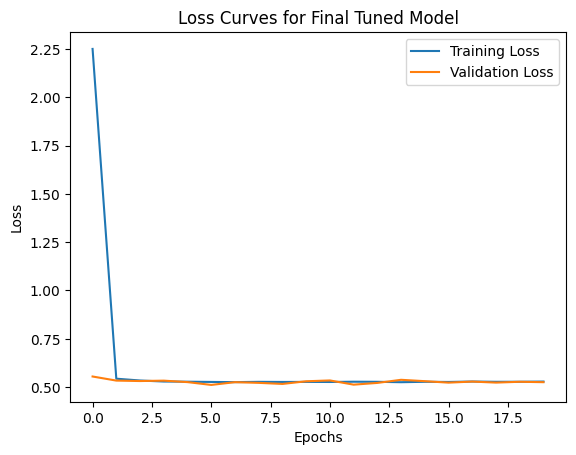

In [ ]:
model_3_after_tuning = create_model(neurons=128, activation='relu', optimizer='adam', kernel_regularizer=l1(0.001)) #combination of hyperparameters from our tuning is used to create the new Final Model
model_3_after_tuning.fit(X_train_3, y_train_3, epochs=20, batch_size=32, validation_data=(X_val_3, y_val_3))

#Plot loss curves for training and validation:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Curves for Final Tuned Model')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
#Evaluate the final model on the test set
y_pred = model_3_after_tuning.predict(X_test_3).round()

# Performance metrics of the Final model on the test data
final_model_3_accuracy = accuracy_score(y_test_3, y_pred)
final_model_3_conf_matrix = confusion_matrix(y_test_3, y_pred)
final_model_3_precision = precision_score(y_test_3, y_pred)
final_model_3_recall = recall_score(y_test_3, y_pred)
final_model_3_auc_score = roc_auc_score(y_test_3, y_pred)

#Print the performance metrics:
print("Final model 3 Accuracy:", final_model_3_accuracy )
print("Final model 3 Confusion Matrix:\n",final_model_3_conf_matrix)
print("Final model 3 Precision:", final_model_3_precision)
print("Final model 3 Recall:", final_model_3_recall)
print("Final model 3 AUC Score:", final_model_3_auc_score)

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Final model 3 Accuracy: 0.9682761372705507
Final model 3 Confusion Matrix:
 [[ 660   91]
 [  68 4193]]
Final model 3 Precision: 0.9787581699346405
Final model 3 Recall: 0.9840413048580146
Final model 3 AUC Score: 0.9314347669429888


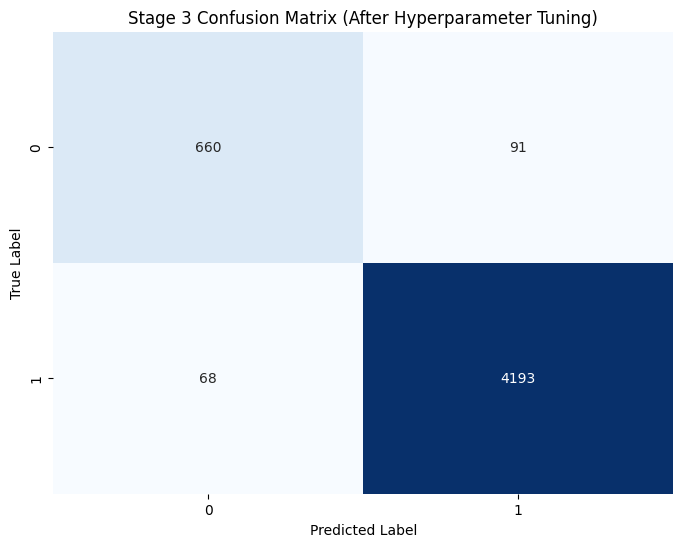

In [ ]:
def plot_confusion_matrix(final_model_3_conf_matrix, title="Confusion Matrix"):
    plt.figure(figsize=(8, 6))
    sns.heatmap(final_model_3_conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(title)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

# Plot confusion matrix before hyperparameter tuning
plot_confusion_matrix(final_model_3_conf_matrix, title="Stage 3 Confusion Matrix (After Hyperparameter Tuning)")

There is a substantial increase in performance metrics between final neural network models for  Stages 2 and 3, compared to the minimal or no improvement observed between the final models in Stage 1 and in Stage 2. The accuracy and AUC score increase from 0.894 & 0.756 in stage 2 to 0.968 and 0.931 in stage 3 respectively.

## Conclusion

-	Both the XGBoost and Neural Network models demonstrate that the most significant improvement in performance metrics comes from the quality and relevance of features rather than hyperparameter tuning. This is evident from the substantial increase in performance metrics between Stages 2 and 3, compared to the minimal or no improvement observed between the final model in Stage 1 and the initial model in Stage 2.
-	The hyperparameter tuning in each stage showed small improvement in the performance metrics in both XGBoost model and the neural networks.
-	XGBoost scored higher than the neural network model in the accuracy and AUC in all three stage datasets, with neural network model scoring slightly higher on precision in only stage 3.
-	XGBoost models were a lot faster to use and created interpretability with the feature importance chart it provided. This allowed for identifying key features
-	The models show that stage 2 model prediction is not greatly better than stage 1 and significantly lower than stage 3. The feature importance chart  emphasises this as all of the top 10 features come from either stage 1 or 3 dataset.


## Evaluation

-	Due to computing restrictions, hyperparameters were tuned in a limited range, this means we may not have fully captured the best hyperparameters for this model
-	The reliability of our model can be improved by increasing the number of epochs
-	The dataset especially for stage 1 consisted of mostly categorical data, this reduced the interpretability of our model’s decision-making process
-	The importance of stage 2 may have been reduced due to unauthorised absence being removed for high cardinality.
